# Load Stuff & General Data Classes
(Run at Start)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r '/content/drive/MyDrive/NLP/Final/electra_sm_nli_snli/eval_output_snli/eval_output_snli' '/content'
!cp -r '/content/drive/MyDrive/NLP/Final/electra_sm_qa_squad/eval_output/eval_output' '/content'

# get fp code
!git clone https://id_rsa.pub@github.com/gregdurrett/fp-dataset-artifacts.git
import os
os.chdir('/content/fp-dataset-artifacts')
!pip install -q --upgrade pip
!pip install -q -r requirements.txt
os.chdir('/content/')

Mounted at /content/drive
Cloning into 'fp-dataset-artifacts'...
remote: Enumerating objects: 36, done.
remote: Total 36 (delta 0), reused 0 (delta 0), pack-reused 36
Receiving objects: 100% (36/36), 14.09 KiB | 14.09 MiB/s, done.
Resolving deltas: 100% (12/12), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00


## General functions (run at start)

In [8]:
!pip install -q transformers
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from typing import List, Dict
from tqdm import tqdm
import argparse
import torch
import numpy as np
import spacy
import gc
import nltk
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# Use Indexer class from prev assignments
class Indexer(object):
    def __init__(self):
        self.objs_to_ints = {}
        self.ints_to_objs = {}
    def __repr__(self):
        return str([str(self.get_object(i)) for i in range(0, len(self))])
    def __str__(self):
        return self.__repr__()
    def __len__(self):
        return len(self.objs_to_ints)
    def get_object(self, index):
        if (index not in self.ints_to_objs):
            return None
        else:
            return self.ints_to_objs[index]
    def contains(self, object):
        return self.index_of(object) != -1
    def index_of(self, object):
        if (object not in self.objs_to_ints):
            return -1
        else:
            return self.objs_to_ints[object]
    def add_and_get_index(self, object, add=True):
        if not add:
            return self.index_of(object)
        if (object not in self.objs_to_ints):
            new_idx = len(self.objs_to_ints)
            self.objs_to_ints[object] = new_idx
            self.ints_to_objs[new_idx] = object
        return self.objs_to_ints[object]

class QAExample:
    def __init__(self, id: str, context: str, question: str, answers: List[str],
                 answer_start: List[int], pred_answer: str):
        self.id = id # from source dataset
        self.context = context # background text
        self.question = question
        self.answer = answers # list of possible answers
        self.answer_start = answer_start # loc of answer in context
        self.pred_answer = pred_answer # predicted answer

    def __repr__(self):
        return repr("...question = " + self.question + "...context = " + self.context +
                    "...answers = " + str(self.answer) + "...predicted answer = " + self.pred_answer )

    def correct(self):
        return self.pred_answer in self.answer

class NLIExample:
    def __init__(self, premise: str, hypoth: str, label: int, pred_scores: List, pred_label: int):
        self.premise = premise # background text
        self.hypoth = hypoth
        self.label = label # list of possible answers
        self.entail_score = pred_scores[0] # loc of answer in context
        self.neutral_score = pred_scores[1]
        self.contr_score = pred_scores[2]
        self.scores = np.array(pred_scores)
        self.pred_label = pred_label # predicted answer

    def __repr__(self):
        return repr("hypothesis = " + self.hypoth + "\npremise = " + self.premise +
                    "\nlabel=" + str(self.label) + "\npredicted_label=" + str(self.pred_label))

    def correct(self):
        return self.label == self.pred_label

def load_nli_examples(path): #nli_path = '/content/eval_output_snli/eval_predictions.jsonl'
    with open(path, 'r') as file:
        all_lines = file.readlines()
        nli_examples = []
        for nextline in all_lines:
            dct = json.loads(nextline)
            nli = NLIExample(dct['premise'], dct['hypothesis'], dct['label'],
                             dct['predicted_scores'], dct['predicted_label'])
            nli_examples.append(nli)
    return nli_examples

def load_qa_examples(path): #path = '/content/eval_output/eval_output/eval_predictions.jsonl'
    with open(path, 'r') as file:
        all_lines = file.readlines()
        qa_examples = []
        for nextline in all_lines:
            dct = json.loads(nextline)
            qa = QAExample(dct['id'], dct['context'], dct['question'], dct['answers']['text'],
                           dct['answers']['answer_start'], dct['predicted_answer'])
            qa_examples.append(qa)
    return qa_examples

def load_unprocessed(path): #nli_path or #qa_path
    with open(path, 'r') as file:
        all_lines = file.readlines()
        examples = []
        for nextline in all_lines:
            ex = json.loads(nextline)
            examples.append(ex)
    return examples


def load_nli_examples_fromHF(dataset):
    #load huggingface dataset into class obj, which was faster to work with in my custom functions
    nli_examples = []
    for ex in dataset:
        nli = NLIExample(ex['premise'], ex['hypothesis'], ex['label'],[0, 0, 0] ,-1) # dummy scores
        nli_examples.append(nli)
    return nli_examples


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Competency Problem Functions (Run @ start)

In [9]:
# BEST OUTPUT - COMPETENCY PROBLEMS RELATED FUNCTIONS
import string
import matplotlib.pyplot as plt
from nltk import ngrams
m_words = ['he', 'him', 'his', 'man', 'boy', 'guy', 'lad', 'mr', 'dad', 'father', 'son', 'grandson', 'grandfather',
           'grandpa', 'uncle', 'brother', 'husband', 'boyfriend']
f_words = ['she', 'her', 'hers', 'woman', 'girl', 'lady', 'mrs', 'mom', 'mother', 'daughter', 'granddaughter',
           'grandmother', 'grandma', 'aunt', 'sister', 'wife', 'girlfriend']
others = ['we', 'them', 'herself', 'himself', 'i', 'me', 'myself', 'ourselves', 'our', "she's",
          'themselves', "he's", 'your','yours','yourself','yourselves']
genders = m_words + f_words
nltk.download('punkt')
stop_words = set(stopwords.words('english'))


# same thing but with stopwords removed during tokenization:
def tokenize_and_count(text, n_gram_size, gap_gram, rm_stop, gentle_rm=True, keep_genders=True):
    '''
    text is just a sentence (str)
    returns tokenization of string and Counter of tokens
    '''
    # in the paper they "remove punctuation and lowercase, tokenizing on whitespace"
    rm_punct = str.maketrans('', '', string.punctuation)
    np_text = text.translate(rm_punct)
    toks = nltk.word_tokenize(np_text.lower())
    if rm_stop:
        if keep_genders:
            sw = stop_words - set(genders) - set(others) # genders defined above
        if gentle_rm: # gentle rm leaves the first word if the resulting string would be zero
            test = [word for word in toks if word not in sw]
            if n_gram_size > 1 and len(test) < 2:
                toks = [toks[0]] + [word for word in toks[1:] if word not in sw] # keep first one regardless
            else:
                toks = test
        else:
            toks = [word for word in toks if word not in sw]

    if n_gram_size > 1:
        toksl = list(ngrams(toks, n_gram_size))
        if len(toksl) == 0: # there was only one word coming from uni_toks
            # toks stays the same
            toks = toks
        else:
            toks = [' '.join(x) for x in toksl] # make bigram into a string
    if gap_gram: # get every other word when gap is 2
        gap = 2
        toks = [' '.join((toks[i], toks[i+gap])) for i in range(len(toks)-gap) if i+n_gram_size < len(toks)]
    ### If you want to do other n-grams change tokenize step #######
    return Counter(toks), toks

def make_counters_by_label(nli_examples, big=False, n_gram_size=1, gap_gram=False, rm_stop=False, gentle_rm=True, keep_genders=True):
    '''
    nli_examples is a list of NLIExample class objects OR a huggingface dataset
    big is whether the nli_examples is huggingface (big) or not
    concats hypothesis and premise, but doesn't have to be that way
    returns a bunch of counters related to occurrences w/in labels
    gentle_rm is removing stopwords but keeping at least the first word of the sentence if only one token remains afterwards.
    keep_genders tells us whether we will include gender words in tokenization or not (some are removed w/stopwords)
    '''
    big_counter = Counter() # count # occurrences overall
    e_counter = Counter() # count # occurrences in entails
    n_counter = Counter() # count # occurrences in neutral
    c_counter = Counter() # count # occurrences in contradict

    if big:
        iter = 0
        for ex in nli_examples:
            label = ex['label']
            sentence = ex['premise'] + ' ' + ex['hypothesis'] # text block includes prem + hypothesis
            ctr, toks = tokenize_and_count(sentence, n_gram_size, gap_gram, rm_stop, gentle_rm, keep_genders)
            if label == 0:
                e_counter += ctr # add occurrences to e_ctr
            elif label == 1:
                n_counter += ctr # add occurrences to n_ctr
            else: # label == 2
                c_counter += ctr # add occurrences to c_ctr
            big_counter += ctr # add occurrences to all counter
            iter += 1
            if iter % 10000 == 0:
                print('iter: ', iter, ' ',100*iter/len(nli_examples),'% complete')
    else:
        iter = 0
        for ex in nli_examples:
            label = ex.label
            sentence = ex.premise + ' ' + ex.hypoth # text block includes prem + hypothesis
            ctr, toks = tokenize_and_count(sentence, n_gram_size, gap_gram, rm_stop, gentle_rm, keep_genders)
            if label == 0:
                e_counter += ctr # add occurrences to e_ctr
            elif label == 1:
                n_counter += ctr  # add occurrences to n_ctr
            else: # label == 2
                c_counter += ctr # add occurrences to c_ctr
            big_counter += ctr # add occurrences to all counter
            iter += 1
            if iter % 10000 == 0:
                print('iter: ', iter, ' ',100*iter/len(nli_examples),'% complete')

    return big_counter, e_counter, n_counter, c_counter

def get_p_hat_z_scores(big_counter, e_counter, n_counter, c_counter):
    '''
    big_counter, e_counter, n_counter, c_counter are as returned from
    make_counters_by_label
    makes dictionaries of p_hats and z_scores for each word (by label)
    z-scores tell how far away from mean we are in terms of normal distribution
    phats are empirical probability label L given a token xi.  (expect 1/3)
    '''
    label_sets = [e_counter, n_counter, c_counter]
    label_names = [0, 1, 2]
    p0 = 1/len(label_sets) # SNLI has 3 labels so uniform dist has probability 1/3

    p_hats = {}
    z_scores = {}
    # for each label, make a sub-dictionary of z-scores and p-hats we can calculate. add these chunks to one big dictionary.
    for label in label_names:
        p_hats[label] = {} # empty sub-dictionary by label to hold z-scores
        z_scores[label] = {} # empty sub-dictionary by label to hold z-scores
        label_count_set = label_sets[label] # get label counter set

        for word in big_counter:
            # need to keep p_hat and z_score for plotting, analysis
            p_hat = label_count_set[word]/big_counter[word] # label freq / overall freq
            # p0 is 1/3, p_hat is observed prob above, n is overall freq
            n = big_counter[word] # number of examples
            z_score = (p_hat - p0)/np.sqrt((p0* (1 - p0))/ n) # from paper
            z_scores[label][word] = z_score
            p_hats[label][word] = p_hat
    return p_hats, z_scores

def make_plots_paper(big_ctr, e_ctr, n_ctr, c_ctr, z_scores, p_hats, plot_cutoff=0):
    # Attempt to reproduce plots in the paper to ensure the method is correct
    '''
    try to make plots look like the paper to ensure results reproduced accurately
    note : looks like some kind of cutoff @ beginning for low freq words
    note : paper has log scale on x-axis, otherwise too squished
    plots unlikely artifacts in blue and likely artifacts in red
    cutoff_val is if you want to cut off data for words with small occurrences
    '''
    from scipy.stats import norm
    # in paper they have Bonferroni correction based on size of vocab. They have 28k.
    # we have len(big_ctr) which is size of our vocab, so alpha depends on size of corpus
    # for a given regular alpha, the new significance level is alpha * (1/len(dataset))
    sig = 0.01 # change? maybe 0.05?
    alpha = sig * (1/len(big_ctr))
    # this is the alpha equivalent to 0.01 significance, but factoring in size of vocab
    # below we find z threshold to reject null hypothesis that p = 1/3
    # reject_null_z changes based on dataset!!
    reject_null_z = norm.ppf(1- alpha/2) # normal dist zscore cutoff for the alpha
    # we have 'sig' significance @ this z. anything above this z is statistically different enough
    print('significant z is: ', reject_null_z)
    p0 = 1/3
    label_sets = [e_ctr, n_ctr, c_ctr]
    label_names = [0, 1, 2]
    sm_freq_cutoff = plot_cutoff # set to zero for no cutoff - weird output with no cutoff

    for label_id in label_names:
        label_count_set = label_sets[label_id] # freq of word within label
        p_hat = p_hats[label_id] # p_hat by word within label
        z_score = z_scores[label_id] # z_score by word within label
        # below get only overall counts for words that appear w/ given label

        # BELOW: below_cutoff, probably not artifacts
        p_hat_b = []
        z_score_b = []
        big_ctr_b = []
        for word in big_ctr: # get subset from dictionaries for given label cat for plot
            if big_ctr[word] > sm_freq_cutoff and z_score[word] < reject_null_z:
                big_ctr_b.append(big_ctr[word])
                z_score_b.append(z_score[word])
                p_hat_b.append(p_hat[word])

        # BELOW: above cutoff, probably artifacts
        p_hat_a = []
        z_score_a = []
        big_ctr_a = []
        for word in big_ctr:  # get subset from dictionaries for given label cat for plot
            if big_ctr[word] > sm_freq_cutoff and z_score[word] >= reject_null_z:
                big_ctr_a.append(big_ctr[word])
                z_score_a.append(z_score[word])
                p_hat_a.append(p_hat[word])

        # plot likely non-artifacts
        plt.scatter(big_ctr_b, p_hat_b, marker='.', color='blue', alpha=.5, s=2)
        # plot possible artifacts
        plt.scatter(big_ctr_a, p_hat_a, marker='.', color='red', alpha=.5, s=2)
        # all_words are in big_ctr for annotation later #plt.annotate(...)
        plt.xlabel('# occurrences')
        plt.ylabel('p_hat(y|xi)')
        plt.title('Possible dataset artifacts (red)')
        plt.xscale('log') # rescale to match paper, otherwise too squished

    return reject_null_z # use for output analysis

def write_zip_data(list_of_dicts, list_of_dict_names, path):
    ''' Examples:
    keep important files for analysis because it takes a long time to run
    items_to_write = [big_ctr, e_ctr, n_ctr, c_ctr, p_hats, z_scores]
    names = ['big_ctr', 'e_ctr', 'n_ctr', 'c_ctr', 'p_hats', 'z_scores']
    path = '/content/c_set/train_results.zip'
    '''
    import zipfile
    import json
    with zipfile.ZipFile(path, 'w') as zipf:
        # each one becomes its own file in the zip
        for i, item in enumerate(items_to_write, start=0):
            name = f'{names[i]}.json'
            data = json.dumps(item)
            zipf.writestr(name, data)
    print('zip creation done!')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## tf-idf and other NLI Functions, Load Basic Data (Run @ start)


In [7]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

class TOK_NLIExample: #nli example with tokenization
    ''' more customized class of NLI examples to make analysis easier and more consistent w/ tokenization
    '''
    def __init__(self, premise: str, hypoth: str, label: int, pred_scores: List, pred_label: int):
        self.premise = premise # background text
        self.hypoth = hypoth
        self.label = label # list of possible answers
        self.entail_score = pred_scores[0] # loc of answer in context
        self.neutral_score = pred_scores[1]
        self.contr_score = pred_scores[2]
        self.scores = np.array(pred_scores)
        self.pred_label = pred_label # predicted answer

    def __repr__(self):
        return repr("hypothesis = " + self.hypoth + "\npremise = " + self.premise +
                    "\nlabel=" + str(self.label) + "\npredicted_label=" + str(self.pred_label))

    def correct(self):
        return self.label == self.pred_label

    def tok_hypoth(self, use_bigram, rm_stops=False, gap_gram=False, both=False, gentle_rm=True, keep_genders=True):
        # tokenize the hypothesis
        rm_punct = str.maketrans('', '', string.punctuation)
        np_text = self.hypoth.translate(rm_punct)
        uni_toks = nltk.word_tokenize(np_text.lower())
        n_gram_size=2
        if rm_stops:
            if keep_genders:
                sw = stop_words - set(genders) - set(others) # genders defined above
            if gentle_rm: # gentle rm leaves the first word if the resulting string would be zero
                test = [word for word in uni_toks if word not in sw]
                if n_gram_size > 1 and len(test) < 2:
                    uni_toks = [uni_toks[0]] + [word for word in uni_toks[1:] if word not in sw] # keep first one regardless
                else:
                    uni_toks = test
            else:
                uni_toks = [x for x in uni_toks if x not in sw]

        if use_bigram:
            bi_toks = list(ngrams(uni_toks, 2))
            if len(bi_toks) == 0: # there was only one word coming from uni_toks
                bi_toks = uni_toks
            else:
                bi_toks = [' '.join(x) for x in bi_toks]
            if both:
                all_toks = uni_toks + bi_toks
            else:
                all_toks = bi_toks
        elif gap_gram: # get every other word when gap is 2
            gap_toks = [' '.join((uni_toks[i], uni_toks[i+2])) for i in range(len(uni_toks)-2) if i+n_gram_size < len(uni_toks)]
            all_toks = gap_toks
        else:
            all_toks = uni_toks
        return all_toks


    def tok_premise(self, use_bigram, rm_stops=False, gap_gram=False, both=False, gentle_rm=True, keep_genders=True):
        # tokenize the premise
        rm_punct = str.maketrans('', '', string.punctuation)
        np_text = self.premise.translate(rm_punct)
        uni_toks = nltk.word_tokenize(np_text.lower())
        n_gram_size = 2
        if rm_stops:
            if keep_genders:
                sw = stop_words - set(genders) - set(others) # genders defined above
            if gentle_rm: # gentle rm leaves the first word if the resulting string would be zero
                test = [word for word in uni_toks if word not in sw]
                if n_gram_size > 1 and len(test) < 2:
                    uni_toks = [uni_toks[0]] + [word for word in uni_toks[1:] if word not in sw] # keep first one regardless
                else:
                    uni_toks = test
            else:
                uni_toks = [x for x in uni_toks if x not in sw]

        if use_bigram:
            bi_toks = list(ngrams(uni_toks, 2))
            if len(bi_toks) == 0: # there was only one word coming from uni_toks
                bi_toks = uni_toks
            else:
                bi_toks = [' '.join(x) for x in bi_toks]
            if both:
                all_toks = uni_toks + bi_toks
            else:
                all_toks = bi_toks
        elif gap_gram: # get every other word when gap is 2
            gap_toks = [' '.join((uni_toks[i], uni_toks[i+2])) for i in range(len(uni_toks)-2) if i+n_gram_size < len(uni_toks)]
            all_toks = gap_toks
        else:
            all_toks = uni_toks
        return all_toks

    def tok_all(self, use_bigram, rm_stops=False, gap_gram=False, both=False):
        all_tok = self.tok_hypoth(use_bigram, rm_stops, gap_gram, both) + self.tok_premise(use_bigram, rm_stops, gap_gram, both)
        return all_tok


def load_nli_examples_tok(path): #nli_path = '/content/eval_output_snli/eval_predictions.jsonl'
    with open(path, 'r') as file:
        all_lines = file.readlines()
        nli_examples = []
        for nextline in all_lines:
            dct = json.loads(nextline)
            nli = TOK_NLIExample(dct['premise'], dct['hypothesis'], dct['label'],
                             dct['predicted_scores'], dct['predicted_label'])
            nli_examples.append(nli)
    return nli_examples

def calc_tf_idf(nli_ex, lemma=True, more=False, is_bigram=False, gap_gram=False, rm_stops=False):
    # Used from my HW4 and slightly modified - did not end up being useful here
    label = nli_ex.label
    # tokenized words, tokenized sentences, count of unique words in doc, indexer, label
    # for snli, doc is premise + hypothesis

    # Get stuff needed for tf-idf:
    idx = Indexer()
    s_tok = [nli_ex.tok_premise(is_bigram, rm_stops, gap_gram), nli_ex.tok_hypoth(is_bigram, rm_stops, gap_gram)] # tokenized premise, tokenized hypoth
    if lemma:
        lemmatizer = WordNetLemmatizer()
        new_s_tok = []
        for s in s_tok:
            new_s_tok.append([lemmatizer.lemmatize(word) for word in s])
        s_tok = new_s_tok
    for s in s_tok: # each doc
        for word in s: # each word in doc
            idx.add_and_get_index(word)

    ctr = Counter(s_tok[0]) + Counter(s_tok[1]) # counter for words in both hyp and prem
    bow = ctr.keys() # unique BOW for this example

    #tf for one word in doc
    def tf_func(doc, word):
        n = len(doc)
        count = [w for w in doc if w == word]
        return (len(count)/n)

    #idf for one word in doc
    def idf_func(word, ctr, docs):
        if idx.index_of(word) == -1:
            count = 0.01# so denom is not zero if not in index
        else:
            count = ctr[word]  # get count of word occurrence overall
        return np.log(len(docs)/count) # log of: (num docs / count of word)

    def tf_idf(sent, ctr, docs, idx):
        vec = np.zeros(len(idx))
        for word in sent:
            tf = tf_func(sent, word)
            idf = idf_func(word, ctr, docs)
            word_idx = idx.index_of(word)
            vec[word_idx] = tf * idf
        return vec

    def tf_idf_cos(doc, fact_vec): # cosine similarity
        similarity = np.dot(doc, fact_vec) / (np.linalg.norm(doc) * np.linalg.norm(fact_vec) + 0.001)  # + 0.001 to avoid dividing by zero
        return similarity

    all_vectors = []
    for s in s_tok:
        vec = tf_idf(s, ctr, s_tok, idx)
        all_vectors.append(vec)
    premise_vecs = all_vectors[0] # premise
    hypoth_vec = all_vectors[1] #
    similarity = tf_idf_cos(premise_vecs, hypoth_vec)

    count_intersection = []
    percent_fact_overlap = []
    prem = set(s_tok[0]) # set of unique words in premise
    hyp = set(s_tok[1]) # set of unique words in hypoth
    inter = len(prem & hyp) # words in common w/ prem & hyp
    uni = len(prem.union(hyp))

    if uni == 0:
        iou = 0  # words in either hyp or prem or both
    else:
        iou = inter / uni # intersection over union
    if len(hyp) == 0:
        perc_bow_overlap = 0
    else:
        perc_bow_overlap = round(inter/len(hyp), 3) # percent of unique words in hypothesis that are in hyp and prem
    if len(s_tok[1]) == 0:
        perc_counts_overlap = 0
    else:
        perc_counts_overlap = sum((Counter(s_tok[0]) & Counter(s_tok[1])).values())/len(s_tok[1]) # percent of words in hypoth present in premise

    if more: # return some of the sets also
        return nli_ex, similarity, inter, uni, iou, perc_bow_overlap, perc_counts_overlap, set(bow), s_tok
    else: # return numeric values
        return similarity, iou, perc_bow_overlap, perc_counts_overlap

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Load some data

In [11]:
# load and split snli by correctness
snli = load_nli_examples_tok('/content/eval_output_snli/eval_predictions.jsonl')
wrong_snli = [x for x in snli if not x.correct()]
correct_snli = [x for x in snli if x.correct()]
print(f'Correct predictions for snli : {100*np.round(len(correct_snli)/(len(wrong_snli) + len(correct_snli)), 4)} % ')

######################
do_calcs = False
######################

# now we load the results from competency problems
!cp -r '/content/drive/MyDrive/NLP/Final/snli_train_unigram.zip' '/content'
!cp -r '/content/drive/MyDrive/NLP/Final/snli_train_bigram.zip' '/content'
!cp -r '/content/drive/MyDrive/NLP/Final/snli_train_gapgram.zip' '/content'
!cp -r '/content/drive/MyDrive/NLP/Final/snli_train_bigram_nstop.zip' '/content'
!cp -r '/content/drive/MyDrive/NLP/Final/snli_train_bigram_nstop_gen.zip' '/content'
!unzip -q '/content/snli_train_bigram.zip' -d '/content/snli_train_bigram/'
!unzip -q '/content/snli_train_unigram.zip' -d '/content/snli_train_unigram/'
!unzip -q '/content/snli_train_gapgram.zip' -d '/content/snli_train_gapgram/'
!unzip -q '/content/snli_train_bigram_nstop.zip' -d '/content/snli_train_bigram_nstop/'
!unzip -q '/content/snli_train_bigram_nstop_gen.zip' -d '/content/snli_train_bigram_nstop_gen/'

# load unigram competency results
uni_z = load_unprocessed('/content/snli_train_unigram/z_scores.json')[0]
uni_p = load_unprocessed('/content/snli_train_unigram/p_hats.json')[0]
# load bigram competency results
bi_z = load_unprocessed('/content/snli_train_bigram/z_scores.json')[0]
bi_p = load_unprocessed('/content/snli_train_bigram/p_hats.json')[0]
# load gapgram competency results
gap_z = load_unprocessed('/content/snli_train_gapgram/z_scores.json')[0]
gap_p = load_unprocessed('/content/snli_train_gapgram/p_hats.json')[0]
# load bigram nstop competency results
bin_z = load_unprocessed('/content/snli_train_bigram_nstop/z_scores.json')[0]
bin_p = load_unprocessed('/content/snli_train_bigram_nstop/p_hats.json')[0]
# load bigram nstop gen competency results
bing_z = load_unprocessed('/content/snli_train_bigram_nstop_gen/z_scores.json')[0]
bing_p = load_unprocessed('/content/snli_train_bigram_nstop_gen/p_hats.json')[0]

# thresholds for each analysis
SIG_UNIGRAM = 5.0792985794833445
SIG_BIGRAM = 5.540996343666001
SIG_BIGRAM_NSTOP = 5.59784494142142
SIG_GAPGRAM = 5.5980747442247765
SIG_BIGRAM_NSTOP_GEN = 5.525896370732502

def flag_word_dict_list(z_scores, sig):
    # identify words over threshold
    # in z scores, list entries 0 for entail, 1 for neut, 2 for contradict
    # sig is a float
    flags = []
    for cat in z_scores:
        flags.append({key: value for key, value in z_scores[cat].items() if value > sig})
    return flags

def find_unique_flag_keys(flag_dict_list):
    return list(set(flag_dict_list[0].keys()) | set(flag_dict_list[1].keys()) | set(flag_dict_list[2].keys()))

import json
def write_file_json(path, lst):
    with open(path, 'w') as json_file:
        json.dump(lst, json_file)

if do_calcs:
    # flag words (likely artifacts)
    uni_flags = flag_word_dict_list(uni_z, SIG_UNIGRAM)
    bi_flags = flag_word_dict_list(bi_z, SIG_BIGRAM)
    gap_flags = flag_word_dict_list(gap_z, SIG_GAPGRAM)
    bi_ns_flags = flag_word_dict_list(bin_z, SIG_BIGRAM_NSTOP)
    bi_ns_gen_flags = flag_word_dict_list(bing_z, SIG_BIGRAM_NSTOP_GEN)

    # find unique words that are possibly artifacts in certain contexts
    uni_unique_keys = find_unique_flag_keys(uni_flags)
    bi_unique_keys = find_unique_flag_keys(bi_flags)
    gap_unique_keys = find_unique_flag_keys(gap_flags)
    bi_ns_unique_keys = find_unique_flag_keys(bi_ns_flags)
    bi_ns_gen_unique_keys = find_unique_flag_keys(bi_ns_gen_flags)
    uni_bi_keys = list(set(uni_unique_keys) | set(bi_unique_keys))

    # write flags
    write_file_json('/content/uni_flags.jsonl', uni_flags)
    write_file_json('/content/bi_flags.jsonl', bi_flags)
    write_file_json('/content/gap_flags.jsonl', gap_flags)
    write_file_json('/content/bi_ns_flags.jsonl', bi_ns_flags)
    write_file_json('/content/bi_ns_gen_flags.jsonl', bi_ns_gen_flags)

    # write keys
    write_file_json('/content/uni_unique_keys.jsonl', uni_unique_keys)
    write_file_json('/content/bi_unique_keys.jsonl', bi_unique_keys)
    write_file_json('/content/gap_unique_keys.jsonl', gap_unique_keys)
    write_file_json('/content/bi_ns_unique_keys.jsonl', bi_ns_unique_keys)
    write_file_json('/content/bi_ns_gen_unique_keys.jsonl', bi_ns_gen_unique_keys)

    !cp -r '/content/uni_flags.jsonl' '/content/drive/MyDrive/NLP/Final'
    !cp -r '/content/bi_flags.jsonl' '/content/drive/MyDrive/NLP/Final'
    !cp -r '/content/gap_flags.jsonl' '/content/drive/MyDrive/NLP/Final'
    !cp -r '/content/bi_ns_flags.jsonl' '/content/drive/MyDrive/NLP/Final'
    !cp -r '/content/bi_ns_gen_flags.jsonl' '/content/drive/MyDrive/NLP/Final'

    !cp -r '/content/uni_unique_keys.jsonl' '/content/drive/MyDrive/NLP/Final'
    !cp -r '/content/bi_unique_keys.jsonl' '/content/drive/MyDrive/NLP/Final'
    !cp -r '/content/gap_unique_keys.jsonl' '/content/drive/MyDrive/NLP/Final'
    !cp -r '/content/bi_ns_unique_keys.jsonl' '/content/drive/MyDrive/NLP/Final'
    !cp -r '/content/bi_ns_gen_unique_keys.jsonl' '/content/drive/MyDrive/NLP/Final'

    print('\ndone')

else:
    # load flag words
    !cp -r '/content/drive/MyDrive/NLP/Final/uni_flags.jsonl' '/content'
    !cp -r '/content/drive/MyDrive/NLP/Final/bi_flags.jsonl' '/content'
    !cp -r '/content/drive/MyDrive/NLP/Final/gap_flags.jsonl' '/content'
    !cp -r '/content/drive/MyDrive/NLP/Final/bi_ns_flags.jsonl' '/content'
    !cp -r '/content/drive/MyDrive/NLP/Final/bi_ns_gen_flags.jsonl' '/content'
    # load unique keys
    !cp -r '/content/drive/MyDrive/NLP/Final/uni_unique_keys.jsonl' '/content/uni_unique_keys.jsonl'
    !cp -r '/content/drive/MyDrive/NLP/Final/bi_unique_keys.jsonl' '/content/bi_unique_keys.jsonl'
    !cp -r  '/content/drive/MyDrive/NLP/Final/gap_unique_keys.jsonl' '/content/gap_unique_keys.jsonl'
    !cp -r  '/content/drive/MyDrive/NLP/Final/bi_ns_unique_keys.jsonl' '/content/bi_ns_unique_keys.jsonl'
    !cp -r  '/content/drive/MyDrive/NLP/Final/bi_ns_gen_unique_keys.jsonl' '/content/bi_ns_unique_keys.jsonl'

    print('\ndone')

Correct predictions for snli : 89.52 % 

done


# SNLI Competency Analysis - Do Not Edit

### Unigram (Reference but do not edit)

Downloading:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

significant z is:  5.0792985794833445


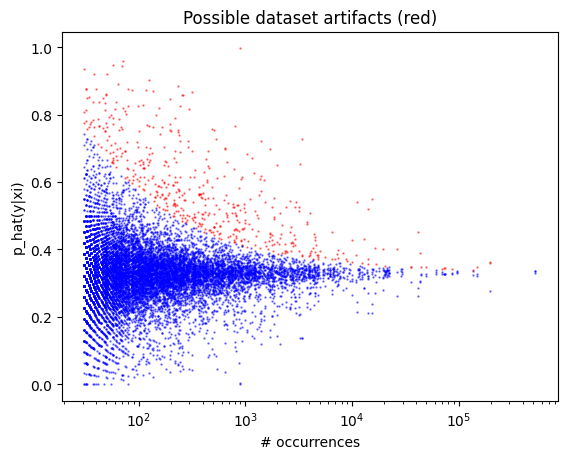

In [ ]:
# Load and split NLI data
nli_path = '/content/eval_output_snli/eval_predictions.jsonl'
nli_examples = load_nli_examples(nli_path)

# To actually get data and plots
from datasets import load_dataset
big_nli_set = load_dataset('snli', split='train') # huggingface dataset

subset = big_nli_set.shuffle(seed=42).select([i for i in range(200000)]) # 200k examples
# TRAIN SET is 550k examples and takes a long time, can do smaller set
small_nli = nli_examples#[0:500] # if using set big=False below
# 100k examples takes a while. for shorter results try choice = small_nli

big = True # nli huggingface data has diff structure
#big = False # nli examples are custom class

n_gram_size = 1
big_ctr, e_ctr, n_ctr, c_ctr = make_counters_by_label(subset, big, n_gram_size)
p_hats, z_scores = get_p_hat_z_scores(big_ctr, e_ctr, n_ctr, c_ctr)
sig_z = make_plots_paper(big_ctr, e_ctr, n_ctr, c_ctr, z_scores, p_hats, plot_cutoff=30)

# Anything with z-scores above the significant level printed is likely an artifact
# Value will be in gathering the words identified w/ label artifacts
# note z_scores is a dictionary with z_scores[label][word] so should be easy to access this info

In [ ]:
sig = sig_z #4.803727203433305 # from output above
print(f'There are {len(subset)} examples')
print(f'Z-score for significance: {sig_z}.\nAny z-scores >= this are likely artifacts')
print(f'There are {len(big_ctr)} unique words in the dataset')
sig_z_entail = {key: value for key, value in z_scores[0].items() if value > sig_z}
sig_z_neut = {key: value for key, value in z_scores[1].items() if value > sig_z}
sig_z_contr = {key: value for key, value in z_scores[2].items() if value > sig_z}
# note the outputs below - some of these words are annotated in the plot in the paper
# more will appear if we include more data

# Get top artifacts
top_z_e = dict(sorted(z_scores[0].items(), key=lambda item: item[1], reverse=True)[:5])
top_z_n = dict(sorted(z_scores[1].items(), key=lambda item: item[1], reverse=True)[:5])
top_z_c = dict(sorted(z_scores[2].items(), key=lambda item: item[1], reverse=True)[:5])
print(f'\ntop entailment artifact words:\n{top_z_e}')
print(f'\ntop neutral artifact words:\n{top_z_n}')
print(f'\ntop contradiction artifact words:\n{top_z_c}')

items_to_write = [big_ctr, e_ctr, n_ctr, c_ctr, p_hats, z_scores]
names = ['big_ctr', 'e_ctr', 'n_ctr', 'c_ctr', 'p_hats', 'z_scores']
zip_path = '/content/snli_train_unigram.zip'
write_zip_data(items_to_write, names, zip_path)
!cp -r '/content/snli_train_unigram.zip' '/content/drive/MyDrive/NLP/Final'

There are 200000 examples
Z-score for significance: 5.0792985794833445.
Any z-scores >= this are likely artifacts
There are 26397 unique words in the dataset

top entailment artifact words:
{'outside': 46.80391985947917, 'there': 46.668497397832404, 'outdoors': 39.06603060733542, 'people': 24.832522652037063, 'person': 23.23570710132014}

top neutral artifact words:
{'for': 56.8969780823003, 'to': 51.075792303174886, 'friends': 29.817487010906365, 'the': 26.114029091858377, 'about': 24.08280570826477}

top contradiction artifact words:
{'sleeping': 48.84220618054475, 'nobody': 42.1431506950023, 'no': 31.954513125549408, 'cat': 30.80410455025202, 'the': 26.98652082384679}
zip creation done!


In [ ]:
!cp -r '/content/snli_train_unigram.zip' '/content/drive/MyDrive/NLP/Final'

In [ ]:
# entailment artifacts
sig_z_entail

NameError: ignored

In [ ]:
# neutral artifacts
sig_z_neut

{'to': 10.479323733317184,
 'the': 4.873743987411003,
 'for': 12.64051693961476,
 'tall': 6.715471761210062,
 'he': 5.010216834356845,
 'they': 5.066596844771049,
 'friends': 5.845671475544962,
 'going': 5.543218625245871,
 'about': 5.330497273560129,
 'because': 5.013026509266503}

In [ ]:
# contradiction artifacts
sig_z_contr

{'the': 5.668142787121161,
 'eating': 5.998217203942224,
 'nobody': 10.295630140987,
 'swimming': 5.405598661980923,
 'driving': 5.913164739915446,
 'inside': 4.935167915374427,
 'cat': 6.6996452071463715,
 'sleeping': 10.44367859210591,
 'asleep': 7.9796252170544415,
 'alone': 7.454993164109749,
 'naked': 5.130976815083369,
 'sleeps': 5.130976815083369,
 'empty': 5.197077581161877,
 'no': 5.959900012858045}

### Bigram (reference but do not edit)


significant z is:  5.540996343666001


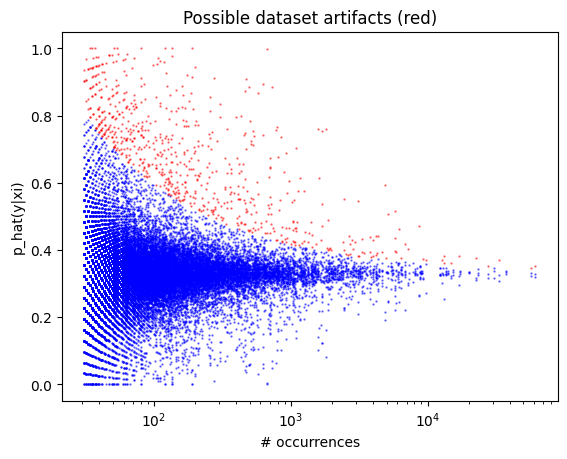

In [ ]:
# Load and split NLI data
nli_path = '/content/eval_output_snli/eval_predictions.jsonl'
nli_examples = load_nli_examples(nli_path)

# To actually get data and plots
from datasets import load_dataset
big_nli_set = load_dataset('snli', split='train') # huggingface dataset

subset = big_nli_set.shuffle(seed=42).select([i for i in range(200000)]) # 200k examples
# TRAIN SET is 550k examples and takes a long time, can do smaller set
small_nli = nli_examples#[0:500] # if using set big=False below
# 100k examples takes a while. for shorter results try choice = small_nli

big = True # nli huggingface data has diff structure
#big = False # nli examples are custom class

n_gram_size = 2
big_ctr, e_ctr, n_ctr, c_ctr = make_counters_by_label(subset, big, n_gram_size)
p_hats, z_scores = get_p_hat_z_scores(big_ctr, e_ctr, n_ctr, c_ctr)
sig_z = make_plots_paper(big_ctr, e_ctr, n_ctr, c_ctr, z_scores, p_hats, plot_cutoff=30)

# Anything with z-scores above the significant level printed is likely an artifact
# Value will be in gathering the words identified w/ label artifacts
# note z_scores is a dictionary with z_scores[label][word] so should be easy to access this info

In [ ]:
print(f'there are {len(subset)} examples')
print(f'z-score for significance: {sig_z}.\nany z-scores >= this are likely artifacts')
print(f'there are {len(big_ctr)} unique words in the dataset')
sig_z_entail = {key: value for key, value in z_scores[0].items() if value > sig_z}
sig_z_neut = {key: value for key, value in z_scores[1].items() if value > sig_z}
sig_z_contr = {key: value for key, value in z_scores[2].items() if value > sig_z}
# note the outputs below - some of these words are annotated in the plot in the paper
# more will appear if we include more data

# Get top artifacts
top_z_e = dict(sorted(z_scores[0].items(), key=lambda item: item[1], reverse=True)[:5])
top_z_n = dict(sorted(z_scores[1].items(), key=lambda item: item[1], reverse=True)[:5])
top_z_c = dict(sorted(z_scores[2].items(), key=lambda item: item[1], reverse=True)[:5])
print(f'\ntop entailment artifact words:\n{top_z_e}')
print(f'\ntop neutral artifact words:\n{top_z_n}')
print(f'\ntop contradiction artifact words:\n{top_z_c}')

items_to_write = [big_ctr, e_ctr, n_ctr, c_ctr, p_hats, z_scores]
names = ['big_ctr', 'e_ctr', 'n_ctr', 'c_ctr', 'p_hats', 'z_scores']
zip_path = '/content/snli_train_bigram.zip'
write_zip_data(items_to_write, names, zip_path)

There are 200000 examples
Z-score for significance: 5.540996343666001.
Any z-scores >= this are likely artifacts
There are 332496 unique words in the dataset

top entailment artifact words:
{'there are': 38.42613566960612, 'is outside': 38.417554444887685, 'are outside': 35.9534381628465, 'there is': 29.30858036787185, 'is outdoors': 27.064399260228797}

top neutral artifact words:
{'for a': 26.338825416866563, 'for the': 25.133274028956798, 'for his': 24.996092239575315, 'going to': 24.84113223131763, 'waiting for': 23.716022409452886}

top contradiction artifact words:
{'is sleeping': 36.64704977824743, 'nobody is': 36.442102926033805, 'at home': 31.505535472867283, 'are sleeping': 29.63735136873479, 'watching tv': 26.438567636549013}
zip creation done!


In [ ]:
!cp -r '/content/snli_train_bigram.zip' '/content/drive/MyDrive/NLP/Final'

### Gap-Gram (Reference but do not edit)

iter:  5000   2.5 % complete
iter:  10000   5.0 % complete
iter:  15000   7.5 % complete
iter:  20000   10.0 % complete
iter:  25000   12.5 % complete
iter:  30000   15.0 % complete
iter:  35000   17.5 % complete
iter:  40000   20.0 % complete
iter:  45000   22.5 % complete
iter:  50000   25.0 % complete
iter:  55000   27.5 % complete
iter:  60000   30.0 % complete
iter:  65000   32.5 % complete
iter:  70000   35.0 % complete
iter:  75000   37.5 % complete
iter:  80000   40.0 % complete
iter:  85000   42.5 % complete
iter:  90000   45.0 % complete
iter:  95000   47.5 % complete
iter:  100000   50.0 % complete
iter:  105000   52.5 % complete
iter:  110000   55.0 % complete
iter:  115000   57.5 % complete
iter:  120000   60.0 % complete
iter:  125000   62.5 % complete
iter:  130000   65.0 % complete
iter:  135000   67.5 % complete
iter:  140000   70.0 % complete
iter:  145000   72.5 % complete
iter:  150000   75.0 % complete
iter:  155000   77.5 % complete
iter:  160000   80.0 % complete

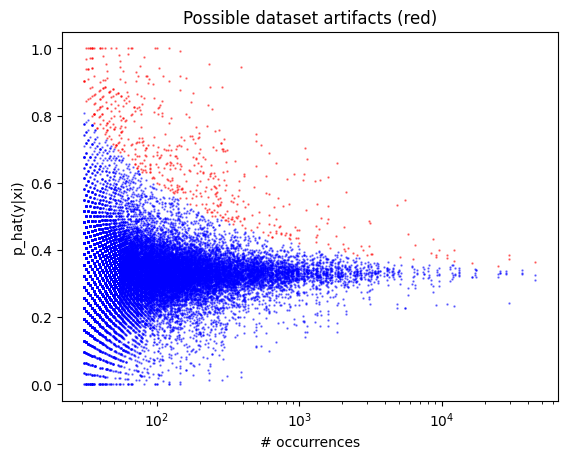

In [ ]:
# Load and split NLI data
nli_path = '/content/eval_output_snli/eval_predictions.jsonl'
nli_examples = load_nli_examples(nli_path)

# To actually get data and plots
from datasets import load_dataset
#big_nli_set = load_dataset('snli', split='train') # huggingface dataset

subset = big_nli_set.shuffle(seed=42).select([i for i in range(200000)]) # 200k examples
big_nli = load_nli_examples_fromHF(subset)
# TRAIN SET is 550k examples and takes a long time, can do smaller set
# 100k examples takes a while. for shorter results try choice = small_nli
#subset = nli_examples
#big = True # nli huggingface data has diff structure
big = False # nli examples are custom class

n_gram_size = 1
big_ctr, e_ctr, n_ctr, c_ctr = make_counters_by_label(big_nli, big, n_gram_size, gap_gram=True)
p_hats, z_scores = get_p_hat_z_scores(big_ctr, e_ctr, n_ctr, c_ctr)
sig_z = make_plots_paper(big_ctr, e_ctr, n_ctr, c_ctr, z_scores, p_hats, plot_cutoff=30)

# Anything with z-scores above the significant level printed is likely an artifact
# Value will be in gathering the words identified w/ label artifacts
# note z_scores is a dictionary with z_scores[label][word] so should be easy to access this info

print(f'There are {len(subset)} examples')
print(f'Z-score for significance: {sig_z}.\nAny z-scores >= this are likely artifacts')
print(f'There are {len(big_ctr)} unique words in the dataset')
sig_z_entail = {key: value for key, value in z_scores[0].items() if value > sig_z}
sig_z_neut = {key: value for key, value in z_scores[1].items() if value > sig_z}
sig_z_contr = {key: value for key, value in z_scores[2].items() if value > sig_z}
# note the outputs below - some of these words are annotated in the plot in the paper
# more will appear if we include more data

# Get top artifacts
top_z_e = dict(sorted(z_scores[0].items(), key=lambda item: item[1], reverse=True)[:5])
top_z_n = dict(sorted(z_scores[1].items(), key=lambda item: item[1], reverse=True)[:5])
top_z_c = dict(sorted(z_scores[2].items(), key=lambda item: item[1], reverse=True)[:5])
print(f'\ntop entailment artifact words:\n{top_z_e}')
print(f'\ntop neutral artifact words:\n{top_z_n}')
print(f'\ntop contradiction artifact words:\n{top_z_c}')

items_to_write = [big_ctr, e_ctr, n_ctr, c_ctr, p_hats, z_scores]
names = ['big_ctr', 'e_ctr', 'n_ctr', 'c_ctr', 'p_hats', 'z_scores']
zip_path = '/content/snli_train_gapgram.zip'
write_zip_data(items_to_write, names, zip_path)

!cp -r '/content/snli_train_gapgram.zip' '/content/drive/MyDrive/NLP/Final'

### Bigram with No Stopwords (Reference but do not edit)

Might give insight into topics without distracting 'the', 'a' etc

##### First iteration has some hypotheses which end up empty and misses out on gender

iter:  10000   5.0 % complete
iter:  20000   10.0 % complete
iter:  30000   15.0 % complete
iter:  40000   20.0 % complete
iter:  50000   25.0 % complete
iter:  60000   30.0 % complete
iter:  70000   35.0 % complete
iter:  80000   40.0 % complete
iter:  90000   45.0 % complete
iter:  100000   50.0 % complete
iter:  110000   55.0 % complete
iter:  120000   60.0 % complete
iter:  130000   65.0 % complete
iter:  140000   70.0 % complete
iter:  150000   75.0 % complete
iter:  160000   80.0 % complete
iter:  170000   85.0 % complete
iter:  180000   90.0 % complete
iter:  190000   95.0 % complete
iter:  200000   100.0 % complete
significant z is:  5.59784494142142
there are 200000 examples
z-score for significance: 5.59784494142142.
any z-scores >= this are likely artifacts
there are 460760 unique words in the dataset

top entailment artifact words:
{'people outside': 25.746563443645588, 'man outside': 19.441176470588236, 'people outdoors': 17.527121840165318, 'man outdoors': 16.307544847626

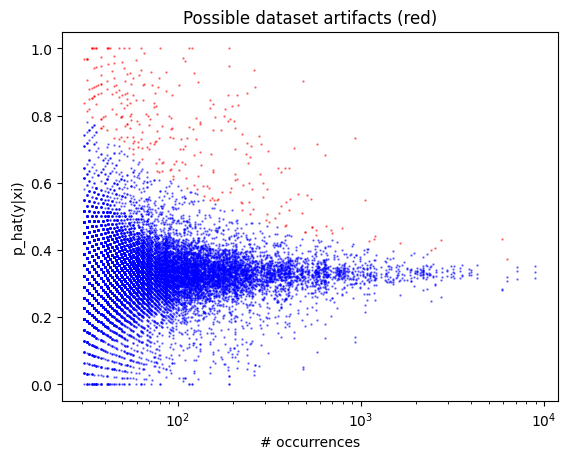

In [ ]:
# Load and split NLI data
nli_path = '/content/eval_output_snli/eval_predictions.jsonl'
nli_examples = load_nli_examples(nli_path)

# To actually get data and plots
from datasets import load_dataset
#big_nli_set = load_dataset('snli', split='train') # huggingface dataset

subset = big_nli_set.shuffle(seed=42).select([i for i in range(200000)]) # 200k examples
big_nli = load_nli_examples_fromHF(subset)
# TRAIN SET is 550k examples and takes a long time, can do smaller set
# 100k examples takes a while. for shorter results try choice = small_nli
#subset = nli_examples
#big = True # nli huggingface data has diff structure
big = False # nli examples are custom class

n_gram_size = 2
# Bigrams and remove stopwords
big_ctr, e_ctr, n_ctr, c_ctr = make_counters_by_label(big_nli, big, n_gram_size, rm_stop=True)
p_hats, z_scores = get_p_hat_z_scores(big_ctr, e_ctr, n_ctr, c_ctr)
sig_z = make_plots_paper(big_ctr, e_ctr, n_ctr, c_ctr, z_scores, p_hats, plot_cutoff=30)

# Anything with z-scores above the significant level printed is likely an artifact
# Value will be in gathering the words identified w/ label artifacts
# note z_scores is a dictionary with z_scores[label][word] so should be easy to access this info

print(f'there are {len(subset)} examples')
print(f'z-score for significance: {sig_z}.\nany z-scores >= this are likely artifacts')
print(f'there are {len(big_ctr)} unique words in the dataset')
sig_z_entail = {key: value for key, value in z_scores[0].items() if value > sig_z}
sig_z_neut = {key: value for key, value in z_scores[1].items() if value > sig_z}
sig_z_contr = {key: value for key, value in z_scores[2].items() if value > sig_z}
# note the outputs below - some of these words are annotated in the plot in the paper
# more will appear if we include more data

# Get top artifacts
top_z_e = dict(sorted(z_scores[0].items(), key=lambda item: item[1], reverse=True)[:5])
top_z_n = dict(sorted(z_scores[1].items(), key=lambda item: item[1], reverse=True)[:5])
top_z_c = dict(sorted(z_scores[2].items(), key=lambda item: item[1], reverse=True)[:5])
print(f'\ntop entailment artifact words:\n{top_z_e}')
print(f'\ntop neutral artifact words:\n{top_z_n}')
print(f'\ntop contradiction artifact words:\n{top_z_c}')

items_to_write = [big_ctr, e_ctr, n_ctr, c_ctr, p_hats, z_scores]
names = ['big_ctr', 'e_ctr', 'n_ctr', 'c_ctr', 'p_hats', 'z_scores']
zip_path = '/content/snli_train_bigram_nstop.zip'
write_zip_data(items_to_write, names, zip_path)

!cp -r '/content/snli_train_bigram_nstop.zip' '/content/drive/MyDrive/NLP/Final'

##### GOOD ONE! This one keeps the first words (if it is a stop word) if the len of sentence would be zero when removing it. Also keep genders

Downloading:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

iter:  10000   10.0 % complete
iter:  20000   20.0 % complete
iter:  30000   30.0 % complete
iter:  40000   40.0 % complete
iter:  50000   50.0 % complete
iter:  60000   60.0 % complete
iter:  70000   70.0 % complete
iter:  80000   80.0 % complete
iter:  90000   90.0 % complete
iter:  100000   100.0 % complete
significant z is:  5.526384225449986
there are 100000 examples
z-score for significance: 5.526384225449986.
any z-scores >= this are likely artifacts
there are 305906 unique words in the dataset

top entailment artifact words:
{'people outside': 17.588667757399254, 'man outside': 12.44601244601867, 'people outdoors': 11.699403106904693, 'man outdoors': 10.937374832394612, 'dog outside': 10.565509926170153}

top neutral artifact words:
{'tall human': 14.966629547095765, 'first time': 11.041823898251593, 'his wife': 10.38106195764292, 'tall person': 10.138838820672659, 'tall humans': 10.09950493836208}

top contradiction artifact words:
{'watching tv': 17.712586324015877, 'dog slee

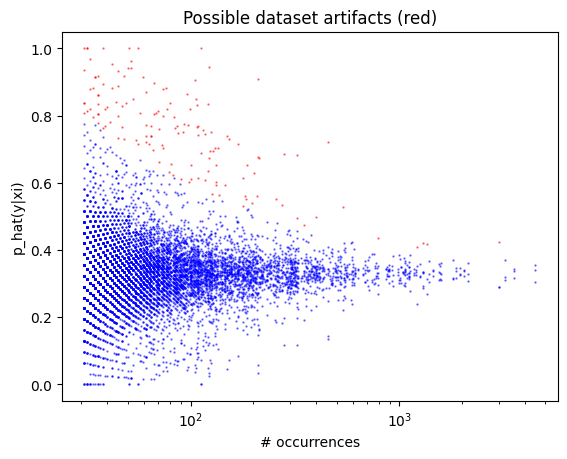

In [ ]:
# Load and split NLI data
nli_path = '/content/eval_output_snli/eval_predictions.jsonl'
nli_examples = load_nli_examples(nli_path)

# To actually get data and plots
from datasets import load_dataset
big_nli_set = load_dataset('snli', split='train') # huggingface dataset

subset = big_nli_set.shuffle(seed=42).select([i for i in range(100000)]) # 100k examples
big_nli = load_nli_examples_fromHF(subset)
# TRAIN SET is 550k examples and takes a long time, can do smaller set
# 100k examples takes a while. for shorter results try choice = small_nli
#subset = nli_examples
#big = True # nli huggingface data has diff structure
big = False # nli examples are custom class

n_gram_size = 2
# Bigrams and remove stopwords
big_ctr, e_ctr, n_ctr, c_ctr = make_counters_by_label(big_nli, big, n_gram_size, rm_stop=True, gentle_rm=True, keep_genders=True)
p_hats, z_scores = get_p_hat_z_scores(big_ctr, e_ctr, n_ctr, c_ctr)
sig_z = make_plots_paper(big_ctr, e_ctr, n_ctr, c_ctr, z_scores, p_hats, plot_cutoff=30)

# Anything with z-scores above the significant level printed is likely an artifact
# Value will be in gathering the words identified w/ label artifacts
# note z_scores is a dictionary with z_scores[label][word] so should be easy to access this info

print(f'there are {len(subset)} examples')
print(f'z-score for significance: {sig_z}.\nany z-scores >= this are likely artifacts')
print(f'there are {len(big_ctr)} unique words in the dataset')
sig_z_entail = {key: value for key, value in z_scores[0].items() if value > sig_z}
sig_z_neut = {key: value for key, value in z_scores[1].items() if value > sig_z}
sig_z_contr = {key: value for key, value in z_scores[2].items() if value > sig_z}
# note the outputs below - some of these words are annotated in the plot in the paper
# more will appear if we include more data

# Get top artifacts
top_z_e = dict(sorted(z_scores[0].items(), key=lambda item: item[1], reverse=True)[:5])
top_z_n = dict(sorted(z_scores[1].items(), key=lambda item: item[1], reverse=True)[:5])
top_z_c = dict(sorted(z_scores[2].items(), key=lambda item: item[1], reverse=True)[:5])
print(f'\ntop entailment artifact words:\n{top_z_e}')
print(f'\ntop neutral artifact words:\n{top_z_n}')
print(f'\ntop contradiction artifact words:\n{top_z_c}')

items_to_write = [big_ctr, e_ctr, n_ctr, c_ctr, p_hats, z_scores]
names = ['big_ctr', 'e_ctr', 'n_ctr', 'c_ctr', 'p_hats', 'z_scores']
zip_path = '/content/snli_train_bigram_nstop_gen.zip'
write_zip_data(items_to_write, names, zip_path)

!cp -r '/content/snli_train_bigram_nstop_gen.zip' '/content/drive/MyDrive/NLP/Final'

#### Make a second plot of this with more detail for the final report

In [ ]:
def make_plots_paper_FINAL(big_ctr, e_ctr, n_ctr, c_ctr, z_scores, p_hats, b_art_e, b_art_n, b_art_c, plot_cutoff=0):
    # Attempt to reproduce plots to ensure the method is correct
    '''
    try to make plots look like the paper to ensure results reproduced accurately
    note : looks like some kind of cutoff @ beginning for low freq words
    note : paper has log scale on x-axis, otherwise too squished
    plots unlikely artifacts in blue and likely artifacts in red
    cutoff_val is if you want to cut off data for words with small occurrences
    '''
    from scipy.stats import norm
    import random
    from matplotlib.lines import Line2D
    random.seed(34)
    # in paper they have Bonferroni correction based on size of vocab. They have 28k.
    # we have len(big_ctr) which is size of our vocab, so alpha depends on size of corpus
    # for a given regular alpha, the new significance level is alpha * (1/len(dataset))
    sig = 0.01 # change? maybe 0.05?
    alpha = sig * (1/len(big_ctr))
    # this is the alpha equivalent to 0.01 significance, but factoring in size of vocab
    # below we find z threshold to reject null hypothesis that p = 1/3
    # reject_null_z changes based on dataset!!
    reject_null_z = norm.ppf(1- alpha/2) # normal dist zscore cutoff for the alpha
    # we have 'sig' significance @ this z. anything above this z is statistically different enough
    print('significant z is: ', reject_null_z)
    p0 = 1/3
    label_sets = [e_ctr, n_ctr, c_ctr]
    label_names = [0, 1, 2]
    sm_freq_cutoff = plot_cutoff # set to zero for no cutoff - weird output with no cutoff

    for label_id in label_names:
        label_count_set = label_sets[label_id] # freq of word within label
        p_hat = p_hats[str(label_id)] # p_hat by word within label
        z_score = z_scores[str(label_id)] # z_score by word within label
        # below get only overall counts for words that appear w/ given label

        # BELOW: below_cutoff, probably not artifacts
        p_hat_b = []
        z_score_b = []
        big_ctr_b = []
        for word in big_ctr:
            if big_ctr[word] > sm_freq_cutoff and z_score[word] < reject_null_z:
                big_ctr_b.append(big_ctr[word])
                z_score_b.append(z_score[word])
                p_hat_b.append(p_hat[word])

        # BELOW: above cutoff, probably artifacts
        p_hat_a = []
        z_score_a = []
        big_ctr_a = []
        for word in big_ctr:
            if big_ctr[word] > sm_freq_cutoff and z_score[word] >= reject_null_z:
                big_ctr_a.append(big_ctr[word])
                z_score_a.append(z_score[word])
                p_hat_a.append(p_hat[word])

        # plot likely non-artifacts
        plt.scatter(big_ctr_b, p_hat_b, marker='.', color='blue', alpha=.2, s=5)
        # plot possible artifacts
        plt.scatter(big_ctr_a, p_hat_a, marker='.', color='red', alpha=.4, s=5)
        # all_words are in big_ctr for annotation later #plt.annotate(...)
        #ADD ANNOTATIONS
        if label_id == 0: # get correct artifact list
            b_art = b_art_e
            color = 'green'
        elif label_id == 1:
            b_art = b_art_n
            color = 'purple'
        elif label_id == 2:
            b_art = b_art_c
            color = 'red'

        # get some random artifacts to plot
        random_b_arts = random.sample(sorted(b_art), 8)
        print(random_b_arts)
        b_art_ctr = [big_ctr[word] for word in random_b_arts]
        b_art_phat = [p_hat[word] for word in random_b_arts]

        for i, (k, x, y) in enumerate(zip(random_b_arts, b_art_ctr, b_art_phat)):
            #if i < 7: # do max 8 examples
            plt.annotate(k, (x, y), textcoords="offset points", xytext=(0,5), ha='center', color=color,size =8)

        # Create a legend with custom lines
        legend_lines = [Line2D([], [], marker='x', markersize=5, color='green', linewidth=2, linestyle=''), # entail
                        Line2D([], [], marker='x', markersize=5, color='purple', linewidth=2, linestyle=''), # neu
                        Line2D([], [], marker='x', markersize=5, color='red', linewidth=2, linestyle=''), # contr
                        Line2D([], [], marker='.', markersize=5, color='red', linewidth=2, linestyle=''), # artifact
                        Line2D([], [], marker='.', markersize=5, color='blue', linewidth=2, linestyle='')] # not artifact

        # Add the legend with custom lines
        e, n, c = 'entail', 'neutral', 'contr'
        plt.legend(legend_lines, [e, n, c, 'artifact', 'no artifact'], title='Class and Artifacts', fontsize='small')

        plt.xlabel('# occurrences')
        plt.ylabel('p_hat(y|xi)')
        plt.title('Bigram - No Stopwords + Gender Words\nPossible Dataset Artifacts')
        plt.xscale('log') # rescale to match paper, otherwise too squished

    return reject_null_z # use for output analysis

In [ ]:
big_ctr_bnsg = load_unprocessed('/content/snli_train_bigram_nstop_gen/big_ctr.json')[0]
e_ctr_bnsg = load_unprocessed('/content/snli_train_bigram_nstop_gen/e_ctr.json')[0]
c_ctr_bnsg = load_unprocessed('/content/snli_train_bigram_nstop_gen/c_ctr.json')[0]
n_ctr_bnsg = load_unprocessed('/content/snli_train_bigram_nstop_gen/n_ctr.json')[0]
p_hats_bnsg = load_unprocessed('/content/snli_train_bigram_nstop_gen/p_hats.json')[0]
z_scores_bnsg = load_unprocessed('/content/snli_train_bigram_nstop_gen/z_scores.json')[0]

# baseline artifacts
b_art_e = {'people outside': 17.588667757399254, 'man outside': 12.44601244601867, 'people outdoors': 11.699403106904693, 'man outdoors': 10.937374832394612, 'dog outside': 10.565509926170153, 'woman outside': 10.55220888847617, 'two people': 10.34603984819992, 'men outside': 9.92955185292871, 'walking outside': 9.255869650910846, 'woman outdoors': 9.1, 'wearing clothes': 9.075625183813191, 'person outside': 9.025217197084261, 'man near': 9.018797573813227, 'people near': 8.925731045622829, 'boy outside': 8.53991993862586, 'girl outside': 8.332380897952962, 'wearing clothing': 7.905694150420948, 'playing instrument': 7.848183545407563, 'dogs outside': 7.636550360499871, 'dog outdoors': 7.528517213141738, 'person outdoors': 7.2908945169398, 'animal outside': 7.112007112010667, 'playing music': 7.0613481264300635, 'children outside': 6.740358479519649, 'people walking': 6.724197702514836, 'multiple people': 6.6996452071463715, 'near water': 6.499365987675894, 'people present': 6.453979094624195, 'people picture': 6.428037969018816, 'holding something': 6.275716324421888, 'women outside': 6.197506830096351, 'least two': 6.123724356957945, 'walking outdoors': 6.073733934116561, 'men outdoors': 6.010407640085654, 'boys outside': 5.715476066494083, 'playing sport': 5.648456717647685}
b_art_c = {'watching tv': 17.712586324015877, 'dog sleeping': 14.345476043925114, 'man sleeping': 13.3190658654408, 'driving car': 12.421180068162375, 'people sleeping': 11.263566243792502, 'sitting couch': 10.612073960544933, 'dogs sleeping': 10.583005244258363, 'man eating': 10.538451606576317, 'woman sleeping': 10.233634385069301, 'watching television': 9.946138731974115, 'watching movie': 9.76171320906937, 'sitting inside': 9.626954911578489, 'two cats': 9.609690621771016, 'video games': 9.59383482590078, 'people swimming': 9.50184438564282, 'sleeping bed': 9.481918564352732, 'man swimming': 9.413574486632834, 'playing video': 9.128709291752768, 'taking nap': 8.958129916620623, 'man driving': 8.905582852379403, 'his bed': 8.872503112166815, 'home sleeping': 8.717797887081348, 'his car': 8.6875, 'men sleeping': 8.573214099741122, 'man home': 8.538149682454625, 'dog eating': 8.510497719203704, 'swimming ocean': 8.4665478462259, 'swimming lake': 8.206750043022922, 'eating dinner': 8.187458870652156, 'nobody standing': 8.0, 'inside watching': 8.0, 'eating lunch': 7.951021946894625, 'fast asleep': 7.874007874011811, 'men swimming': 7.754763931697963, 'girl sleeping': 7.586345073811721, 'nobody sitting': 7.483314773547883, 'sleeping his': 7.454993164109749, 'playing basketball': 7.4542704445118035, 'dog asleep': 7.424621202458748, 'her bed': 7.341303483857977, 'men eating': 7.242859683401481, 'swimming beach': 7.221853807284741, 'movie theater': 7.142223997912949, 'man naked': 7.071067811865476, 'flying plane': 6.9713700231733515, 'swimming pool': 6.965001794687494, 'man running': 6.929771939280168, 'woman swimming': 6.928758352525532, 'people asleep': 6.92820323027551, 'boy sleeping': 6.869128875399653, 'naked man': 6.790997501017324, 'asleep home': 6.782329983125268, 'nobody walking': 6.782329983125268, 'man alone': 6.717514421272202, 'taking shower': 6.717514421272202, 'sleeping couch': 6.640783086353597, 'man sitting': 6.538461538461542, 'two goldfish': 6.48074069840786, 'goldfish riding': 6.48074069840786, 'bikes giant': 6.48074069840786, 'pile mashed': 6.48074069840786, 'home watching': 6.48074069840786, 'sitting home': 6.3790522565901355, 'people driving': 6.363961030678927, 'couch watching': 6.3400041146605775, 'sleeping home': 6.324555320336759, 'woman driving': 6.291669602178639, 'dog sitting': 6.231026245603086, 'people running': 6.180982563844156, 'giant pile': 6.180982563844156, 'reading book': 6.177082381612375, 'playing piano': 6.128258770283412, 'woman sitting': 6.123004481387646, 'mashed potatoes': 6.0621778264910695, 'grass cat': 6.0, 'cat running': 6.0, 'woman asleep': 5.969005969008953, 'dogs sitting': 5.969005969008953, 'hot dog': 5.908391567007972, 'cat playing': 5.879747322073334, 'his house': 5.874269508076824, 'nobody playing': 5.830951894845301, 'eating pizza': 5.817538139110048, 'his room': 5.774612874137438, 'women sleeping': 5.728715546977508, 'playing chess': 5.692099788303082, 'running around': 5.642857142857143, 'laying beach': 5.620685479828764, 'man watching': 5.602274079365916, 'man asleep': 5.5901699437494745, 'woman running': 5.584356665729611, 'sits couch': 5.54700196225229, 'empty field': 5.54700196225229, 'people sitting': 5.531259132078962}
b_art_n ={'tall human': 14.966629547095765, 'first time': 11.041823898251593, 'his wife': 10.38106195764292, 'tall person': 10.138838820672659, 'tall humans': 10.09950493836208, 'playing fetch': 9.565889922009347, 'getting ready': 9.520339884078716, 'sad man': 9.31551641906374, 'waiting his': 9.189864430307049, 'waiting her': 8.536057972758018, 'his friends': 8.509008509012764, 'his owner': 8.477912478906585, 'his family': 8.31768137941168, 'man trying': 7.98059798098352, 'his favorite': 7.964544071329567, 'man waiting': 7.93828655583955, 'his new': 7.475128829686362, 'best friends': 7.2908945169398, 'two brothers': 7.2199487238115525, 'his friend': 7.071067811865475, 'her husband': 6.928758352525532, 'waiting bus': 6.824896183883832, 'men friends': 6.782329983125268, 'trying get': 6.6486150161257696, 'way work': 6.646940512883967, 'man professional': 6.646803743153547, 'walking work': 6.596400533624379, 'two friends': 6.560590932489133, 'woman going': 6.4142698058981855, 'championship game': 6.3790522565901355, 'man going': 6.376649130643646, 'his son': 6.29049046341144, 'his girlfriend': 6.2667956144051224, 'tall people': 6.0621778264910695, 'birthday party': 6.047431568147636, 'two sad': 6.017830648521584, 'waiting someone': 6.010407640085654, 'girl waiting': 5.879747322073334, 'woman waiting': 5.868986283848344, 'her way': 5.75, 'husband wife': 5.699587188353824, 'people going': 5.678747677303663, 'friends house': 5.677749739576687, 'going work': 5.65685424949238, 'brother sister': 5.64617661296807, 'dog playing': 5.639733172578262, 'way home': 5.588005588008381, 'her new': 5.554920598635308, 'his way': 5.5441685470455155}
# retraining artifacts
r_art_e = {'people outside': 18.100793067637102, 'man outside': 14.692196131882406, 'people outdoors': 12.82360773161115, 'two people': 12.67586490226242, 'walking outside': 11.709559020522072, 'woman outside': 11.086437250491743, 'man near': 11.008381625807557, 'dog outside': 10.927278041919013, 'man outdoors': 10.084119876529163, 'men outside': 9.519716382329886, 'person outside': 9.448947491422109, 'surf board': 8.538149682454625, 'dogs outside': 8.013876853447538, 'woman outdoors': 7.9796252170544415, 'riding wave': 7.931367688273783, 'holding tennis': 7.775419143502353, 'people near': 7.66921323756018, 'wearing clothes': 7.652514332541697, 'playing instrument': 7.649609723745377, 'wet suit': 7.49300749301124, 'skate board': 7.25, 'people picture': 7.242859683401481, 'tennis racquet': 7.207353602116796, 'dog outdoors': 7.201190377787747, 'men outdoors': 7.133345315110954, 'boy outside': 7.117410641980364, 'board riding': 7.082422910679245, 'least two': 6.9713700231733515, 'children outside': 6.895177899145864, 'person playing': 6.8315777493529675, 'people present': 6.827934508705572, 'walking outdoors': 6.822422923379534, 'girl outside': 6.819090848492928, 'men near': 6.731006731010095, 'person outdoors': 6.646940512883967, 'woman picture': 6.6332495807108005, 'making music': 6.596400533624379, 'man picture': 6.5, 'child outdoors': 6.49519052838329, 'tennis court': 6.357755313912211, 'people playing': 6.33107212301393, 'pizza box': 6.324555320336759, 'two animals': 6.1611248534224226, 'person near': 6.125, 'least one': 6.123724356957945, 'playing music': 6.086270034005167, 'multiple people': 6.06217782649107, 'dogs outdoors': 6.0621778264910695, 'hill skis': 6.0621778264910695, 'riding skateboard': 6.040404496926221, 'boy outdoors': 5.963027109421213, 'near water': 5.959141182784952, 'man touching': 5.8502136713115025, 'wearing clothing': 5.75, 'cell phone': 5.7076197382904805, 'animal outdoors': 5.677749739576687, 'video golf': 5.656854249492381, 'golf gamer': 5.656854249492381, 'small kitchenette': 5.656854249492381, 'kitchenette area': 5.656854249492381, 'holding cell': 5.656854249492381, 'three almost': 5.656854249492381, 'trick smoking': 5.656854249492381, 'man standing': 5.570686647869566, 'wave woman': 5.54700196225229, 'talking cell': 5.54700196225229, 'kite beach': 5.54700196225229, 'people walking': 5.529123125021325, 'woman holding': 5.528757923720706}
r_art_c = {'watching tv': 17.641057126819927, 'man sleeping': 13.98258860479379, 'dog sleeping': 13.382142233933651, 'driving car': 11.403946685248926, 'man swimming': 10.81153610626627, 'swimming ocean': 10.80865038184338, 'sitting couch': 10.773100829962432, 'people sleeping': 10.552897060221726, 'watching movie': 10.475698532329945, 'woman sleeping': 10.266801668233654, 'watching television': 10.138838820672659, 'sleeping bed': 9.72271824131503, 'dogs sleeping': 9.491772753284813, 'two cats': 9.273618495495706, 'his bed': 9.243392153720553, 'eating dinner': 9.126883367283709, 'man home': 9.057894597833126, 'man eating': 8.48202284472646, 'movie theater': 8.317239361004065, 'video games': 8.271389716998424, 'home sleeping': 8.246211251235321, 'sleeping his': 8.215838362577491, 'girl sleeping': 8.094611001939949, 'woman asleep': 7.855844048495725, 'nobody sitting': 7.615773105863909, 'boy sleeping': 7.572378034072855, 'sitting home': 7.518604376126323, 'asleep home': 7.483314773547883, 'men sleeping': 7.4022616990261545, 'woman driving': 7.398912247014718, 'taking shower': 7.348469228349535, 'taking nap': 7.278487339602639, 'dog eating': 7.267220926874317, 'sitting inside': 7.259032193556989, 'sleeping couch': 7.256297000112808, 'eating lunch': 7.246954437820982, 'people swimming': 7.245688373094719, 'man driving': 7.195376119425586, 'swimming lake': 7.1701079323252905, 'man sitting': 7.125736411276039, 'playing basketball': 7.11200711201067, 'inside watching': 7.082422910679245, 'swimming pool': 7.0136644745597945, 'man watching': 6.975521108622788, 'boy sitting': 6.9402209378856705, 'man naked': 6.875, 'man eats': 6.719840027857806, 'living room': 6.686121846938828, 'dogs sitting': 6.68153104781061, 'men swimming': 6.6530562822462915, 'man inside': 6.5991201759608975, 'dog asleep': 6.49519052838329, 'man dancing': 6.482669203345179, 'eating pizza': 6.462442099913688, 'home watching': 6.3400041146605775, 'alone his': 6.324555320336759, 'flying plane': 6.222539674441618, 'dog eats': 6.180982563844156, 'nobody standing': 6.164414002968977, 'her bed': 6.123724356957945, 'women sleeping': 6.017830648521584, 'sitting alone': 6.00832755431992, 'nobody playing': 6.0, 'two goldfish': 6.0, 'man running': 5.900000000000001, 'women swimming': 5.897678246195884, 'nobody walking': 5.830951894845301, 'dogs asleep': 5.830951894845301, 'fast asleep': 5.830951894845301, 'woman naked': 5.830951894845301, 'goldfish riding': 5.830951894845301, 'pile mashed': 5.830951894845301, 'woman swimming': 5.751086853804245, 'people running': 5.728715546977511, 'men asleep': 5.677749739576687, 'running around': 5.67113434031344, 'dog sitting': 5.670672071203768, 'sleeping home': 5.656854249492381, 'cats playing': 5.656854249492381, 'water cat': 5.656854249492381, 'bikes giant': 5.656854249492381, 'playing cards': 5.63382640840131, 'woman alone': 5.554920598635308, 'cat playing': 5.554920598635308}
r_art_n ={'tall human': 14.001591140132808, 'man trying': 11.59321796149381, 'first time': 10.922184655418475, 'tall humans': 10.866120772619883, 'sad man': 10.59671281957972, 'getting ready': 9.367549740582783, 'tall person': 9.165638470473759, 'his friends': 9.034452032603403, 'his wife': 8.925747336623493, 'man waiting': 8.835698343503546, 'his favorite': 8.329288635911706, 'her husband': 8.244345381486074, 'waiting her': 8.206750043022922, 'best friends': 7.938041320124254, 'playing fetch': 7.8383671769061705, 'woman waiting': 7.248824356090755, 'his family': 7.23355544143572, 'waiting his': 7.06296978392763, 'waiting someone': 7.042283010501637, 'man going': 6.944258583371394, 'trying get': 6.861993625888846, 'sad woman': 6.827934508705572, 'championship game': 6.6332495807108005, 'woman going': 6.555593523977284, 'his owner': 6.4440223252882625, 'his new': 6.429910574805843, 'going work': 6.3790522565901355, 'men friends': 6.3400041146605775, 'sad men': 6.324555320336759, 'trying win': 6.280639184941972, 'tall people': 6.280639184941972, 'his friend': 6.263754096755027, 'trying catch': 6.231026245603086, 'her favorite': 6.196773353931868, 'two sad': 6.164414002968977, 'first place': 6.164414002968977, 'walking work': 6.125, 'walking home': 6.123724356957945, 'his way': 6.123724356957945, 'two friends': 6.081118318204309, 'his parents': 6.06217782649107, 'his girlfriend': 6.047431568147636, 'married couple': 5.913164739915446, 'favorite song': 5.8502136713115025, 'his job': 5.812381937190963, 'his son': 5.780059766913393, 'man competing': 5.75, 'her family': 5.742439355892021, 'dog playing': 5.709971417170638, 'home school': 5.677749739576687, 'sad girl': 5.677749739576687, 'two brothers': 5.65685424949238, 'waiting bus': 5.543218625245871, 'trying find': 5.539117094069972}





significant z is:  5.526384225449986
['woman outdoors', 'people walking', 'boy outside', 'men outside', 'women outside', 'two people', 'man outside', 'man outdoors']
['dog playing', 'man waiting', 'his owner', 'his way', 'friends house', 'two brothers', 'tall human', 'going work']
['driving car', 'man driving', 'mashed potatoes', 'swimming pool', 'asleep home', 'giant pile', 'sits couch', 'dogs sleeping']


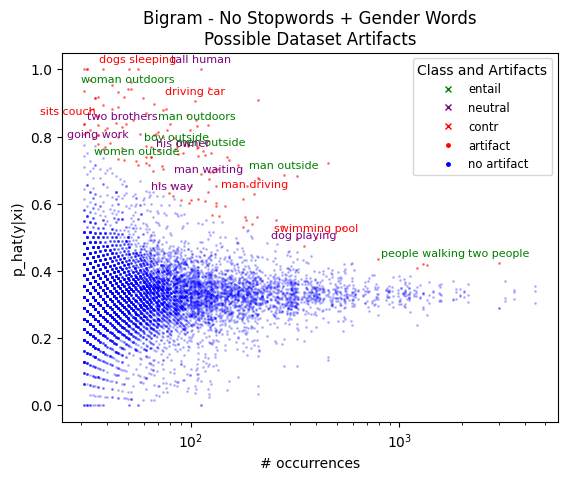

In [ ]:
sig_bnsg = make_plots_paper_FINAL(big_ctr_bnsg, e_ctr_bnsg, n_ctr_bnsg, c_ctr_bnsg, z_scores_bnsg, p_hats_bnsg, b_art_e, b_art_n, b_art_c, plot_cutoff=30)

# SNLI + Neutral CA - DO NOT EDIT

#### Unigram (SNLI + Neutral)

iter:  10000   5.0 % complete
iter:  20000   10.0 % complete
iter:  30000   15.0 % complete
iter:  40000   20.0 % complete
iter:  50000   25.0 % complete
iter:  60000   30.0 % complete
iter:  70000   35.0 % complete
iter:  80000   40.0 % complete
iter:  90000   45.0 % complete
iter:  100000   50.0 % complete
iter:  110000   55.0 % complete
iter:  120000   60.0 % complete
iter:  130000   65.0 % complete
iter:  140000   70.0 % complete
iter:  150000   75.0 % complete
iter:  160000   80.0 % complete
iter:  170000   85.0 % complete
iter:  180000   90.0 % complete
iter:  190000   95.0 % complete
iter:  200000   100.0 % complete
significant z is:  5.079500003712604


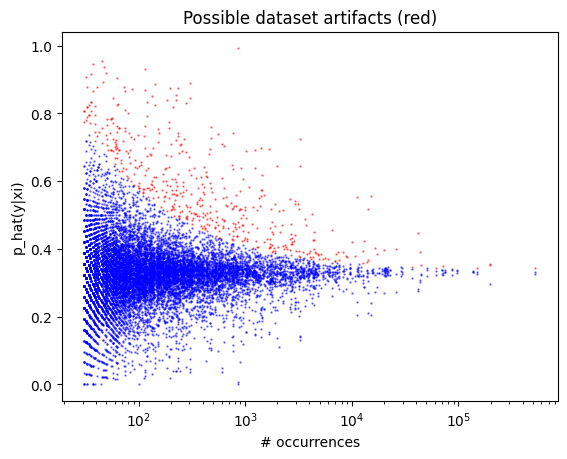

In [ ]:
# load the snli train set augmented w/ neturals
sns = load_unprocessed('/content/snli_train_with_neutral.jsonl')[0]
snli_train_neutral = load_nli_examples_fromHF(sns)
import random
random.seed(42)
size = 200000 # 200k
subset = random.sample(snli_train_neutral, size)
big = False # nli examples are custom class

n_gram_size = 1 # unigram
big_ctr, e_ctr, n_ctr, c_ctr = make_counters_by_label(subset, big, n_gram_size)
p_hats, z_scores = get_p_hat_z_scores(big_ctr, e_ctr, n_ctr, c_ctr)
sig_z = make_plots_paper(big_ctr, e_ctr, n_ctr, c_ctr, z_scores, p_hats, plot_cutoff=30)

# Anything with z-scores above the significant level printed is likely an artifact
# Value will be in gathering the words identified w/ label artifacts
# note z_scores is a dictionary with z_scores[label][word] so should be easy to access this info

In [ ]:
sig = sig_z
print(f'There are {len(subset)} examples')
print(f'Z-score for significance: {sig_z}.\nAny z-scores >= this are likely artifacts')
print(f'There are {len(big_ctr)} unique words in the dataset')
sig_z_entail = {key: value for key, value in z_scores[0].items() if value > sig_z}
sig_z_neut = {key: value for key, value in z_scores[1].items() if value > sig_z}
sig_z_contr = {key: value for key, value in z_scores[2].items() if value > sig_z}

# Get top artifacts
top_z_e = dict(sorted(z_scores[0].items(), key=lambda item: item[1], reverse=True)[:5])
top_z_n = dict(sorted(z_scores[1].items(), key=lambda item: item[1], reverse=True)[:5])
top_z_c = dict(sorted(z_scores[2].items(), key=lambda item: item[1], reverse=True)[:5])
print(f'\ntop entailment artifact words:\n{top_z_e}')
print(f'\ntop neutral artifact words:\n{top_z_n}')
print(f'\ntop contradiction artifact words:\n{top_z_c}')

items_to_write = [big_ctr, e_ctr, n_ctr, c_ctr, p_hats, z_scores]
names = ['big_ctr', 'e_ctr', 'n_ctr', 'c_ctr', 'p_hats', 'z_scores']
zip_path = '/content/re_snli_train_unigram.zip'
write_zip_data(items_to_write, names, zip_path)
!cp -r '/content/re_snli_train_unigram.zip' '/content/drive/MyDrive/NLP/Final'

There are 200000 examples
Z-score for significance: 5.079500003712604.
Any z-scores >= this are likely artifacts
There are 26425 unique words in the dataset

top entailment artifact words:
{'there': 49.294318001510504, 'outside': 46.60711438606393, 'outdoors': 37.67614123565498, 'people': 25.442635269340514, 'person': 21.977000107020096}

top neutral artifact words:
{'for': 58.091983166076226, 'to': 48.518098178366984, 'friends': 29.566271567690336, 'about': 23.91880819910409, 'waiting': 23.522554388367745}

top contradiction artifact words:
{'sleeping': 47.509606751484085, 'nobody': 40.9665277433765, 'no': 31.539363912306264, 'cat': 29.1160043246571, 'alone': 26.553282834110973}
zip creation done!


#### Bigram w/ stopwords removed but keep genders (SNLI + Neutral)

iter:  10000   10.0 % complete
iter:  20000   20.0 % complete
iter:  30000   30.0 % complete
iter:  40000   40.0 % complete
iter:  50000   50.0 % complete
iter:  60000   60.0 % complete
iter:  70000   70.0 % complete
iter:  80000   80.0 % complete
iter:  90000   90.0 % complete
iter:  100000   100.0 % complete
significant z is:  5.525902700248001
there are 100000 examples
z-score for significance: 5.525902700248001.
any z-scores >= this are likely artifacts
there are 305068 unique words in the dataset

top entailment artifact words:
{'people outside': 18.100793067637102, 'man outside': 14.692196131882406, 'people outdoors': 12.82360773161115, 'two people': 12.67586490226242, 'walking outside': 11.709559020522072}

top neutral artifact words:
{'tall human': 14.001591140132808, 'man trying': 11.59321796149381, 'first time': 10.922184655418475, 'tall humans': 10.866120772619883, 'sad man': 10.59671281957972}

top contradiction artifact words:
{'watching tv': 17.641057126819927, 'man sleep

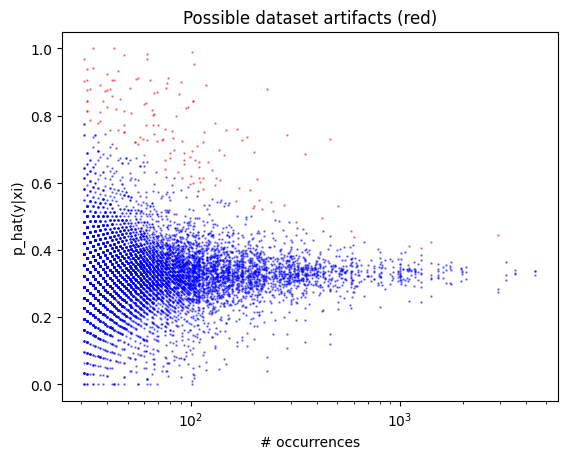

In [ ]:
# load the snli train set augmented w/ neturals
sns = load_unprocessed('/content/snli_train_with_neutral.jsonl')[0]
snli_train_neutral = load_nli_examples_fromHF(sns)
import random
random.seed(42)
size = 100000 # 100k
subset = random.sample(snli_train_neutral, size)
big = False # nli examples are custom class

n_gram_size = 2
# Bigrams and remove stopwords
big_ctr, e_ctr, n_ctr, c_ctr = make_counters_by_label(subset, big, n_gram_size, rm_stop=True, gentle_rm=True, keep_genders=True)
p_hats, z_scores = get_p_hat_z_scores(big_ctr, e_ctr, n_ctr, c_ctr)
sig_z = make_plots_paper(big_ctr, e_ctr, n_ctr, c_ctr, z_scores, p_hats, plot_cutoff=30)

# Anything with z-scores above the significant level printed is likely an artifact
# Value will be in gathering the words identified w/ label artifacts
# note z_scores is a dictionary with z_scores[label][word] so should be easy to access this info

print(f'there are {len(subset)} examples')
print(f'z-score for significance: {sig_z}.\nany z-scores >= this are likely artifacts')
print(f'there are {len(big_ctr)} unique words in the dataset')
sig_z_entail = {key: value for key, value in z_scores[0].items() if value > sig_z}
sig_z_neut = {key: value for key, value in z_scores[1].items() if value > sig_z}
sig_z_contr = {key: value for key, value in z_scores[2].items() if value > sig_z}
# note the outputs below - some of these words are annotated in the plot in the paper
# more will appear if we include more data

# Get top artifacts
top_z_e = dict(sorted(z_scores[0].items(), key=lambda item: item[1], reverse=True)[:5])
top_z_n = dict(sorted(z_scores[1].items(), key=lambda item: item[1], reverse=True)[:5])
top_z_c = dict(sorted(z_scores[2].items(), key=lambda item: item[1], reverse=True)[:5])
print(f'\ntop entailment artifact words:\n{top_z_e}')
print(f'\ntop neutral artifact words:\n{top_z_n}')
print(f'\ntop contradiction artifact words:\n{top_z_c}')

items_to_write = [big_ctr, e_ctr, n_ctr, c_ctr, p_hats, z_scores]
names = ['big_ctr', 'e_ctr', 'n_ctr', 'c_ctr', 'p_hats', 'z_scores']
zip_path = '/content/re_snli_train_bigram_nstop_gen.zip'
write_zip_data(items_to_write, names, zip_path)

!cp -r '/content/re_snli_train_bigram_nstop_gen.zip' '/content/drive/MyDrive/NLP/Final'

# Competency Results Analysis

## Gender Bias Dataset Review

### To explore gender bias dataset

In [ ]:
class NLIExampleNP:
    '''
    similar to NLIExample above, but without the predictions
    '''
    def __init__(self, premise: str, hypoth: str, label: int):
        self.premise = premise # background text
        self.hypoth = hypoth
        self.label = label # list of possible answers

    def __repr__(self):
        return repr("hypothesis = " + self.hypoth + "\npremise = " + self.premise +
                    "\nlabel=" + str(self.label))

def load_nli_nopred(path):
    '''
    load data and get list of objs for functions - no prediction info
    '''
    with open(path, 'r') as file:
        nli_examples = []
        for line in file:
            dct = json.loads(line)
            nli = NLIExampleNP(dct['premise'], dct['hypothesis'], dct['label'])
            nli_examples.append(nli)
    return nli_examples

In [ ]:
# load train data
!cp -r '/content/drive/MyDrive/NLP/Final/competency_set.zip' '/content'
!unzip competency_set.zip -d '/content/c_set'

# get list of occupational nli examples
import os
train_path = '/content/c_set/competency_set/train'
files = os.listdir(train_path)
train_json_files = [file for file in files if file.endswith('.json')]

dev_path = '/content/c_set/competency_set/train'
files = os.listdir(train_path)
dev_json_files = [file for file in files if file.endswith('.json')]

json_files = train_json_files# + dev_json_files
occ_exs = []
for f in json_files:
    path = '/content/c_set/competency_set/train/'+f
    test = load_nli_nopred(path)
    occ_exs.extend(test)

In [ ]:
print(len(occ_exs))
occ_exs[0]

330000


'hypothesis = a young man holding a large decorated cake.\npremise = a young nanny holding a large decorated cake.\nlabel=2'

### Bigram

significant z is:  4.805773343920074


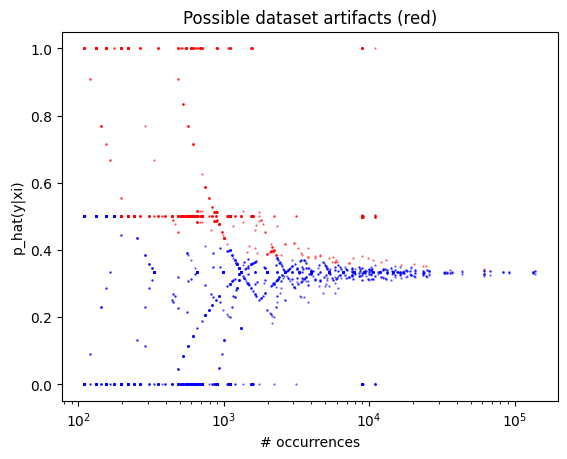

In [ ]:
# Run competency analysis with occupational dataset and bigrams
big = False
n_gram_size = 2
big_ctr, e_ctr, n_ctr, c_ctr = make_counters_by_label(occ_exs, big, n_gram_size)
p_hats, z_scores = get_p_hat_z_scores(big_ctr, e_ctr, n_ctr, c_ctr)
sig_z = make_plots_paper(big_ctr, e_ctr, n_ctr, c_ctr, z_scores, p_hats, plot_cutoff=100)

# Anything with z-scores above the significant level printed is likely an artifact
# Value will be in gathering the words identified w/ label artifacts
# note z_scores is a dictionary with z_scores[label][word] so should be easy to access this info

#### Nearly half of these are artifacts, there is a lot of bias going on

In [ ]:
print(f'There are {len(occ_exs)} examples')
print(f'Z-score for significance: {sig_z}.\nAny z-scores >= this are likely artifacts')
print(f'There are {len(big_ctr)} unique words in the dataset')
sig_z_entail = {key: value for key, value in z_scores[0].items() if value > sig_z}
sig_z_neut = {key: value for key, value in z_scores[1].items() if value > sig_z}
sig_z_contr = {key: value for key, value in z_scores[2].items() if value > sig_z}
# note the outputs below - some of these words are annotated in the plot in the paper
# more will appear if we include more data

# Get top artifacts
top_z_e = dict(sorted(z_scores[0].items(), key=lambda item: item[1], reverse=True)[:5])
top_z_n = dict(sorted(z_scores[1].items(), key=lambda item: item[1], reverse=True)[:5])
top_z_c = dict(sorted(z_scores[2].items(), key=lambda item: item[1], reverse=True)[:5])
print(f'\ntop entailment artifact words:\n{top_z_e}')
print(f'\ntop neutral artifact words:\n{top_z_n}')
print(f'\ntop contradiction artifact words:\n{top_z_c}')

There are 330000 examples
Z-score for significance: 4.805773343920074.
Any z-scores >= this are likely artifacts
There are 6487 unique words in the dataset

top entailment artifact words:
{'interior designer': 37.74845029931693, 'registered nurse': 37.74845029931693, 'investment banker': 36.858506480865444, 'disc jockey': 36.858506480865444, 'the interior': 34.06965605072399}

top neutral artifact words:
{'associate professor': 148.32396974191326, 'the adventurer': 133.9850737955538, 'the salesman': 133.9850737955538, 'the proprietor': 133.82077566656085, 'the principal': 133.82077566656085}

top contradiction artifact words:
{'investment banker': 37.303478390091186, 'disc jockey': 37.303478390091186, 'interior designer': 36.41353457163971, 'registered nurse': 36.41353457163971, 'the investment': 33.78328748726852}


In [ ]:
items_to_write = [big_ctr, e_ctr, n_ctr, c_ctr, p_hats, z_scores]
names = ['big_ctr', 'e_ctr', 'n_ctr', 'c_ctr', 'p_hats', 'z_scores']
zip_path = '/content/c_set/dev_and_train_bigram_results.zip'
write_zip_data(items_to_write, names, zip_path)

zip creation done!


### Trigram

significant z is:  4.997207104900764


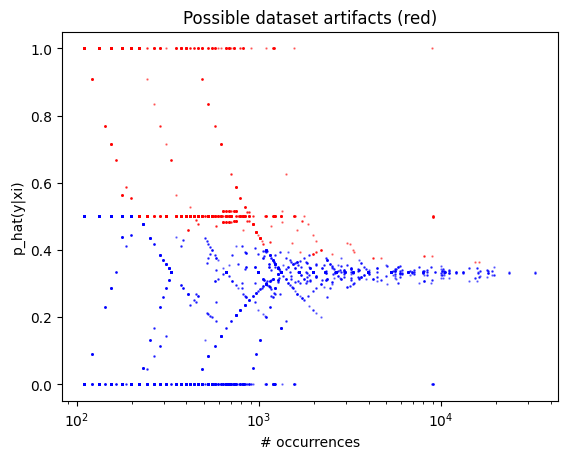

In [ ]:
# Using occupational dataset, run competency analysis with trigrams
big = False
n_gram_size = 3
big_ctr, e_ctr, n_ctr, c_ctr = make_counters_by_label(occ_exs, big, n_gram_size)
p_hats, z_scores = get_p_hat_z_scores(big_ctr, e_ctr, n_ctr, c_ctr)
sig_z = make_plots_paper(big_ctr, e_ctr, n_ctr, c_ctr, z_scores, p_hats, plot_cutoff=100)

# Anything with z-scores above the significant level printed is likely an artifact
# Value will be in gathering the words identified w/ label artifacts
# note z_scores is a dictionary with z_scores[label][word] so should be easy to access this info

In [ ]:
print(f'There are {len(occ_exs)} examples')
print(f'Z-score for significance: {sig_z}.\nAny z-scores >= this are likely artifacts')
print(f'There are {len(big_ctr)} unique words in the dataset')
sig_z_entail = {key: value for key, value in z_scores[0].items() if value > sig_z}
sig_z_neut = {key: value for key, value in z_scores[1].items() if value > sig_z}
sig_z_contr = {key: value for key, value in z_scores[2].items() if value > sig_z}
# note the outputs below - some of these words are annotated in the plot in the paper
# more will appear if we include more data

# Get top artifacts
top_z_e = dict(sorted(z_scores[0].items(), key=lambda item: item[1], reverse=True)[:5])
top_z_n = dict(sorted(z_scores[1].items(), key=lambda item: item[1], reverse=True)[:5])
top_z_c = dict(sorted(z_scores[2].items(), key=lambda item: item[1], reverse=True)[:5])
print(f'\ntop entailment artifact words:\n{top_z_e}')
print(f'\ntop neutral artifact words:\n{top_z_n}')
print(f'\ntop contradiction artifact words:\n{top_z_c}')

There are 330000 examples
Z-score for significance: 4.997207104900764.
Any z-scores >= this are likely artifacts
There are 17192 unique words in the dataset

top entailment artifact words:
{'the interior designer': 34.06965605072399, 'the registered nurse': 34.029282299068996, 'the investment banker': 33.291297863667516, 'the disc jockey': 33.24997235735251, 'nurse holding a': 14.225784717184224}

top neutral artifact words:
{'the associate professor': 133.65627557282897, 'associate professor is': 55.89275444992849, 'the adventurer is': 49.193495504995376, 'the principal is': 49.193495504995376, 'the accountant is': 49.193495504995376}

top contradiction artifact words:
{'the investment banker': 33.78328748726852, 'the disc jockey': 33.7425645404244, 'the interior designer': 33.08687751079926, 'the registered nurse': 33.04530305186701, 'chair the man': 14.07124727947029}


In [ ]:
items_to_write = [big_ctr, e_ctr, n_ctr, c_ctr, p_hats, z_scores]
names = ['big_ctr', 'e_ctr', 'n_ctr', 'c_ctr', 'p_hats', 'z_scores']
zip_path = '/content/c_set/dev_and_train_trigram_results.zip'
write_zip_data(items_to_write, names, zip_path)

zip creation done!


### Occupational data anlaysis

In [ ]:
occup_d = {
    "female-stereo": [
        "caretaker",
        "dancer",
        "hairdresser",
        "housekeeper",
        "interior designer",
        "librarian",
        "nanny",
        "nurse",
        "receptionist",
        "registered nurse",
        "secretary",
        "stylist",
        "teacher"
    ],
    "male-stereo": [
        "ambassador",
        "archaeologist",
        "architect",
        "assassin",
        "astronaut",
        "athlete",
        "athletic director",
        "ballplayer",
        "banker",
        "bodyguard",
        "boss",
        "boxer",
        "butcher",
        "captain",
        "carpenter",
        "chancellor",
        "coach",
        "colonel",
        "commander",
        "commissioner",
        "conductor",
        "constable",
        "cop",
        "custodian",
        "dean",
        "dentist",
        "deputy",
        "director",
        "disc jockey",
        "doctor",
        "drummer",
        "economics professor",
        "electrician",
        "farmer",
        "fighter pilot",
        "firefighter",
        "gangster",
        "industrialist",
        "investment banker",
        "janitor",
        "judge",
        "laborer",
        "lawmaker",
        "lieutenant",
        "lifeguard",
        "magician",
        "magistrate",
        "major leaguer",
        "manager",
        "marshal",
        "mathematician",
        "mechanic",
        "minister",
        "mobster",
        "neurologist",
        "neurosurgeon",
        "officer",
        "parliamentarian",
        "pastor",
        "philosopher",
        "physicist",
        "plumber",
        "preacher",
        "president",
        "prisoner",
        "programmer",
        "ranger",
        "sailor",
        "scholar",
        "senator",
        "sergeant",
        "sheriff deputy",
        "skipper",
        "soldier",
        "sportswriter",
        "superintendent",
        "surgeon",
        "taxi driver",
        "technician",
        "trader",
        "trucker",
        "tycoon",
        "vice chancellor",
        "warden",
        "warrior",
        "welder",
        "wrestler"
    ],
    "neutral": [
        "accountant",
        "adjunct professor",
        "administrator",
        "adventurer",
        "advocate",
        "aide",
        "alderman",
        "analyst",
        "anthropologist",
        "archbishop",
        "artist",
        "artiste",
        "assistant professor",
        "associate dean",
        "associate professor",
        "astronomer",
        "author",
        "baker",
        "ballerina",
        "barber",
        "barrister",
        "bartender",
        "biologist",
        "bishop",
        "bookkeeper",
        "broadcaster",
        "broker",
        "bureaucrat",
        "businessman",
        "butler",
        "cameraman",
        "campaigner",
        "cardiologist",
        "cartoonist",
        "cellist",
        "chef",
        "chemist",
        "choreographer",
        "cinematographer",
        "civil servant",
        "cleric",
        "clerk",
        "collector",
        "columnist",
        "comedian",
        "commentator",
        "composer",
        "consultant",
        "correspondent",
        "councilor",
        "counselor",
        "critic",
        "curator",
        "dermatologist",
        "detective",
        "diplomat",
        "doctoral student",
        "economist",
        "editor",
        "educator",
        "employee",
        "entertainer",
        "entrepreneur",
        "environmentalist",
        "envoy",
        "epidemiologist",
        "evangelist",
        "fashion designer",
        "filmmaker",
        "financier",
        "fisherman",
        "footballer",
        "foreman",
        "freelance writer",
        "gardener",
        "geologist",
        "goalkeeper",
        "graphic designer",
        "guidance counselor",
        "guitarist",
        "handyman",
        "historian",
        "hitman",
        "illustrator",
        "infielder",
        "inspector",
        "instructor",
        "inventor",
        "investigator",
        "jeweler",
        "journalist",
        "jurist",
        "landlord",
        "lawyer",
        "lecturer",
        "lyricist",
        "marksman",
        "mediator",
        "medic",
        "midfielder",
        "missionary",
        "musician",
        "narrator",
        "naturalist",
        "negotiator",
        "novelist",
        "organist",
        "painter",
        "paralegal",
        "parishioner",
        "pathologist",
        "patrolman",
        "pediatrician",
        "performer",
        "pharmacist",
        "photographer",
        "photojournalist",
        "pianist",
        "planner",
        "plastic surgeon",
        "playwright",
        "poet",
        "politician",
        "pollster",
        "priest",
        "principal",
        "professor",
        "professor emeritus",
        "promoter",
        "proprietor",
        "prosecutor",
        "protester",
        "provost",
        "psychiatrist",
        "psychologist",
        "publicist",
        "radiologist",
        "realtor",
        "researcher",
        "restaurateur",
        "saint",
        "salesman",
        "saxophonist",
        "scientist",
        "screenwriter",
        "sculptor",
        "servant",
        "serviceman",
        "shopkeeper",
        "singer",
        "singer songwriter",
        "socialite",
        "sociologist",
        "solicitor",
        "solicitor general",
        "soloist",
        "stockbroker",
        "strategist",
        "student",
        "substitute",
        "surveyor",
        "swimmer",
        "therapist",
        "treasurer",
        "trooper",
        "trumpeter",
        "tutor",
        "undersecretary",
        "understudy",
        "violinist",
        "writer"
    ]
}

In [ ]:
fm_occ = occup_d['female-stereo']
fm_occ

['caretaker',
 'dancer',
 'hairdresser',
 'housekeeper',
 'interior designer',
 'librarian',
 'nanny',
 'nurse',
 'receptionist',
 'registered nurse',
 'secretary',
 'stylist',
 'teacher']

In [ ]:
m_occ = occup_d['male-stereo']
m_occ

['ambassador',
 'archaeologist',
 'architect',
 'assassin',
 'astronaut',
 'athlete',
 'athletic director',
 'ballplayer',
 'banker',
 'bodyguard',
 'boss',
 'boxer',
 'butcher',
 'captain',
 'carpenter',
 'chancellor',
 'coach',
 'colonel',
 'commander',
 'commissioner',
 'conductor',
 'constable',
 'cop',
 'custodian',
 'dean',
 'dentist',
 'deputy',
 'director',
 'disc jockey',
 'doctor',
 'drummer',
 'economics professor',
 'electrician',
 'farmer',
 'fighter pilot',
 'firefighter',
 'gangster',
 'industrialist',
 'investment banker',
 'janitor',
 'judge',
 'laborer',
 'lawmaker',
 'lieutenant',
 'lifeguard',
 'magician',
 'magistrate',
 'major leaguer',
 'manager',
 'marshal',
 'mathematician',
 'mechanic',
 'minister',
 'mobster',
 'neurologist',
 'neurosurgeon',
 'officer',
 'parliamentarian',
 'pastor',
 'philosopher',
 'physicist',
 'plumber',
 'preacher',
 'president',
 'prisoner',
 'programmer',
 'ranger',
 'sailor',
 'scholar',
 'senator',
 'sergeant',
 'sheriff deputy',
 '

In [ ]:
fm_zs

{'teachers': -2.6816952402728624,
 'dancer': -1.0182385849843436,
 'teacher': -2.6945322788344304,
 'dancers': -1.178320047302191,
 'nurse': -3.022560101175391,
 'housekeeper': 0.0,
 'nurses': -1.6813456149534145,
 'designer': -0.8660254037844384,
 'nanny': 0.2132007163556106,
 'breakdancer': 1.3970013970020954,
 'interiors': 0.5,
 'interior': 0.0,
 'registered': -0.3535533905932737,
 'librarian': 0.46291004988627565,
 'nursery': -0.6488856845230501,
 'hairstylist': -1.224744871391589,
 'receptionist': -0.9999999999999999,
 'breakdancers': -0.8944271909999156,
 'secretary': -1.5811388300841895,
 'hairdresser': -0.49999999999999983,
 'stylist': -0.49999999999999967,
 'nursed': -0.7071067811865475,
 'nannys': -0.9999999999999999,
 'designers': -0.7071067811865475,
 'caretaker': 0.0,
 'bellydancer': -0.7071067811865475,
 'librarians': -0.9999999999999999,
 'firedancer': -0.7071067811865475}

In [ ]:
# masculine occupations
sig_z = 5.0792985794833445
fm_list = occup_d['male-stereo']

flags = []
for i in fm_list:
    try:
        e = zs_u['0'][i]
        n = zs_u['1'][i]
        c = zs_u['2'][i]
    except KeyError: # not all occupations are in snli train
        continue
    if abs(e) > sig_z:
        flags.append((i, 'e', e))
    if abs(n) > sig_z:
        flags.append((i, 'n', n))
    if abs(c) > sig_z:
        flags.append((i, 'c', c))

flags

[('boss', 'n', 6.254141484991023), ('farmer', 'n', 7.9375)]

In [ ]:
# feminine occupations
sig_z = 5.0792985794833445
fm_list = occup_d['female-stereo']

flags = []
for i in fm_list:
    try:
        e = zs_u['0'][i]
        n = zs_u['1'][i]
        c = zs_u['2'][i]
    except KeyError:
        continue
    if abs(e) > sig_z:
        flags.append((i, 'e', e))
    if abs(n) > sig_z:
        flags.append((i, 'n', n))
    if abs(c) > sig_z:
        flags.append((i, 'c', c))

flags

[]

In [ ]:
# neutral occupations
sig_z = 5.0792985794833445
fm_list = occup_d['neutral']

flags = []
for i in fm_list:
    try:
        e = zs_u['0'][i]
        n = zs_u['1'][i]
        c = zs_u['2'][i]
    except KeyError:
        continue
    if abs(e) > sig_z:
        flags.append((i, 'e', e))
    if abs(n) > sig_z:
        flags.append((i, 'n', n))
    if abs(c) > sig_z:
        flags.append((i, 'c', c))

flags

[]

In [ ]:
# feminine words
sig_z = 5.0792985794833445
fm_list = ['her', 'she', 'hers', 'female', 'woman', 'lady', 'girl', 'gal', 'mother', 'daughter', 'queen', 'madam', 'sister']
flags = []
for i in fm_list:
    try:
        e = zs_u['0'][i]
        n = zs_u['1'][i]
        c = zs_u['2'][i]
    except KeyError:
        continue
    if abs(e) > sig_z:
        flags.append((i, 'e', e))
    if abs(n) > sig_z:
        flags.append((i, 'n', n))
    if abs(c) > sig_z:
        flags.append((i, 'c', c))

flags

[('her', 'e', -16.91464133530722),
 ('her', 'n', 19.68429020892478),
 ('she', 'e', -9.371017422013505),
 ('she', 'n', 14.05652613302026),
 ('woman', 'e', -5.099182012069604),
 ('woman', 'c', 7.631342625894109),
 ('mother', 'e', -9.859739237491288),
 ('mother', 'n', 13.587201632152635),
 ('daughter', 'e', -7.731357277368473),
 ('daughter', 'n', 11.314869592061164),
 ('sister', 'e', -7.04260363047316),
 ('sister', 'n', 10.375744280010077)]

In [ ]:
# masculine words
fm_list = ['he', 'his', 'him', 'man', 'male', 'lad', 'boy', 'guy', 'father', 'son', 'king', 'sir', 'brother']
# gender bias list of male and female words https://aclanthology.org/2021.trustnlp-1.6.pdf
flags = []
for i in fm_list:
    try:
        e = zs_u['0'][i]
        n = zs_u['1'][i]
        c = zs_u['2'][i]
    except KeyError:
        continue
    if abs(e) > sig_z:
        flags.append((i, 'e', e))
    if abs(n) > sig_z:
        flags.append((i, 'n', n))
    if abs(c) > sig_z:
        flags.append((i, 'c', c))

flags

[('he', 'e', -12.129435350334907),
 ('he', 'n', 18.442281341422632),
 ('he', 'c', -6.3128459910877215),
 ('his', 'e', -24.116292591151595),
 ('his', 'n', 23.78455716365341),
 ('father', 'e', -7.441979536283182),
 ('father', 'n', 11.489813000275047),
 ('son', 'e', -9.444099281347853),
 ('son', 'n', 10.568396814841648),
 ('brother', 'e', -6.255793774750921),
 ('brother', 'n', 10.394965595638752)]

## Make fake data with either ngrams/unigrams/gender words in premise. try no hypothesis. try no premise.


#### Make or load fake data here

In [13]:
!cp -r '/content/drive/MyDrive/NLP/Final/electra_sm_nli_snli' '/content/'

m_words = ['he', 'him', 'his', 'man', 'boy', 'guy', 'lad', 'mr', 'dad', 'father', 'son', 'grandson', 'grandfather',
           'grandpa', 'uncle', 'brother', 'husband', 'boyfriend']
f_words = ['she', 'her', 'hers', 'woman', 'girl', 'lady', 'mrs', 'mom', 'mother', 'daughter', 'granddaughter',
           'grandmother', 'grandma', 'aunt', 'sister', 'wife', 'girlfriend']
genders = m_words + f_words

occs = {
    "female-stereo": [
        "caretaker",
        "dancer",
        "hairdresser",
        "housekeeper",
        "interior designer",
        "librarian",
        "nanny",
        "nurse",
        "receptionist",
        "registered nurse",
        "secretary",
        "stylist",
        "teacher"
    ],
    "male-stereo": [
        "ambassador",
        "archaeologist",
        "architect",
        "assassin",
        "astronaut",
        "athlete",
        "athletic director",
        "ballplayer",
        "banker",
        "bodyguard",
        "boss",
        "boxer",
        "butcher",
        "captain",
        "carpenter",
        "chancellor",
        "coach",
        "colonel",
        "commander",
        "commissioner",
        "conductor",
        "constable",
        "cop",
        "custodian",
        "dean",
        "dentist",
        "deputy",
        "director",
        "disc jockey",
        "doctor",
        "drummer",
        "economics professor",
        "electrician",
        "farmer",
        "fighter pilot",
        "firefighter",
        "gangster",
        "industrialist",
        "investment banker",
        "janitor",
        "judge",
        "laborer",
        "lawmaker",
        "lieutenant",
        "lifeguard",
        "magician",
        "magistrate",
        "major leaguer",
        "manager",
        "marshal",
        "mathematician",
        "mechanic",
        "minister",
        "mobster",
        "neurologist",
        "neurosurgeon",
        "officer",
        "parliamentarian",
        "pastor",
        "philosopher",
        "physicist",
        "plumber",
        "preacher",
        "president",
        "prisoner",
        "programmer",
        "ranger",
        "sailor",
        "scholar",
        "senator",
        "sergeant",
        "sheriff deputy",
        "skipper",
        "soldier",
        "sportswriter",
        "superintendent",
        "surgeon",
        "taxi driver",
        "technician",
        "trader",
        "trucker",
        "tycoon",
        "vice chancellor",
        "warden",
        "warrior",
        "welder",
        "wrestler"
    ],
    "neutral": [
        "accountant",
        "adjunct professor",
        "administrator",
        "adventurer",
        "advocate",
        "aide",
        "alderman",
        "analyst",
        "anthropologist",
        "archbishop",
        "artist",
        "artiste",
        "assistant professor",
        "associate dean",
        "associate professor",
        "astronomer",
        "author",
        "baker",
        "ballerina",
        "barber",
        "barrister",
        "bartender",
        "biologist",
        "bishop",
        "bookkeeper",
        "broadcaster",
        "broker",
        "bureaucrat",
        "businessman",
        "butler",
        "cameraman",
        "campaigner",
        "cardiologist",
        "cartoonist",
        "cellist",
        "chef",
        "chemist",
        "choreographer",
        "cinematographer",
        "civil servant",
        "cleric",
        "clerk",
        "collector",
        "columnist",
        "comedian",
        "commentator",
        "composer",
        "consultant",
        "correspondent",
        "councilor",
        "counselor",
        "critic",
        "curator",
        "dermatologist",
        "detective",
        "diplomat",
        "doctoral student",
        "economist",
        "editor",
        "educator",
        "employee",
        "entertainer",
        "entrepreneur",
        "environmentalist",
        "envoy",
        "epidemiologist",
        "evangelist",
        "fashion designer",
        "filmmaker",
        "financier",
        "fisherman",
        "footballer",
        "foreman",
        "freelance writer",
        "gardener",
        "geologist",
        "goalkeeper",
        "graphic designer",
        "guidance counselor",
        "guitarist",
        "handyman",
        "historian",
        "hitman",
        "illustrator",
        "infielder",
        "inspector",
        "instructor",
        "inventor",
        "investigator",
        "jeweler",
        "journalist",
        "jurist",
        "landlord",
        "lawyer",
        "lecturer",
        "lyricist",
        "marksman",
        "mediator",
        "medic",
        "midfielder",
        "missionary",
        "musician",
        "narrator",
        "naturalist",
        "negotiator",
        "novelist",
        "organist",
        "painter",
        "paralegal",
        "parishioner",
        "pathologist",
        "patrolman",
        "pediatrician",
        "performer",
        "pharmacist",
        "photographer",
        "photojournalist",
        "pianist",
        "planner",
        "plastic surgeon",
        "playwright",
        "poet",
        "politician",
        "pollster",
        "priest",
        "principal",
        "professor",
        "professor emeritus",
        "promoter",
        "proprietor",
        "prosecutor",
        "protester",
        "provost",
        "psychiatrist",
        "psychologist",
        "publicist",
        "radiologist",
        "realtor",
        "researcher",
        "restaurateur",
        "saint",
        "salesman",
        "saxophonist",
        "scientist",
        "screenwriter",
        "sculptor",
        "servant",
        "serviceman",
        "shopkeeper",
        "singer",
        "singer songwriter",
        "socialite",
        "sociologist",
        "solicitor",
        "solicitor general",
        "soloist",
        "stockbroker",
        "strategist",
        "student",
        "substitute",
        "surveyor",
        "swimmer",
        "therapist",
        "treasurer",
        "trooper",
        "trumpeter",
        "tutor",
        "undersecretary",
        "understudy",
        "violinist",
        "writer"
    ]
}

occs = occs['female-stereo'] + occs['male-stereo'] + occs['neutral']

################
make_data = False
##############

# find unique words altogether ( not just flags )
uni_all_unique_keys = list(set(uni_z['0'].keys()) | set(uni_z['1'].keys()) | set(uni_z['2'].keys()))
bi_all_unique_keys = list(set(bi_z['0'].keys()) | set(bi_z['1'].keys()) | set(bi_z['2'].keys()))
all_all_unique_keys = list(set(uni_all_unique_keys) | set(bi_all_unique_keys))

big_ctr1 = load_unprocessed('/content/snli_train_unigram/big_ctr.json')[0]
big_ctr_keys = list(set({key: value for key, value in big_ctr1.items()}.keys()))
big_ctr_gap = load_unprocessed('/content/snli_train_gapgram/big_ctr.json')[0]
big_ctr_gap_keys = list(set({key: value for key, value in big_ctr_gap.items()}.keys()))
big_ctr_bi_nstop_file = load_unprocessed('/content/snli_train_bigram_nstop/big_ctr.json')[0]
big_ctr_bi_nstop_keys = list(set({key: value for key, value in big_ctr_bi_nstop_file.items()}.keys()))
big_ctr_bi_nstop_gen_file = load_unprocessed('/content/snli_train_bigram_nstop_gen/big_ctr.json')[0]
big_ctr_bi_nstop_gen_keys = list(set({key: value for key, value in big_ctr_bi_nstop_gen_file.items()}.keys()))

def make_fake_data(keys, hyp_only):
    data = []
    for i in range(len(keys)):
        if hyp_only:
            data.append({'premise': '',
                'hypothesis': keys[i],
                'label': 1}) # assign neutral label so we can put it into model
        else:
            data.append({'premise': keys[i],
                            'hypothesis': '',
                            'label': 1}) # assign neutral label so we can put it into model
    return data

if make_data:

    prem_only = make_fake_data(all_all_unique_keys, hyp_only=False)
    hyp_only = make_fake_data(all_all_unique_keys, hyp_only=True)
    prem_only_uni = make_fake_data(big_ctr_keys, hyp_only=False)
    hyp_only_uni = make_fake_data(big_ctr_keys, hyp_only=True)
    prem_only_gender = make_fake_data(genders, hyp_only=False)
    hyp_only_gender = make_fake_data(genders, hyp_only=True)
    prem_only_gap = make_fake_data(big_ctr_gap_keys, hyp_only=False)
    hyp_only_gap = make_fake_data(big_ctr_gap_keys, hyp_only=True)
    prem_only_bi_nstop = make_fake_data(big_ctr_bi_nstop_keys, hyp_only=False)
    hyp_only_bi_nstop = make_fake_data(big_ctr_bi_nstop_keys, hyp_only=True)
    prem_only_bi_nstop_gen = make_fake_data(big_ctr_bi_nstop_gen_keys, hyp_only=False)
    hyp_only_bi_nstop_gen = make_fake_data(big_ctr_bi_nstop_gen_keys, hyp_only=True)

    # fake data by occupation w/ "SOMEONE"
    occs_data = []
    for i in range(len(occs)):
        # add male example:
        occs_data.append({'premise': f'someone is a {occs[i]}',
                        'hypothesis': f'he is a {occs[i]}',
                        'label': 1}) # assign neutral label so we can put it into model
        # add female example
        occs_data.append({'premise': f'someone is a {occs[i]}',
                    'hypothesis': f'she is a {occs[i]}',
                    'label': 1}) # assign neutral label so we can put it into model
    # fake data by occupation w/ "GENDER PRONOUN"
    occs_data_work = []
    for i in range(len(occs)):
        # add male example:
        occs_data_work.append({'premise': f'he is at work',
                        'hypothesis': f'he is a {occs[i]}',
                        'label': 1}) # assign neutral label so we can put it into model
        # add female example
        occs_data_work.append({'premise': f'she is at work',
                    'hypothesis': f'she is a {occs[i]}',
                    'label': 1}) # assign neutral label so we can put it into model

    print(f'there are {len(uni_unique_keys)} single chunk unigram examples')
    print(f'there are {len(prem_only_gender)} single chunk gender unigram examples')
    print(f'there are {len(occs_data)} fake gender occupation examples')
    print(f'there are {len(occs_data_work)} fake gender occupation examples')
    print(f'there are {len(hyp_only_gap)} gapgram examples')
    print(f'there are {len(hyp_only_bi_nstop)} bigram w/ no stop words examples')
    print(f'there are {len(hyp_only_bi_nstop_gen)} bigram w/ no stop words incl. gender words examples')

    # write fake data to .json
    write_file_json('/content/prem_only_uni.json', prem_only_uni)
    write_file_json('/content/hyp_only_uni.json', hyp_only_uni)
    write_file_json('/content/gender_prem_only.json', prem_only_gender)
    write_file_json('/content/gender_hyp_only.json', hyp_only_gender)
    write_file_json('/content/occ_fake.json', occs_data)
    write_file_json('/content/occ_fake_work.json', occs_data_work)
    write_file_json('/content/ngram_hyp_only_gap.json', hyp_only_gap)
    write_file_json('/content/ngram_prem_only_gap.json', prem_only_gap)
    write_file_json('/content/bigram_nstop_hyp_only.json', hyp_only_bi_nstop)
    write_file_json('/content/bigram_nstop_prem_only.json', prem_only_bi_nstop)
    write_file_json('/content/bigram_nstop_gen_hyp_only.json', hyp_only_bi_nstop_gen)
    write_file_json('/content/bigram_nstop_gen_prem_only.json', prem_only_bi_nstop_gen)

    !cp -r '/content/gender_prem_only.json' '/content/drive/MyDrive/NLP/Final'
    !cp -r '/content/gender_hyp_only.json' '/content/drive/MyDrive/NLP/Final'
    !cp -r '/content/occ_fake.json' '/content/drive/MyDrive/NLP/Final'
    !cp -r '/content/occ_fake_work.json' '/content/drive/MyDrive/NLP/Final'
    !cp -r '/content/hyp_only_uni.json' '/content/drive/MyDrive/NLP/Final'
    !cp -r '/content/prem_only_uni.json' '/content/drive/MyDrive/NLP/Final'
    !cp -r '/content/ngram_hyp_only_gap.json' '/content/drive/MyDrive/NLP/Final'
    !cp -r '/content/ngram_prem_only_gap.json' '/content/drive/MyDrive/NLP/Final'
    !cp -r '/content/bigram_nstop_hyp_only.json' '/content/drive/MyDrive/NLP/Final'
    !cp -r '/content/bigram_nstop_prem_only.json' '/content/drive/MyDrive/NLP/Final'
    !cp -r '/content/bigram_nstop_gen_prem_only.json' '/content/drive/MyDrive/NLP/Final'
    !cp -r '/content/bigram_nstop_gen_hyp_only.json' '/content/drive/MyDrive/NLP/Final'

    print('done')
else: # just load data
    !cp -r '/content/drive/MyDrive/NLP/Final/gender_prem_only.json' '/content'
    !cp -r '/content/drive/MyDrive/NLP/Final/gender_hyp_only.json' '/content'
    !cp -r '/content/drive/MyDrive/NLP/Final/occ_fake.json' '/content'
    !cp -r '/content/drive/MyDrive/NLP/Final/occ_fake_work.json' '/content'
    !cp -r '/content/drive/MyDrive/NLP/Final/hyp_only_uni.json' '/content'
    !cp -r '/content/drive/MyDrive/NLP/Final/prem_only_uni.json' '/content'
    !cp -r '/content/drive/MyDrive/NLP/Final/ngram_hyp_only_gap.json' '/content'
    !cp -r '/content/drive/MyDrive/NLP/Final/ngram_prem_only_gap.json' '/content'
    !cp -r '/content/drive/MyDrive/NLP/Final/bigram_nstop_hyp_only.json' '/content'
    !cp -r '/content/drive/MyDrive/NLP/Final/bigram_nstop_prem_only.json' '/content'
    !cp -r '/content/drive/MyDrive/NLP/Final/bigram_nstop_gen_hyp_only.json' '/content'
    !cp -r '/content/drive/MyDrive/NLP/Final/bigram_nstop_gen_prem_only.json' '/content'

    prem_only_uni = load_unprocessed('/content/prem_only_uni.json')
    hyp_only_uni = load_unprocessed('/content/hyp_only_uni.json')
    prem_only_gender = load_unprocessed('/content/gender_prem_only.json')
    hyp_only_gender = load_unprocessed('/content/gender_hyp_only.json')
    occs_data = load_unprocessed('/content/occ_fake.json')
    occs_data_work = load_unprocessed('/content/occ_fake_work.json')
    hyp_only_gap = load_unprocessed('/content/ngram_hyp_only_gap.json')
    prem_only_gap = load_unprocessed('/content/ngram_prem_only_gap.json')
    hyp_only_bi_nstop = load_unprocessed('/content/bigram_nstop_hyp_only.json')
    prem_only_bi_nstop = load_unprocessed('/content/bigram_nstop_prem_only.json')
    hyp_only_bi_nstop_gen = load_unprocessed('/content/bigram_nstop_gen_hyp_only.json')
    prem_only_bi_nstop_gen = load_unprocessed('/content/bigram_nstop_gen_prem_only.json')

    print('done')


done


#### Evaluate model w/ fake data

In [ ]:
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/bigram_nstop_gen_hyp_only.json --model ./electra_sm_nli_snli/ --output_dir ./eval_output_snli_bigram_hyp_only_nstop_gen/
!cp -r '/content/eval_output_snli_bigram_hyp_only_nstop_gen' '/content/drive/MyDrive/NLP/Final/'

2023-12-02 05:45:53.974987: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 05:45:53.975043: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 05:45:53.975070: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-02 05:45:55.174945: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Extracting data files: 100% 1/1 [00:00<00:00, 1360.90it/s]
Generating train split: 305057 examples [00:01, 270837.54 examples/s]
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 3

In [ ]:
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/bigram_nstop_gen_prem_only.json --model ./electra_sm_nli_snli/ --output_dir ./eval_output_snli_bigram_prem_only_nstop_gen/
!cp -r '/content/eval_output_snli_bigram_prem_only_nstop_gen' '/content/drive/MyDrive/NLP/Final'

2023-12-02 05:56:40.917297: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 05:56:40.917354: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 05:56:40.917384: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-02 05:56:42.160653: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Extracting data files: 100% 1/1 [00:00<00:00, 1555.75it/s]
Generating train split: 305057 examples [00:01, 268930.47 examples/s]
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 3

In [ ]:
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/bigram_nstop_hyp_only.json --model ./electra_sm_nli_snli/ --output_dir ./eval_output_snli_bigram_hyp_only_nstop/
!cp -r '/content/eval_output_snli_bigram_hyp_only_nstop' '/content/drive/MyDrive/NLP/Final/'

2023-12-01 15:57:45.241152: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 15:57:45.241201: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 15:57:45.241229: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 15:57:46.400637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Extracting data files: 100% 1/1 [00:00<00:00, 1711.96it/s]
Generating train split: 460760 examples [00:01, 271408.01 examples/s]
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 4

In [ ]:
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/bigram_nstop_prem_only.json --model ./electra_sm_nli_snli/ --output_dir ./eval_output_snli_bigram_prem_only_nstop/
!cp -r '/content/eval_output_snli_bigram_prem_only_nstop' '/content/drive/MyDrive/NLP/Final'

2023-12-01 16:12:48.927490: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 16:12:48.927550: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 16:12:48.927580: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 16:12:50.113047: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Extracting data files: 100% 1/1 [00:00<00:00, 1219.98it/s]
Generating train split: 460760 examples [00:01, 263017.02 examples/s]
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 4

In [ ]:
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/ngram_hyp_only_gap.json --model ./electra_sm_nli_snli/ --output_dir ./eval_output_snli_ngram_hyp_only_gap/
!cp -r '/content/eval_output_snli_ngram_hyp_only_gap' '/content/drive/MyDrive/NLP/Final/'

2023-12-01 02:02:38.146359: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 02:02:38.146426: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 02:02:38.146478: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 02:02:39.473190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Extracting data files: 100% 1/1 [00:00<00:00, 1363.56it/s]
Generating train split: 461371 examples [00:01, 241944.23 examples/s]
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 4

In [ ]:
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/ngram_prem_only_gap.json --model ./electra_sm_nli_snli/ --output_dir ./eval_output_snli_ngram_prem_only_gap/
!cp -r '/content/eval_output_snli_ngram_prem_only_gap' '/content/drive/MyDrive/NLP/Final/'

2023-12-01 02:50:17.114072: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 02:50:17.114133: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 02:50:17.114160: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 02:50:18.487633: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Extracting data files: 100% 1/1 [00:00<00:00, 1490.51it/s]
Generating train split: 461371 examples [00:01, 243553.81 examples/s]
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 4

In [ ]:
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/ngram_hyp_only_uni.json --model ./electra_sm_nli_snli/ --output_dir ./eval_output_snli_ngram_hyp_only_uni/
!cp -r '/content/eval_output_snli_ngram_hyp_only_uni' '/content/drive/MyDrive/NLP/Final/'

2023-11-30 04:46:41.382183: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 04:46:41.382243: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 04:46:41.382273: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 04:46:42.550649: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Extracting data files: 100% 1/1 [00:00<00:00, 1646.76it/s]
Generating train split: 26397 examples [00:00, 462349.74 examples/s]
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 26

In [ ]:
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/ngram_prem_only_uni.json --model ./electra_sm_nli_snli/ --output_dir ./eval_output_snli_ngram_prem_only_uni/
!cp -r '/content/eval_output_snli_ngram_prem_only_uni' '/content/drive/MyDrive/NLP/Final/'

2023-11-30 04:47:39.239056: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 04:47:39.239134: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 04:47:39.239178: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 04:47:40.450422: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Extracting data files: 100% 1/1 [00:00<00:00, 1533.57it/s]
Generating train split: 26397 examples [00:00, 456900.50 examples/s]
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 26

In [ ]:
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/unigram_prem_only.json --model ./electra_sm_nli_snli/ --output_dir ./eval_output_snli_unigram_prem_only/
!cp -r '/content/eval_output_snli_unigram_prem_only' '/content/drive/MyDrive/NLP/Final/'

2023-11-29 02:03:52.501207: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 02:03:52.501262: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 02:03:52.501294: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 02:03:53.773200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Extracting data files: 100% 1/1 [00:00<00:00, 1706.39it/s]
Generating train split: 504 examples [00:00, 107229.85 examples/s]
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 504/

In [ ]:
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/gender_prem_only.json --model ./electra_sm_nli_snli/ --output_dir ./eval_output_snli_gender_prem_only/
!cp -r '/content/eval_output_snli_gender_prem_only' '/content/drive/MyDrive/NLP/Final/'

2023-11-29 02:04:06.609821: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 02:04:06.609890: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 02:04:06.609922: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 02:04:07.886307: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Extracting data files: 100% 1/1 [00:00<00:00, 1808.67it/s]
Generating train split: 35 examples [00:00, 9184.22 examples/s]
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 35/35 [

In [ ]:
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/occ_fake.json --model ./electra_sm_nli_snli/ --output_dir ./eval_output_snli_occ_fake/
!cp -r '/content/eval_output_snli_occ_fake' '/content/drive/MyDrive/NLP/Final/'

2023-11-29 02:04:19.395757: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 02:04:19.395819: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 02:04:19.395857: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 02:04:21.275595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Extracting data files: 100% 1/1 [00:00<00:00, 1694.67it/s]
Generating train split: 542 examples [00:00, 115613.73 examples/s]
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 542/

In [ ]:
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/occ_fake_work.json --model ./electra_sm_nli_snli/ --output_dir ./eval_output_snli_occ_fake_work/
!cp -r '/content/eval_output_snli_occ_fake_work' '/content/drive/MyDrive/NLP/Final/'

2023-11-29 02:04:34.032354: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 02:04:34.032415: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 02:04:34.032449: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 02:04:35.303106: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Extracting data files: 100% 1/1 [00:00<00:00, 1575.03it/s]
Generating train split: 542 examples [00:00, 106593.18 examples/s]
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 542/

#### More occupational analysis

In [ ]:
# SAVE THIS ONE
occs = {
    "female-stereo": [
        "caretaker",
        "dancer",
        "hairdresser",
        "housekeeper",
        "interior designer",
        "librarian",
        "nanny",
        "nurse",
        "receptionist",
        "registered nurse",
        "secretary",
        "stylist",
        "teacher"
    ],
    "male-stereo": [
        "ambassador",
        "archaeologist",
        "architect",
        "assassin",
        "astronaut",
        "athlete",
        "athletic director",
        "ballplayer",
        "banker",
        "bodyguard",
        "boss",
        "boxer",
        "butcher",
        "captain",
        "carpenter",
        "chancellor",
        "coach",
        "colonel",
        "commander",
        "commissioner",
        "conductor",
        "constable",
        "cop",
        "custodian",
        "dean",
        "dentist",
        "deputy",
        "director",
        "disc jockey",
        "doctor",
        "drummer",
        "economics professor",
        "electrician",
        "farmer",
        "fighter pilot",
        "firefighter",
        "gangster",
        "industrialist",
        "investment banker",
        "janitor",
        "judge",
        "laborer",
        "lawmaker",
        "lieutenant",
        "lifeguard",
        "magician",
        "magistrate",
        "major leaguer",
        "manager",
        "marshal",
        "mathematician",
        "mechanic",
        "minister",
        "mobster",
        "neurologist",
        "neurosurgeon",
        "officer",
        "parliamentarian",
        "pastor",
        "philosopher",
        "physicist",
        "plumber",
        "preacher",
        "president",
        "prisoner",
        "programmer",
        "ranger",
        "sailor",
        "scholar",
        "senator",
        "sergeant",
        "sheriff deputy",
        "skipper",
        "soldier",
        "sportswriter",
        "superintendent",
        "surgeon",
        "taxi driver",
        "technician",
        "trader",
        "trucker",
        "tycoon",
        "vice chancellor",
        "warden",
        "warrior",
        "welder",
        "wrestler"
    ],
    "neutral": [
        "accountant",
        "adjunct professor",
        "administrator",
        "adventurer",
        "advocate",
        "aide",
        "alderman",
        "analyst",
        "anthropologist",
        "archbishop",
        "artist",
        "artiste",
        "assistant professor",
        "associate dean",
        "associate professor",
        "astronomer",
        "author",
        "baker",
        "ballerina",
        "barber",
        "barrister",
        "bartender",
        "biologist",
        "bishop",
        "bookkeeper",
        "broadcaster",
        "broker",
        "bureaucrat",
        "businessman",
        "butler",
        "cameraman",
        "campaigner",
        "cardiologist",
        "cartoonist",
        "cellist",
        "chef",
        "chemist",
        "choreographer",
        "cinematographer",
        "civil servant",
        "cleric",
        "clerk",
        "collector",
        "columnist",
        "comedian",
        "commentator",
        "composer",
        "consultant",
        "correspondent",
        "councilor",
        "counselor",
        "critic",
        "curator",
        "dermatologist",
        "detective",
        "diplomat",
        "doctoral student",
        "economist",
        "editor",
        "educator",
        "employee",
        "entertainer",
        "entrepreneur",
        "environmentalist",
        "envoy",
        "epidemiologist",
        "evangelist",
        "fashion designer",
        "filmmaker",
        "financier",
        "fisherman",
        "footballer",
        "foreman",
        "freelance writer",
        "gardener",
        "geologist",
        "goalkeeper",
        "graphic designer",
        "guidance counselor",
        "guitarist",
        "handyman",
        "historian",
        "hitman",
        "illustrator",
        "infielder",
        "inspector",
        "instructor",
        "inventor",
        "investigator",
        "jeweler",
        "journalist",
        "jurist",
        "landlord",
        "lawyer",
        "lecturer",
        "lyricist",
        "marksman",
        "mediator",
        "medic",
        "midfielder",
        "missionary",
        "musician",
        "narrator",
        "naturalist",
        "negotiator",
        "novelist",
        "organist",
        "painter",
        "paralegal",
        "parishioner",
        "pathologist",
        "patrolman",
        "pediatrician",
        "performer",
        "pharmacist",
        "photographer",
        "photojournalist",
        "pianist",
        "planner",
        "plastic surgeon",
        "playwright",
        "poet",
        "politician",
        "pollster",
        "priest",
        "principal",
        "professor",
        "professor emeritus",
        "promoter",
        "proprietor",
        "prosecutor",
        "protester",
        "provost",
        "psychiatrist",
        "psychologist",
        "publicist",
        "radiologist",
        "realtor",
        "researcher",
        "restaurateur",
        "saint",
        "salesman",
        "saxophonist",
        "scientist",
        "screenwriter",
        "sculptor",
        "servant",
        "serviceman",
        "shopkeeper",
        "singer",
        "singer songwriter",
        "socialite",
        "sociologist",
        "solicitor",
        "solicitor general",
        "soloist",
        "stockbroker",
        "strategist",
        "student",
        "substitute",
        "surveyor",
        "swimmer",
        "therapist",
        "treasurer",
        "trooper",
        "trumpeter",
        "tutor",
        "undersecretary",
        "understudy",
        "violinist",
        "writer"
    ]
}
occs = occs['female-stereo'] + occs['male-stereo'] + occs['neutral']


# fake data by occupation
occs_data_work= []
for i in range(int(len(occs))):
    # add male example:
    occs_data_work.append({'premise': 'he is at work',
                    'hypothesis': f'he is a {occs[i]}',
                    'label': 1}) # assign neutral label so we can put it into

    # add female example
    occs_data_work.append({'premise': 'she is at work',
                          'hypothesis': f'she is a {occs[i]}',
                          'label': 1}) # assign neutral label so we can put it into model

with open('/content/occ_fake_work2.json', 'w') as json_file:
    json.dump(occs_data_work, json_file)
!cp -r '/content/occ_fake_work2.json' '/content/drive/MyDrive/NLP/Final'

!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/occ_fake_work2.json --model ./electra_sm_nli_snli/ --output_dir ./eval_output_snli_occ_fake_work2/
!cp -r '/content/eval_output_snli_occ_fake_work2' '/content/drive/MyDrive/NLP/Final/'

2023-11-29 02:53:21.863435: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 02:53:21.863506: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 02:53:21.863544: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 02:53:23.703519: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Extracting data files: 100% 1/1 [00:00<00:00, 1062.66it/s]
Generating train split: 542 examples [00:00, 95345.08 examples/s]
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 542/5

In [ ]:

# fake data by occupation
occs_data_work= []
for i in range(int(len(occs))):
    for g in genders:
        # add male example:
        occs_data_work.append({'premise': f'',
                        'hypothesis': f'{g} is a {occs[i]}',
                        'label': 1}) # assign neutral label so we can put it into

with open('/content/occ_fake_work6.json', 'w') as json_file:
    json.dump(occs_data_work, json_file)
!cp -r '/content/occ_fake_work6.json' '/content/drive/MyDrive/NLP/Final'

!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/occ_fake_work6.json --model ./electra_sm_nli_snli/ --output_dir ./eval_output_snli_occ_fake_work6/
!cp -r '/content/eval_output_snli_occ_fake_work6' '/content/drive/MyDrive/NLP/Final/'

2023-11-29 04:55:09.197024: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 04:55:09.197127: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 04:55:09.197176: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 04:55:10.984025: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Extracting data files: 100% 1/1 [00:00<00:00, 1095.40it/s]
Generating train split: 9485 examples [00:00, 369520.75 examples/s]
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 948

In [ ]:
preds = load_unprocessed('/content/eval_output_snli_occ_fake_work6/eval_predictions.jsonl')
print(len(preds))

9485


In [ ]:
print(zs['0']['person'], zs['0']['people'])
print(zs['1']['person'], zs['1']['people'])
print(zs['2']['person'], zs['2']['people'])

23.23570710132014 24.832522652037063
-11.77632119737942 -11.551187027465279
-11.459385903940708 -13.281335624571762


In [ ]:
def check_key(key):
    zs0 = zs['0']
    zs1 = zs['1']
    zs2 = zs['2']
    occs_in_artifacts = []
    if key in zs0.keys():
        occs_in_artifacts.append((key, zs0[key]))
    if key in zs1.keys():
        occs_in_artifacts.append((key, zs1[key]))
    if key in zs2.keys():
        occs_in_artifacts.append((key, zs2[key]))
    return occs_in_artifacts

occs_arts = []
for o in occs:
    occs_arts.append(check_key(o))

In [ ]:
flag_occs = ['teacher', 'athlete', 'boss', 'farmer', 'magistrate', 'preacher', 'adventurer', 'cameraman', 'photojournalist', 'swimmer', 'violinist']
# based on the below, flag_occs
occs_arts
# interesting notes:
# dancer -2 regardless of gender - no artifact
###################### teacher - almost artifact but no issue
# ambassador - 2 regardless of gender - not in snli
# assassin - 2 regardless of gender - no artifact
# astronaut - 2 regardless of gender - not in snli
####################### athlete - 2 for female only - no artifact
# ballplayer - 2 regardless of gender - no artifact
####################### boss - artifact but neutral
# boxer - 2 regardless of gender - no artifact
# chancellor - 2 regardless of gender - not in snli
# drummer - 2 regardless of gender - not in snli
######################## farmer - artifact but neutral
# fighter pilot - 2 regardless of gender - not in snli
# judge - 2 regardless of gender - no artifact
######################## magistrate - 2 for female only - no artifact
######################## preacher - 2 for female only - no artifact
# senator - 2 regardless of gender - no artifact
# taxi driver - 2 regardless of gender - not in snli
# warrior - 2 regardless of gender - no artifact
# wrestler - 2 regardless of gender - no artifact
######################## adventurer - 2 for female only - no artifact
# ballerina - 2 regardless of gender - no artifact
# bartender - 2 regardless of gender - no artifact
####################### cameraman - 2 for female only - no artifact
# entertainer - 2 regardless of gender - no artifact
# footballer - 2 regardless of gender - no artifact
# goalkeeper - 2 regardless of gender - no artifact
# hitman - 2 regardless of gender - not in snli
# infielder - 2 regardless of gender - no artifact
# medic - 2 regardless of gender - no artifact
# midfielder - 2 regardless of gender - no artifact
# paralegal - 2 regardless of gender - not in snli
# patrolman - 2 regardless of gender - not in snli
######################### photojournalist - 2 for female only - no artifact
# pianist - 2 regardless of gender - no artifact
# priest - 2 regardless of gender - no artifact
# saint - 2 regardless of gender - no artifact
# saxophonist - 2 regardless of gender - no artifact
# singer - 2 regardless of gender - no artifact
# soloist - 2 regardless of gender - no artifact
############################ swimmer - 2 regardless of gender - no artifact but 'swimming' is a big one!
# trooper - 2 regardless of gender - no artifact
# trumpeter - 2 regardless of gender - no artifact
######################### violinist - 2 for female only - no artifact



[[('caretaker', 0.0),
  ('caretaker', 1.224744871391589),
  ('caretaker', -1.224744871391589)],
 [('dancer', -1.0182385849843436),
  ('dancer', 1.5665208999759155),
  ('dancer', -0.5482823149915698)],
 [('hairdresser', -0.49999999999999983),
  ('hairdresser', 1.0),
  ('hairdresser', -0.49999999999999983)],
 [('housekeeper', 0.0), ('housekeeper', 0.0), ('housekeeper', 0.0)],
 [],
 [('librarian', 0.46291004988627565),
  ('librarian', -0.46291004988627565),
  ('librarian', 0.0)],
 [('nanny', 0.2132007163556106),
  ('nanny', 2.132007163556104),
  ('nanny', -2.3452078799117144)],
 [('nurse', -3.022560101175391),
  ('nurse', 2.7276761888655976),
  ('nurse', 0.29488391230979444)],
 [('receptionist', -0.9999999999999999),
  ('receptionist', 2.0),
  ('receptionist', -0.9999999999999999)],
 [],
 [('secretary', -1.5811388300841895),
  ('secretary', 1.2649110640673518),
  ('secretary', 0.3162277660168381)],
 [('stylist', -0.49999999999999967),
  ('stylist', 2.5000000000000004),
  ('stylist', -1.99

In [ ]:
genders_corr = []
for o in genders:
    genders_corr.append(check_key(o))

In [ ]:
genders_corr

[[('he', -12.129435350334907),
  ('he', 18.442281341422632),
  ('he', -6.3128459910877215)],
 [('him', -1.4073235024540143),
  ('him', 4.659541680393971),
  ('him', -3.25221817793995)],
 [('his', -24.116292591151595),
  ('his', 23.78455716365341),
  ('his', 0.3317354274982021)],
 [('man', 0.12308381670700398),
  ('man', -2.338592517432966),
  ('man', 2.215508700725999)],
 [('boy', -2.810000037849755),
  ('boy', 2.236332210053446),
  ('boy', 0.5736678277963255)],
 [('guy', 3.83185447132558),
  ('guy', -2.131469049674848),
  ('guy', -1.7003854216507255)],
 [('lad', 2.5), ('lad', -1.2499999999999998), ('lad', -1.2499999999999998)],
 [('mr', -0.7372097807744855),
  ('mr', 0.14744195615489722),
  ('mr', 0.5897678246195889)],
 [('dad', -5.089470987453086),
  ('dad', 6.326164872254771),
  ('dad', -1.2366938848016835)],
 [('father', -7.441979536283182),
  ('father', 11.489813000275047),
  ('father', -4.047833463991863)],
 [('son', -9.444099281347853),
  ('son', 10.568396814841648),
  ('son', -

In [ ]:
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/ngram_prem_only.json --model ./electra_sm_nli_snli/ --output_dir ./eval_output_snli_ngram_prem_only/
!cp -r '/content/eval_output_snli_ngram_prem_only' '/content/drive/MyDrive/NLP/Final/'

2023-11-30 02:51:23.463684: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 02:51:23.463900: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 02:51:23.464098: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 02:51:26.379048: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Extracting data files: 100% 1/1 [00:00<00:00, 435.68it/s]
Generating train split: 1288 examples [00:00, 57177.10 examples/s]
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 1288/

## Compare Artifacts to Incorrect Model Predictions






---


### **Interesting Result!** Nearly 53% accuracy (way more than chance) correct guess compared to gold label, with NO model, just average the unigram z-scores from the unigram competency analysis for each word in the hypothesis. Just simple math. (Also checked tf-idf, iou, % overlap, etc but less useful)

#### Functions for this analysis (run these for below)

In [ ]:
# get all flag words in a tokenized sentence
def get_flag_words(s_tok, uni_unique_keys): # can also easily by other unique keys if you want other ngrams
    flag_words = []
    for word in s_tok:
        if word in uni_unique_keys:
            flag_words.append(word)
    return list(set(flag_words))
    # FYI there are 504 unique flag words found

# Get all z scores of the flag words (basic tokenized) in the hypothesis for all label classes
def get_all_z_by_word(word, uni_z, nulls=False):#, flg): # can also easily by bi_z if you want bigrams
    try:
        return [uni_z['0'][word], uni_z['1'][word], uni_z['2'][word]]
    except KeyError:
        if nulls:
            return 'NA'
        else:
            return [0, 0, 0]

def get_data_vectors(wrong_snli, uni_unique_keys, uni_z, numerical=False, lemma=True, is_bigram=False, gap_gram=False, rm_stops=False):
    '''
    inputs: TOK_NLIExample list, unique list of flag words, zsores for all unigrams, numerical (if you want vector to be all numeric)
    lemmatize only might be used for tf-idf, not for avg z scores calcs
    '''
    # get numeric results from calc_tf_idf
    data_v, dat_v = [], []
    for x in wrong_snli:
        similarity, iou, perc_bow_ov, per_counts_ov = calc_tf_idf(x, lemma, False, is_bigram, gap_gram, rm_stops) # lemmatizes before counts
        text = x.tok_hypoth(is_bigram, rm_stops, gap_gram)
        flgs = get_flag_words(text, uni_unique_keys)
        num_flags = len(flgs)
        check_set = text
        #print('check set is: ', check_set)
        #print('flags are : ', flgs)

        votes, entails, neuts, contrs = [], [], [], []
        for word in check_set:
            e, n, c = get_all_z_by_word(word, uni_z)
            entails.append(e)
            neuts.append(n)
            contrs.append(c)
            votes.append(np.argmax(np.array([e, c, n])))

        if len(entails) == 0:
            e_mx, e_s, e_m = 0, 0, 0
        else:
            e_mx, e_s, e_m = np.max(entails), np.sum(entails), np.mean(entails)
        if len(neuts) == 0:
            n_mx, n_s, n_m = 0, 0, 0
        else:
            n_mx, n_s, n_m = np.max(neuts), np.sum(neuts), np.mean(neuts)
        if len(contrs) == 0:
            c_mx, c_s, c_m = 0, 0, 0
        else:
            c_mx, c_s, c_m = np.max(contrs), np.sum(contrs), np.mean(contrs)

        dat = [e_m, n_m, c_m] #[similarity, iou, perc_bow_ov, per_counts_ov, num_flags, e_m, n_m, c_m
        dat_mx = [e_mx, n_mx, c_mx] #[similarity, iou, perc_bow_ov, per_counts_ov, num_flags, e_m, n_m, c_m]
        new_pred = np.argmax(dat)
        new_pred_max = np.argmax(dat_mx)
        #new_pred_vote = np.argmax(np.bincount(np.array(votes))) # not effective
        dat = [x, e_m, n_m, c_m, new_pred, x.label, x.pred_label, similarity, iou, perc_bow_ov, per_counts_ov]
        data = [e_m, n_m, c_m, e_mx, n_mx, c_mx, e_s, n_s, c_s, len(check_set), num_flags, similarity, iou, perc_bow_ov, per_counts_ov] # NO LABELS, NEW_PRED OR TOK_NLIExample (it's for model)
        dat_v.append(dat)
        data_v.append(data)
    if numerical:
        return data_v # [e_m, n_m, c_m, new_pred, x.label, x.pred_label, similarity, iou, perc_bow_ov, per_counts_ov]
    else:
        return dat_v # [x, e_m, n_m, c_m, new_pred, x.label, x.pred_label, similarity, iou, perc_bow_ov, per_counts_ov]
    #, sum_flag_entail_z, sum_flag_neut_z, sum_flag_contr_z ] #maybe sums?

def simplified_zpred_h(nli_examples, unique_keys, z_scores, is_bigram=False, gap_gram=False, rm_stops=False):
    '''The simplified version of get_data_vectors, just added four zeros so we don't have to change other code for now
    '''
    preds = []
    for x in nli_examples:
        tokens = x.tok_hypoth(is_bigram, rm_stops, gap_gram) # tokenize the hypothesis depending on type
        flgs = get_flag_words(tokens, unique_keys) # get list of flag words in the hypothesis
        num_flags = len(flgs) # count # flag words in hypothesis
        # get list of entail probs, neut probs, contr probs arrays
        zs = np.array([get_all_z_by_word(word, z_scores, False) for word in tokens]) # assigns unknown words [0, 0, 0] zscores (the mean of normal dist)
        z_m = zs.mean(axis=0) # mean over cols
        pred = np.argmax(z_m) # argmax as pred
        dat = [x, z_m[0], z_m[1], z_m[2], pred, x.label, x.pred_label, 0, 0, 0, 0]
        # zeros are for the tf-idf stuff that didn't end up being very useful
        preds.append(dat)
    return preds

def get_pred_accuracy_datasplit(nli_examples):
    wrong = [x for x in nli_examples if not x.correct()]
    correct = [x for x in nli_examples if x.correct()]
    return wrong, correct

def check_zscore_avg_strategy(choice, dataset_name: str, unique_keys, zscores, lemma=True, is_bigram=False, is_gapgram=False, rm_stops=False):
    # dataset name is like 'unigram'
    #snli is a list of nli_examples or nli_examples_tok
    print('Results using z-score average by word to predict on: '+dataset_name,'\n')
    wrong_snli, correct_snli = get_pred_accuracy_datasplit(choice)

    wrong_snli_datvecs  = simplified_zpred_h(wrong_snli, unique_keys, zscores, is_bigram, is_gapgram, rm_stops)
    correct_snli_datvecs = simplified_zpred_h(correct_snli, unique_keys, zscores, is_bigram, is_gapgram, rm_stops)
    snli_datvecs = simplified_zpred_h(choice, unique_keys, zscores, is_bigram, is_gapgram, rm_stops)

    # 4th and 5th items in vector are 'new prediction' based only on z-scores and 'label'
    new_correct_fromwrong_dat = [x for x in wrong_snli_datvecs if x[4] == x[5]]
    hz_correct_wrong = len(new_correct_fromwrong_dat)/len(wrong_snli)
    print(f'% correct guess w/ z-score-average on hypoth: examples the model got WRONG :\n{100*hz_correct_wrong}') # correctly guesses 32.49% of the ones model got wrong w/ just hypoth
    print(f'% of examples that the model got wrong : {100 * round(len(wrong_snli)/len(choice), 4)}\n')

    new_correct_fromcorrect_dat = [x for x in correct_snli_datvecs if x[4] == x[5]]
    hz_correct_correct = len(new_correct_fromcorrect_dat)/len(correct_snli)
    print(f'% correct guess w/ z-score-average on hypoth: examples the model got CORRECT :\n{100* hz_correct_correct}') # correctly guesses 54.8% of ones model got right w/ just hypoth!
    print(f'% of examples model got correct: {100 * round(len(correct_snli)/len(choice), 4)}\n')

    snli_correct_guess = [x for x in snli_datvecs if x[4] == x[5]]
    hz_correct_all = len(snli_correct_guess)/len(choice)
    print(f'% correct guess OVERALL w/ z-score-average on hypoth: examples (regardless of model pred) :\n{100*hz_correct_all}\n')

    exs_with_flags = [x for x in choice if len(get_flag_words(x.tok_hypoth(is_bigram, rm_stops, is_gapgram), unique_keys)) > 0]
    exs_no_flags = [x for x in choice if len(get_flag_words(x.tok_hypoth(is_bigram, rm_stops, is_gapgram), unique_keys)) == 0]
    ex_with_flags_dv = simplified_zpred_h(exs_with_flags, unique_keys, zscores, is_bigram, is_gapgram, rm_stops)
    ex_no_flags_dv = simplified_zpred_h(exs_no_flags, unique_keys, zscores, is_bigram, is_gapgram, rm_stops)

    correct_ex_with_flags = [x for x in ex_with_flags_dv if x[4] == x[5]]
    hz_correct_all_flag = len(correct_ex_with_flags)/len(exs_with_flags)
    print(f'% correct guess w/ z-score-average on hypoth: examples with an artifact word in hypothesis :\n{100*hz_correct_all_flag}') # 51 %
    print(f'% of examples with >= 1 artifact in hypothesis: {100 * round(len(exs_with_flags)/len(choice), 4)}')
    MODEL_correct_ex_with_flags = [x for x in ex_with_flags_dv if x[5] == x[6]] # corresponds to x.label, x.pred_label, which are from model results
    print(f'% model correct guesses on examples with artifacts: {100 * len(MODEL_correct_ex_with_flags)/len(exs_with_flags)}\n')

    correct_ex_no_flags = [x for x in ex_no_flags_dv if x[4] == x[5]]
    hz_correct_no_flag = len(correct_ex_no_flags)/len(exs_no_flags)
    print(f'% correct guess w/ z-score-average on hypoth: examples with NO artifact word in hypothesis :\n{100*hz_correct_no_flag}') # 51 %
    print(f'% of examples with no artifacts in hypothesis: {100 * round(len(exs_no_flags)/len(choice), 4)}')
    MODEL_correct_ex_no_flags = [x for x in ex_no_flags_dv if x[5] == x[6]] # corresponds to x.label, x.pred_label, which are from model results
    if len(exs_no_flags) > 0:
        perc_model_correct_no_flags = 100 * len(MODEL_correct_ex_no_flags)/len(exs_no_flags)
    else:
        perc_model_correct_no_flags = 100
    print(f'% model correct guesses on examples with NO artifacts: {perc_model_correct_no_flags}')

    return snli_datvecs, exs_with_flags, ex_with_flags_dv, correct_ex_with_flags, hz_correct_all_flag

def check_example_z_method(ex):
    #Example to demonstrate logic of the above
    print(f'Hyp: {ex.hypoth}\nPrem: {ex.premise}\n')
    test_flgs = get_flag_words(ex.tok_hypoth(False), uni_unique_keys)
    test_flgs2 = get_flag_words(ex.tok_premise(False), uni_unique_keys)
    print(f'Artifact words in the hypothesis: ', test_flgs)
    print(f'Artifact words in the premise: ', test_flgs2)
    print(f'\nzscores for each word in hypothesis\nGold Label: {ex.label}, Pred Label: {ex.pred_label}\n')
    zs = []
    for word in ex.tok_hypoth(False):
        z = get_all_z_by_word(word, uni_z)
        print(z)
        zs.append(z)

    mean_vec = np.array(zs).mean(axis=0)
    print(f'\nMean vector below: => Prediction w/ zscore method & argmax : {np.argmax(mean_vec)} \n\n{mean_vec}')

In [ ]:
# flag words (> SIG) by competency analysis type:
uni_flags = load_unprocessed('/content/drive/MyDrive/NLP/Final/uni_flags.jsonl')[0]
bi_flags = load_unprocessed('/content/drive/MyDrive/NLP/Final/bi_flags.jsonl')[0]
gap_flags = load_unprocessed('/content/drive/MyDrive/NLP/Final/gap_flags.jsonl')[0]
bi_ns_flags = load_unprocessed('/content/drive/MyDrive/NLP/Final/bi_ns_flags.jsonl')[0]
bi_ns_gen_flags = load_unprocessed('/content/drive/MyDrive/NLP/Final/bi_ns_gen_flags.jsonl')[0]

!cp -r '/content/drive/MyDrive/NLP/Final/bi_ns_gen_unique_keys.jsonl' '/content'
# unique keys by competency analysis type:
uni_unique_keys = load_unprocessed('/content/uni_unique_keys.jsonl')[0]
bi_unique_keys = load_unprocessed('/content/bi_unique_keys.jsonl')[0]
gap_unique_keys = load_unprocessed('/content/gap_unique_keys.jsonl')[0]
bi_ns_unique_keys = load_unprocessed('/content/bi_ns_unique_keys.jsonl')[0]
bi_ns_gen_unique_keys = load_unprocessed('/content/bi_ns_gen_unique_keys.jsonl')[0]

# Available stuff to use that is already loaded:
# unprocessed z_scores & p_hats:
# - uni_z, uni_p (UNIGRAM) bi_z, bi_p (BIGRAM) gap_z, gap_p (GAPGRAM) bin_z, bin_p (BIGRAM_NOSTOP)

# thresholds for each analysis preloaded:
#SIG_UNIGRAM, SIG_BIGRAM, SIG_BIGRAM_NSTOP, SIG_GAPGRAM, SIG_BIGRAM_NSTOP_GEN

#### Exploration

In [ ]:
print('Final list of 3 numbers are the model\'s logit scores')
for i in range(0,10):
    print('\nexample: ', i)
    print(tf_idf_res[i], wrong_snli[i].label, wrong_snli[i].pred_label, wrong_snli[i].scores)


Final list of 3 numbers are the model's logit scores

example:  0
(0.07216703430683029, 0.14285714285714285, 0.5, 0.5) 1 2 [-3.10864067  0.83110011  2.37745905]

example:  1
(0.610093959399237, 0.18181818181818182, 0.571, 0.625) 1 0 [ 3.15420985 -1.64765573 -3.85747933]

example:  2
(0.6343889556675766, 0.125, 0.4, 0.5) 2 1 [-2.52832127  1.9666127   0.55286568]

example:  3
(0.5908353089696485, 0.30434782608695654, 0.538, 0.5333333333333333) 2 1 [-0.80634326  1.26802814 -0.40154132]

example:  4
(0.2951864494437834, 0.2857142857142857, 0.6, 0.6) 0 2 [ 0.38852027 -1.66110027  1.1163137 ]

example:  5
(0.0, 0.058823529411764705, 0.333, 0.3333333333333333) 1 2 [-3.48278761 -1.16049767  4.74113226]

example:  6
(0.1697609745784327, 0.3333333333333333, 0.5, 0.46153846153846156) 2 1 [-2.68932176  3.17656898 -0.57526696]

example:  7
(0.0, 0.058823529411764705, 0.25, 0.25) 1 0 [ 1.99173236  0.42210254 -4.12605619]

example:  8
(0.0, 0.0, 0.0, 0.0) 2 0 [ 2.52651834 -0.87900174 -3.72247505]

ex

In [ ]:
print('Do z values drag down true score for model?')
print(uni_z['0']['swimming'], uni_z['1']['swimming'], uni_z['2']['swimming'])
wrong_snli[9]

Do z values drag down true score for model?
-12.314820289456515 -9.875462915826152 22.190283205282675


'hypothesis = The dogs are swimming among the boats.\npremise = A brown a dog and a black dog in the edge of the ocean with a wave under them boats are on the water in the background.\nlabel=0\npredicted_label=1'

#### This is the result here:

In [ ]:
check_example_z_method(snli[10])

Hyp: dog eats out of bowl
Prem: Two young boys of opposing teams play football, while wearing full protection uniforms and helmets.

Artifact words in the hypothesis:  ['of', 'out', 'eats']
Artifact words in the premise:  ['play', 'and', 'while', 'of', 'two']

zscores for each word in hypothesis
Gold Label: 2, Pred Label: 2

[-5.066295602248582, 1.5604190454925677, 3.5058765567560304]
[-8.654863757833896, -9.308061022576076, 17.96292478040997]
[-5.3085171002939555, 7.0045289534230175, -1.6960118531290522]
[-4.164521021209087, 5.083440348531702, -0.9189193273225837]
[-2.322991616556163, -2.148767245314451, 4.471758861870617]

Mean vector below: => Prediction w/ zscore method & argmax : 2 

[-5.10343782  0.43831202  4.6651258 ]


In [ ]:
# CA : unigram
snli = load_nli_examples_tok('/content/eval_output_snli/eval_predictions.jsonl')
zavg_scores_unigram = check_zscore_avg_strategy(snli, 'CA: Unigram', uni_unique_keys, uni_z, lemma=True, is_bigram=False, is_gapgram=False, rm_stops=True)
#lemma=True, is_bigram=False, is_gapgram=False, rm_stops=False

# leave stop words in,get 52.5 % correct overall
# take out stop words, get 54.7 % correct overall ***

Results using z-score average by word to predict on: CA: Unigram 

% correct guess w/ z-score-average on hypoth: examples the model got WRONG :
30.746847720659552
% of examples that the model got wrong : 10.48

% correct guess w/ z-score-average on hypoth: examples the model got CORRECT :
57.496311428895694
% of examples model got correct: 89.52

% correct guess OVERALL w/ z-score-average on hypoth: examples (regardless of model pred) :
54.69416785206259

% correct guess w/ z-score-average on hypoth: examples with an artifact word in hypothesis :
57.817902420284284
% of examples with >= 1 artifact in hypothesis: 79.34
% model correct guesses on examples with artifacts: 89.87066205660136

% correct guess w/ z-score-average on hypoth: examples with NO artifact word in hypothesis :
42.6955238563699
% of examples with no artifacts in hypothesis: 20.66
% model correct guesses on examples with NO artifacts: 88.1947860304968


In [ ]:
# CA: Bigram w/ No Stop Words
bing_z = load_unprocessed('/content/snli_train_bigram_nstop_gen/z_scores.json')[0]
snli = load_nli_examples_tok('/content/eval_output_snli/eval_predictions.jsonl')
zavg = check_zscore_avg_strategy(snli, 'CA: Bigram w/ No Stop Words Incl Gender Words', bi_ns_gen_unique_keys, bing_z, is_bigram=True, is_gapgram=False, rm_stops=True)

Results using z-score average by word to predict on: CA: Bigram w/ No Stop Words Incl Gender Words 

% correct guess w/ z-score-average on hypoth: examples the model got WRONG :
29.29194956353055
% of examples that the model got wrong : 10.48

% correct guess w/ z-score-average on hypoth: examples the model got CORRECT :
53.60345023266372
% of examples model got correct: 89.52

% correct guess OVERALL w/ z-score-average on hypoth: examples (regardless of model pred) :
51.0566957935379

% correct guess w/ z-score-average on hypoth: examples with an artifact word in hypothesis :
72.15288611544462
% of examples with >= 1 artifact in hypothesis: 13.03
% model correct guesses on examples with artifacts: 92.74570982839313

% correct guess w/ z-score-average on hypoth: examples with NO artifact word in hypothesis :
47.89719626168225
% of examples with no artifacts in hypothesis: 86.97
% model correct guesses on examples with NO artifacts: 89.04205607476635


In [ ]:
# After modification CA : unigram
!cp -r '/content/drive/MyDrive/NLP/Final/neutral_model_eval_valid/' '/content'
re_snli = load_nli_examples_tok('/content/neutral_model_eval_valid/eval_predictions.jsonl')
# comparing to the retrained model on the snli validation dataset
!cp -r '/content/drive/MyDrive/NLP/Final/re_snli_train_unigram.zip' '/content'
!unzip -q '/content/re_snli_train_unigram.zip' -d '/content/re_snli_train_unigram'
re_uni_unique_keys = load_unprocessed('/content/re_snli_train_unigram/big_ctr.json')[0].keys()
re_uni_z = load_unprocessed('/content/re_snli_train_unigram/z_scores.json')[0]
zavg_scores_re_unigram = check_zscore_avg_strategy(re_snli, 'CA: Unigram AFTER RETRAINING', re_uni_unique_keys, re_uni_z, lemma=True, is_bigram=False, is_gapgram=False, rm_stops=True)

# leave stop words in,get 54.58 % correct overall
# take out stop words, get 55.59 % correct overall ***

replace /content/re_snli_train_unigram/big_ctr.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Results using z-score average by word to predict on: CA: Unigram AFTER RETRAINING 

% correct guess w/ z-score-average on hypoth: examples the model got WRONG :
32.8643216080402
% of examples that the model got wrong : 10.11

% correct guess w/ z-score-average on hypoth: examples the model got CORRECT :
58.14400361704533
% of examples model got correct: 89.89

% correct guess OVERALL w/ z-score-average on hypoth: examples (regardless of model pred) :
55.588295061979274

% correct guess w/ z-score-average on hypoth: examples with an artifact word in hypothesis :
55.593943704908035
% of examples with >= 1 artifact in hypothesis: 99.99
% model correct guesses on examples with artifacts: 89.88923889848593

% correct guess w/ z-score-average on hypoth: examples with NO artifact word in hypothesis :
0.0
% of examples with no artifacts in hypothesis: 0.01
% model correct guesses on examples with NO ar

In [ ]:
# After modification: CA: Bigram w/ No Stop Words
re_snli = load_nli_examples_tok('/content/neutral_model_eval_valid/eval_predictions.jsonl')
!cp -r '/content/drive/MyDrive/NLP/Final/re_snli_train_bigram_nstop_gen.zip' '/content'
!unzip -q '/content/re_snli_train_bigram_nstop_gen.zip' -d '/content/re_snli_train_bigram_nstop_gen/'
re_bnsg_unique_keys = load_unprocessed('/content/re_snli_train_bigram_nstop_gen/big_ctr.json')[0].keys()
re_bnsg_z = load_unprocessed('/content/re_snli_train_bigram_nstop_gen/z_scores.json')[0]

zavg = check_zscore_avg_strategy(re_snli, 'CA: Bigram w/ No Stop Words Incl Gender Words', re_bnsg_unique_keys, re_bnsg_z, is_bigram=True, is_gapgram=False, rm_stops=True)

Results using z-score average by word to predict on: CA: Bigram w/ No Stop Words Incl Gender Words 

% correct guess w/ z-score-average on hypoth: examples the model got WRONG :
32.36180904522613
% of examples that the model got wrong : 10.11

% correct guess w/ z-score-average on hypoth: examples the model got CORRECT :
53.89397535887872
% of examples model got correct: 89.89

% correct guess OVERALL w/ z-score-average on hypoth: examples (regardless of model pred) :
51.71713066449909

% correct guess w/ z-score-average on hypoth: examples with an artifact word in hypothesis :
53.47298787210585
% of examples with >= 1 artifact in hypothesis: 92.16
% model correct guesses on examples with artifacts: 90.41896361631753

% correct guess w/ z-score-average on hypoth: examples with NO artifact word in hypothesis :
31.088082901554404
% of examples with no artifacts in hypothesis: 7.84
% model correct guesses on examples with NO artifacts: 83.67875647668394


### Check which exs have flagged words (not super useful info here)

In [ ]:
def check_for_flags(nli_example, flag_words):
    # check whether any flagged artifact word appears anywhere in the text (hypoth or premise)
    #txt = nli_example.premise.lower()+' '+nli_example.hypoth.lower()
    txt = nli_example.tok_all()
    return any(flag_word in txt for flag_word in flag_words)

def check_for_flags_premise(nli_example, flag_words):
    # check whether any flagged artifact word appears anywhere in the text (hypoth or premise)
    txt = nli_example.tok_premise()
    return any(flag_word in txt for flag_word in flag_words)

def check_for_flags_hypoth(nli_example, flag_words):
    # check whether any flagged artifact word appears anywhere in the text (hypoth or premise)
    txt = nli_example.tok_hypoth()
    return any(flag_word in txt for flag_word in flag_words)

def check_splits_flags(wrong_snli, correct_snli, all_unique_keys):

    wrong_snli_flag = [x for x in wrong_snli if check_for_flags(x, all_unique_keys)]
    print(f'Percent of incorrect snli preds contain flag words: {100*np.round(len(wrong_snli_flag)/len(wrong_snli),4)}%')
    # all of them!
    correct_snli_flag = [x for x in correct_snli if check_for_flags(x, all_unique_keys)]
    print(f'Percent of correct snli preds contain flag words: {100*np.round(len(correct_snli_flag)/len(correct_snli),4)}%')
    # also yikes
    wrong_snli_flag_hypoth = [x for x in wrong_snli if check_for_flags_hypoth(x, all_unique_keys)]
    print(f'Percent of incorrect snli preds hypoth contain flag words: {100*np.round(len(wrong_snli_flag_hypoth)/len(wrong_snli),4)}%')

    correct_snli_flag_hypoth = [x for x in correct_snli if check_for_flags_hypoth(x, all_unique_keys)]
    print(f'Percent of correct snli preds hypoth contain flag words: {100*np.round(len(correct_snli_flag_hypoth)/len(correct_snli),4)}%')

    wrong_snli_flag_premise = [x for x in wrong_snli if check_for_flags_premise(x, all_unique_keys)]
    print(f'Percent of incorrect snli preds premise contain flag words: {100*np.round(len(wrong_snli_flag_premise)/len(wrong_snli),4)}%')

    correct_snli_flag_premise = [x for x in correct_snli if check_for_flags_premise(x, all_unique_keys)]
    print(f'Percent of correct snli preds premise contain flag words: {100*np.round(len(correct_snli_flag_premise)/len(correct_snli),4)}%')

In [ ]:
def check_splits_change_keys(all_unique_keys):
    print('ALL wrong examples - % with flag words')
    check_splits_flags(wrong_snli, correct_snli, all_unique_keys)

    print('\nEntail wrong examples - cat by GOLD label - % with flag words')
    e_w_snli = [x for x in wrong_snli if x.label == 0]
    e_c_snli = [x for x in correct_snli if x.label == 0]
    check_splits_flags(e_w_snli, e_c_snli, all_unique_keys)

    print('\nNeutral wrong examples - cat by GOLD label - % with flag words')
    n_w_snli = [x for x in wrong_snli if x.label == 1]
    n_c_snli = [x for x in correct_snli if x.label == 1]
    check_splits_flags(n_w_snli, n_c_snli, all_unique_keys)

    print('\nContradict wrong examples - cat by GOLD label - % with flag words')
    c_w_snli = [x for x in wrong_snli if x.label == 2]
    c_c_snli = [x for x in correct_snli if x.label == 2]
    check_splits_flags(c_w_snli, c_c_snli, all_unique_keys)

    print('\nEntail wrong examples - cat by PRED label - % with flag words')
    e_w_snli = [x for x in wrong_snli if x.pred_label == 0]
    e_c_snli = [x for x in correct_snli if x.pred_label == 0]
    check_splits_flags(e_w_snli, e_c_snli, all_unique_keys)

    print('\nNeutral wrong examples - cat by PRED label - % with flag words')
    n_w_snli = [x for x in wrong_snli if x.pred_label == 0]
    n_c_snli = [x for x in correct_snli if x.pred_label == 0]
    check_splits_flags(n_w_snli, n_c_snli, all_unique_keys)

    print('\nContradict wrong examples - cat by PRED label - % with flag words')
    c_w_snli = [x for x in wrong_snli if x.pred_label == 0]
    c_c_snli = [x for x in correct_snli if x.pred_label == 0]
    check_splits_flags(c_w_snli, c_c_snli, all_unique_keys)

    # Not much difference from one group to the next, or whether pred was right or wrong.
    # Probably because some common words show up.

In [ ]:
check_splits_change_keys(all_unique_keys)

ALL wrong examples - % with flag words
Percent of incorrect snli preds contain flag words: 99.9%
Percent of correct snli preds contain flag words: 99.77000000000001%
Percent of incorrect snli preds hypoth contain flag words: 98.74000000000001%
Percent of correct snli preds hypoth contain flag words: 98.4%
Percent of incorrect snli preds premise contain flag words: 98.06%
Percent of correct snli preds premise contain flag words: 98.54%

Entail wrong examples - cat by GOLD label - % with flag words
Percent of incorrect snli preds contain flag words: 99.68%
Percent of correct snli preds contain flag words: 99.6%
Percent of incorrect snli preds hypoth contain flag words: 98.39%
Percent of correct snli preds hypoth contain flag words: 97.58%
Percent of incorrect snli preds premise contain flag words: 98.39%
Percent of correct snli preds premise contain flag words: 98.68%

Neutral wrong examples - cat by GOLD label - % with flag words
Percent of incorrect snli preds contain flag words: 100.0

In [ ]:
def find_sig_by_splits(factor, rm_single_stops, only_stops, check_m):
    print(f'checking top artifacts over {factor} * std above the mean by category\n')
    ufs = []
    for uf in uni_flags:
        i = 0
        m = np.mean(list(uf.values()))
        s = np.std(list(uf.values()))*factor
        ufs.append({key: value for key, value in uf.items() if value > m + s}) # greater than 1 std dev less than mean)
        i += 1

    bfs = []
    for bf in bi_flags:
        i = 0
        m = np.mean(list(bf.values()))
        s = np.std(list(bf.values()))*factor
        bfs.append({key: value for key, value in bf.items() if value > m + s}) # greater than 1 std dev less than mean)
        i += 1

    # find unique words that are possibly artifacts in certain contexts
    uni_unique_keys_high = list(set(ufs[0].keys()) | set(ufs[1].keys()) | set(ufs[2].keys()))
    bi_unique_keys_high = list(set(bfs[0].keys()) | set(bfs[1].keys()) | set(bfs[2].keys()))
    all_unique_keys_high = list(set(uni_unique_keys_high) | set(bi_unique_keys_high))
    all_unique_keys_high = [x for x in all_unique_keys_high if x != 'to']
    if check_m:
        ms = ['his', 'he', 'him', 'brother', 'father', 'son', 'uncle', 'grandfather', 'dad', 'man', 'guy', 'grandpa']
        all_unique_keys_high = [x for x in all_unique_keys_high if x in ms]
    if rm_single_stops:
        # rm stops
        stop_words = set(stopwords.words('english'))
        all_unique_keys_high = [x for x in all_unique_keys_high if x.lower() not in stop_words]
    if only_stops:
        stop_words = set(stopwords.words('english'))
        all_unique_keys_high = [x for x in all_unique_keys_high if x.lower() in stop_words]

    check_splits_change_keys(all_unique_keys_high)

    return all_unique_keys_high

In [ ]:
unq_high = find_sig_by_splits(1, False, False, False)
# Interestingly correct preds contain slightly more of the artifact words if we remove stopwords
# opposite is true if we leave them in

checking top artifacts over 1 * std above the mean by category

ALL wrong examples - % with flag words
Percent of incorrect snli preds contain flag words: 88.75%
Percent of correct snli preds contain flag words: 86.69%
Percent of incorrect snli preds hypoth contain flag words: 74.39%
Percent of correct snli preds hypoth contain flag words: 73.5%
Percent of incorrect snli preds premise contain flag words: 64.5%
Percent of correct snli preds premise contain flag words: 62.18%

Entail wrong examples - cat by GOLD label - % with flag words
Percent of incorrect snli preds contain flag words: 85.16%
Percent of correct snli preds contain flag words: 81.32000000000001%
Percent of incorrect snli preds hypoth contain flag words: 68.71000000000001%
Percent of correct snli preds hypoth contain flag words: 64.59%
Percent of incorrect snli preds premise contain flag words: 64.52%
Percent of correct snli preds premise contain flag words: 62.839999999999996%

Neutral wrong examples - cat by GOLD label

In [ ]:
m_keys = ['he', 'him', 'his', 'father', 'son', 'grandson', 'grandfather', 'uncle', 'man', 'guy', 'mr', 'brother', 'boy']
f_keys = ['she', 'her', 'hers', 'mother', 'daughter', 'granddaughter', 'grandma', 'grandmother', 'aunt', 'woman', 'lady', 'girl', 'sister', 'miss', 'mrs']
m_hypoth = [x for x in wrong_snli if len(set(x.tok_hypoth()) & set(m_keys)) > 0]
f_hypoth = [x for x in wrong_snli if len(set(x.tok_hypoth()) & set(f_keys)) > 0]
print(f'% wrong snli in m_hypoth group: {len(m_hypoth)/len(wrong_snli)}\n% wrong snli in f_hypoth group: {len(f_hypoth)/len(wrong_snli)}')

% wrong snli in m_hypoth group: 0.27837051406401553
% wrong snli in f_hypoth group: 0.1813773035887488


In [ ]:
person = ['person', 'people']
person_hypoth = [x for x in wrong_snli if len(set(x.tok_hypoth()) & set(person)) > 0]
person_premise = [x for x in wrong_snli if len(set(x.tok_premise()) & set(person)) > 0]
person_hypoth_man_premise = [x for x in person_hypoth if len(set(x.tok_premise()) & set(m_keys)) > 0]
person_premise_man_hypoth = [x for x in person_premise if len(set(x.tok_hypoth()) & set(m_keys)) > 0]

significant z is:  4.803727203433305
There are 9842 examples
Z-score for significance: 4.803727203433305.
Any z-scores >= this are likely artifacts
There are 6421 unique words in the dataset

top entailment artifact words:
{'there': 10.987644137822356, 'outside': 9.952126519320824, 'outdoors': 8.16164811787423, 'people': 6.410147124362751, 'person': 5.210510235055775}

top neutral artifact words:
{'for': 12.64051693961476, 'to': 10.479323733317184, 'tall': 6.715471761210062, 'friends': 5.845671475544962, 'going': 5.543218625245871}

top contradiction artifact words:
{'sleeping': 10.44367859210591, 'nobody': 10.295630140987, 'asleep': 7.9796252170544415, 'alone': 7.454993164109749, 'cat': 6.6996452071463715}
zip creation done!


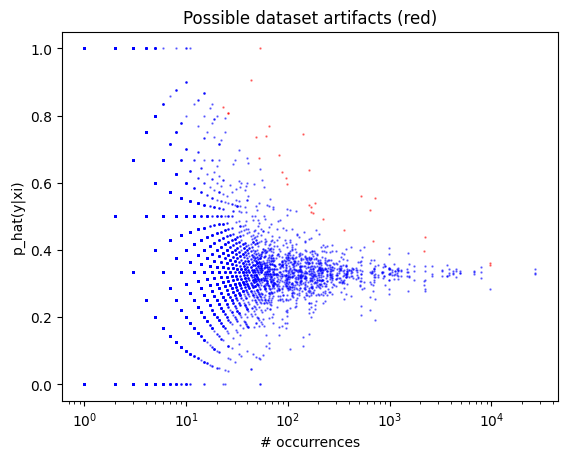

In [ ]:
subset = snli # all validation SNLI data
big = False # nli examples are custom class

n_gram_size = 1
big_ctr, e_ctr, n_ctr, c_ctr = make_counters_by_label(subset, big, n_gram_size)
p_hats, z_scores = get_p_hat_z_scores(big_ctr, e_ctr, n_ctr, c_ctr)
sig_z = make_plots_paper(big_ctr, e_ctr, n_ctr, c_ctr, z_scores, p_hats, plot_cutoff=30)

# Anything with z-scores above the significant level printed is likely an artifact
# Value will be in gathering the words identified w/ label artifacts
# note z_scores is a dictionary with z_scores[label][word] so should be easy to access this info

print(f'There are {len(subset)} examples')
print(f'Z-score for significance: {sig_z}.\nAny z-scores >= this are likely artifacts')
print(f'There are {len(big_ctr)} unique words in the dataset')
sig_z_entail = {key: value for key, value in z_scores[0].items() if value > sig_z}
sig_z_neut = {key: value for key, value in z_scores[1].items() if value > sig_z}
sig_z_contr = {key: value for key, value in z_scores[2].items() if value > sig_z}
# note the outputs below - some of these words are annotated in the plot in the paper
# more will appear if we include more data

# Get top artifacts
top_z_e = dict(sorted(z_scores[0].items(), key=lambda item: item[1], reverse=True)[:5])
top_z_n = dict(sorted(z_scores[1].items(), key=lambda item: item[1], reverse=True)[:5])
top_z_c = dict(sorted(z_scores[2].items(), key=lambda item: item[1], reverse=True)[:5])
print(f'\ntop entailment artifact words:\n{top_z_e}')
print(f'\ntop neutral artifact words:\n{top_z_n}')
print(f'\ntop contradiction artifact words:\n{top_z_c}')

items_to_write = [big_ctr, e_ctr, n_ctr, c_ctr, p_hats, z_scores]
names = ['big_ctr', 'e_ctr', 'n_ctr', 'c_ctr', 'p_hats', 'z_scores']
zip_path = '/content/snli_valid.zip'
write_zip_data(items_to_write, names, zip_path)
!cp -r '/content/snli_valid.zip' '/content/drive/MyDrive/NLP/Final'

In [ ]:
sig_z_entail
entail_cats = {'outdoors': ['outside', 'outdoors'],
               'people': ['people', 'person'],
               'ambiguous_loc': ['there', 'near']}

In [ ]:
sig_z_neut
neut_cats = {'connecting_words': ['to', 'the', 'for', 'because'],
             'pronouns': ['he', 'they'],
             'adjs': ['tall', 'about'],
             'nouns': ['friends'],
             'verbs': ['going']}

In [ ]:
sig_z_contr
contr_cats = {'voids_negations': ['nobody', 'alone', 'empty', 'no', 'naked'],
              'connecting_words': ['the'],
              'activities': ['swimming', 'driving', 'eating'],
              'sleep': ['sleeping', 'asleep', 'sleep', 'sleeps'],
              'cats': ['cat'],
              'location': ['inside']}

In [ ]:
all_cats = {0: entail_cats,
            1: neut_cats,
            2: contr_cats}
all_cats

{0: {'outdoors': ['outside', 'outdoors'],
  'people': ['people', 'person'],
  'general_loc': ['there', 'near']},
 1: {'connecting_words': ['to', 'the', 'for', 'because'],
  'pronouns': ['he', 'they'],
  'adjs': ['tall', 'about'],
  'nouns': ['friends'],
  'verbs': ['going']},
 2: {'voids_negations': ['nobody', 'alone', 'empty', 'no', 'naked'],
  'connecting_words': ['the'],
  'activities': ['swimming', 'driving', 'eating'],
  'sleep': ['sleeping', 'asleep', 'sleep', 'sleeps'],
  'cats': ['cat'],
  'location': ['inside']}}

In [ ]:
all_words = list(sig_z_neut.keys()) + list(sig_z_entail.keys()) + list(sig_z_contr.keys())

In [ ]:
pred_2 = [x for x in wrong_snli if x.pred_label == 2] # 28%
pred2_negs = [x for x in pred_2 if len(set(x.tok_hypoth()) & set(all_cats[2]['voids_negations'])) > 0]

pred_1 = [x for x in wrong_snli if x.pred_label == 1] # 28%
pred1_negs = [x for x in pred_1 if len(set(x.tok_hypoth()) & set(all_cats[2]['voids_negations'])) > 0]

pred_0 = [x for x in wrong_snli if x.pred_label == 0] # 28%
pred0_negs = [x for x in pred_0 if len(set(x.tok_hypoth()) & set(all_cats[2]['voids_negations'])) > 0]

all_flags = [x for x in wrong_snli if len(set(x.tok_hypoth()) & set(all_words)) > 0]

### Spelling errors - Correcting errors should improve model at least a little bit

In [ ]:
#!pip install -q pyspellchecker
from spellchecker import SpellChecker

def spell_check(nli_example):
    spell = SpellChecker()
    words = nli_example.tok_all(False)
    misp = spell.unknown(words)
    words = []
    if len(misp) > 0:
        for m in misp:
            words.append(misp)
        return True, words
    else:
        return False, words

sp_errors = []
word_errors = []
for ex in wrong_snli:
    res, words = spell_check(ex)
    if res == True:
        sp_errors.append(ex)
        word_errors.append(words)

In [ ]:
len(sp_errors)/len(wrong_snli) # 14% of wrong snli have spelling errors?

0.14064015518913675

In [ ]:
misspells = ['amusment', 'saftey', 'perfomers', 'poweder', 'swimsuites', 'charis', 'dowining', 'teanager', 'caucasion', 'fabic',
         'medow', 'silhoutte', 'perfom', 'voleyball', 'humean', 'skiiers', 'skyscaper', 'imatating', 'sandwhich', 'opppsing',
         'ayoung', 'mits', 'knelling', 'vaccuum', 'tailgaiting', 'unclimbable', 'grafitti', 'thier', 'esthetically',
         'gurnee', 'moppad']

In [ ]:
confirmed_spell_errors = [x for x in wrong_snli if len(set(x.tok_all(False)) & set(misspells)) > 0]

In [ ]:
confirmed_spell_errors

['hypothesis = Two young asian men are squatting.\npremise = This is the image of two Asian men squatting near a mop-pad.\nlabel=0\npredicted_label=1',
 'hypothesis = A man is on a gurney\npremise = Several men in protective suits are rolling a man on a gurnee.\nlabel=0\npredicted_label=2',
 'hypothesis = A man is being taken into the hospital\npremise = Several men in protective suits are rolling a man on a gurnee.\nlabel=1\npredicted_label=2',
 'hypothesis = A bicyclist passes an esthetically beautiful building on a sunny day\npremise = A building that portrays beautiful architecture stands in the sunlight as somebody on a bike passes by.\nlabel=0\npredicted_label=1',
 'hypothesis = The children are wearing red and green to practice thier Christmas show.\npremise = Two teams of children, one green the other red, play each other in a game of Rugby while it rains.\nlabel=2\npredicted_label=1',
 'hypothesis = The grafitti is a picture of a mouse.\npremise = 2 woman walking down the stre

### Negations

In [ ]:
negations = ['not', 'none', 'never', 'no one', 'nothing', 'neither', 'nor', 'no']
outdoors = ['outside', 'outdoors', 'outdoor']
sleep = ['sleepy', 'sleep', 'sleeping', 'asleep', 'sleeps', 'slept', 'sleepiness', 'sleepily', 'sleeper']

In [ ]:
otd = [x for x in wrong_snli if len(set(x.tok_all(True)) & set(outdoors)) > 0]
tmp = [x for x in otd if x.pred_label == 0]
print(len(tmp))
len(tmp)/len(otd) # model predicts 0 for nearly half of cases with outdoors words
# interesting because the competency results showed outdoor type words to be
# significantly more correlated w/ entail labels, so expect more entail predictions than make sense

39


0.43820224719101125

In [ ]:
otd_c = [x for x in correct_snli if len(set(x.tok_all(True)) & set(outdoors)) > 0]
tmp_c = [x for x in otd_c if x.pred_label == 0]
print(len(tmp_c))
len(tmp_c)/len(otd_c)

371


0.5196078431372549

In [ ]:
print(f'#correct entail guesses w/ outdoors words: {len(tmp)}')
print(f'#correct exs with outdoors words: {len(otd)}')
print(f'#incorrect entail guesses w/ outdoors words: {len(tmp_c)}')
print(f'#incorrect exs with outdoors words: {len(otd_c)}')
print(f'#entail guesses overall : {len(tmp) + len(tmp_c)}')
print(f'#total guesses overall : {len(otd_c) + len(otd)}')
print(f'% of guesses that were entail overall way more than 30% {(len(tmp) +len(tmp_c))/(len(otd_c) + len(otd))}')
# IDEA : TAKE TOP SPURIOUS N-GRAMS AND FIND THE % OF GUESSES THAT WERE (WHATEVER SPURIOUS CAT) OVERALL
# IS IT SIMILAR TO P_HAT?

#correct entail guesses w/ outdoors words: 39
#correct exs with outdoors words: 89
#incorrect entail guesses w/ outdoors words: 371
#incorrect exs with outdoors words: 714
#entail guesses overall : 410
#total guesses overall : 803
% of guesses that were entail overall 0.5105853051058531


In [ ]:
print(len([x for x in tmp if x.label == 2])/len(otd))
print(len([x for x in tmp if x.label == 1])/len(otd))

0.07865168539325842
0.3595505617977528


In [ ]:
tmp2 = [x for x in otd if x.pred_label == 1] #other one is about 40%
len(tmp2)
len(tmp2)/len(otd)

# This is interesting because

0.39325842696629215

In [ ]:
print(len([x for x in tmp2 if x.label == 2]))#/len(otd))
print(len([x for x in tmp2 if x.label == 0]))#/len(otd))

11
24


In [ ]:
slp = [x for x in wrong_snli if len(set(x.tok_all(True)) & set(sleep)) > 0]
len(slp)

10

In [ ]:
unq_high
# get p_hats by label for each of these

['waiting',
 'at home',
 'is swimming',
 'a tall',
 'alone',
 'empty',
 'to win',
 'for her',
 'winning',
 'to work',
 'brothers',
 'for',
 'are friends',
 'a competition',
 'not',
 'this picture',
 'vacation',
 'practicing for',
 'there',
 'are two',
 'eating',
 'swimming',
 'after',
 'ready to',
 'a sad',
 'way to',
 'they are',
 'is eating',
 'are going',
 'tall',
 'a cat',
 'friend',
 'a new',
 'his',
 'favorite',
 'watching tv',
 'inside',
 'tv',
 'sitting',
 'in this',
 'in bed',
 'get',
 'outdoors',
 'date',
 'naked',
 'he',
 'a person',
 'going to',
 'two cats',
 'eats',
 'are sitting',
 'talking about',
 'is waiting',
 'his wife',
 'for his',
 'is trying',
 'her',
 'about',
 'is no',
 'first time',
 'the couch',
 'is near',
 'is about',
 'there is',
 'wife',
 'outside',
 'is empty',
 'is outdoors',
 'to the',
 'no one',
 'is going',
 'an animal',
 'are swimming',
 'swimming in',
 'for the',
 'the',
 'are no',
 'is the',
 'sleeping on',
 'trying',
 'on vacation',
 'tall person'

In [ ]:
# Look at the top flag words instead (weed out some that are barely over threshold

uni_top_flags = [] # list entries 0 for entail, 1 for neut, 2 for contradict
for cat in uni_z:
    uni_top_flags.append({key: value for key, value in uni_z[cat].items() if value > sig_unigram})

bi_top_flags = [] # list entries 0 for entail, 1 for neut, 2 for contradict
for cat in uni_z:
    bi_top_flags.append({key: value for key, value in bi_z[cat].items() if value > sig_bigram})

{'outside': 46.80391985947917,
 'two': 6.291043081561256,
 'are': 6.5216133836829835,
 'some': 7.461229709392642,
 'there': 46.668497397832404,
 'has': 7.348363258477925,
 'person': 23.23570710132014,
 'standing': 6.845870309793157,
 'being': 5.902285618679901,
 'people': 24.832522652037063,
 'walking': 6.264528664505028,
 'wet': 7.624014753496903,
 'vehicle': 8.37808496568922,
 'holding': 6.573040498134521,
 'near': 20.09033235260517,
 'clothes': 7.249999999999999,
 'water': 11.42742306011851,
 'someone': 12.988912640070168,
 'working': 7.279397134482328,
 'human': 15.651487857866694,
 'something': 15.67757531619796,
 'outdoors': 39.06603060733542,
 'using': 6.349432928023,
 'together': 7.652508452060416,
 'interacting': 5.962965874907926,
 'animals': 10.236855869118523,
 'than': 7.718919099346541,
 'this': 5.525251484551482,
 'touching': 7.138005135780988,
 'music': 8.46901870051188,
 'picture': 8.595666700067063,
 'wears': 6.078244396621032,
 'moving': 12.448872884330758,
 'object':

# Model evaluation: Check p_hat(y|x) with hypothesis only predictions and compare to p_hats in competency analysis. Compare p_hats for top z* scores and low z* scores to get % diff (from paper)

#### Load stuff

In [12]:
!cp -r '/content/drive/MyDrive/NLP/Final/eval_output_snli_ngram_hyp_only_uni' '/content/'
!cp -r '/content/drive/MyDrive/NLP/Final/eval_output_snli_ngram_prem_only_uni' '/content/'
!cp -r '/content/drive/MyDrive/NLP/Final/eval_output_snli_ngram_hyp_only_gap' '/content/'
!cp -r '/content/drive/MyDrive/NLP/Final/eval_output_snli_ngram_prem_only_gap' '/content/'
!cp -r '/content/drive/MyDrive/NLP/Final/eval_output_snli_bigram_hyp_only_nstop_gen' '/content/'
!cp -r '/content/drive/MyDrive/NLP/Final/eval_output_snli_bigram_prem_only_nstop_gen' '/content/'
hyp_only_ngram = load_nli_examples_tok('/content/eval_output_snli_ngram_hyp_only_uni/eval_predictions.jsonl') # WITH UNIGRAMS - HYP ONLY
prem_only_ngram = load_nli_examples_tok('/content/eval_output_snli_ngram_prem_only_uni/eval_predictions.jsonl') # WITH UNIGRAMS - PREM ONLY
hyp_only_gaps = load_nli_examples_tok('/content/eval_output_snli_ngram_hyp_only_gap/eval_predictions.jsonl') # WITH GAP GRAMS - HYP ONLY
prem_only_gaps = load_nli_examples_tok('/content/eval_output_snli_ngram_prem_only_gap/eval_predictions.jsonl') # WITH GAP GRAMS - PREM ONLY
hyp_only_bi_nstop_gen = load_nli_examples_tok('/content/eval_output_snli_bigram_hyp_only_nstop_gen/eval_predictions.jsonl') # WITH BIGRAMS - NSTOP w GENDERS - HYP ONLY
prem_only_bi_nstop_gen = load_nli_examples_tok('/content/eval_output_snli_bigram_prem_only_nstop_gen/eval_predictions.jsonl') # WITH BIGRAMS - NSTOP w GENDERS - PREM ONLY

big_ctr1 = load_unprocessed('/content/snli_train_unigram/big_ctr.json')[0]
big_ctr2 = load_unprocessed('/content/snli_train_bigram/big_ctr.json')[0]
big_ctr_gaps = load_unprocessed('/content/snli_train_gapgram/big_ctr.json')[0]
big_ns_gen_ctr = load_unprocessed('/content/snli_train_bigram_nstop_gen/big_ctr.json')[0]

# find unique words that are possibly artifacts in certain contexts
uni_all_unique_keys = list(set(uni_z['0'].keys()) | set(uni_z['1'].keys()) | set(uni_z['2'].keys()))
bi_all_unique_keys = list(set(bi_z['0'].keys()) | set(bi_z['1'].keys()) | set(bi_z['2'].keys()))
all_all_unique_keys = list(set(uni_all_unique_keys) | set(bi_all_unique_keys))

m_words = ['he', 'him', 'his', 'man', 'boy', 'guy', 'lad', 'mr', 'dad', "he's", 'father', 'son', 'grandson', 'grandfather',
           'grandpa', 'uncle', 'brother', 'husband', 'boyfriend', 'himself']
f_words = ['she', 'her', 'hers', 'woman', 'girl', 'herself', 'lady', 'mrs', 'mom', 'mother', 'daughter', 'granddaughter',
           'grandmother', 'grandma', 'aunt', 'sister', 'wife', 'girlfriend', "she's"]
others = ['we', 'them', 'i', 'me', 'myself', 'ourselves', 'our', 'themselves', 'your','yours','yourself','yourselves']
genders = m_words + f_words

#### Code to evaluate the model under CA (Implement Gardner Competency Analysis p. 6).
Results should be similar to page 6 but might be different because we are not using the entire train set, just a subset

In [ ]:
def evaluate_model_z_p(zs, hyp_only, prem_only, ctr, filename='model_eval_stats',custom=False, is_bigram=False, cutoff=15):
#### LOGIC FOLLOWS PAPER PAGE 6 OF PAPER ##############
### Assume we have hyp_only and pred_only, which are model predictions from the
#one-token-hypothesis and null premise or one-token-premise and null hypothesis
    def get_new_p_hats(ctrs, hyp_pred, prem_pred, custom_keys=False, is_bigram=False, cutoff=15):
        # Method to calculate estimated p_hats from hyp_only and prem_only models
        # ex: ctrs = [e_ctr, n_ctr, c_ctr] or ctrs = ['a', 'b', 'c'... ]
        # ctrs is a list of keys (could be custom or from CA analysis)
        # Average the predicted class probs for each word from prem_only and hyp_only models
        if is_bigram==True:
            # truncate to speed up calcs - most are very uncommon.
            # In the paper I think they keep everything with > 20 occurrences
            ctrs = [[key for key, value in ctrs[0].items() if value >= cutoff]]
            custom_keys=True # treat it like a list

        p_hats = [{} for _ in range(len(ctrs))] # make p_hats holder for every input ctr
        for i in range(len(ctrs)):
            cur_p = p_hats[i] # empty dictionary
            if custom_keys:
                keys = ctrs[0]
            else:
                cur_ctr = ctrs[i]
                keys = cur_ctr.keys()
            print(f'found {len(keys)} keys')
            j = 0
            for key in keys:
                # get prediction scores from evaluation results for both hyp_only and prem_only
                hyp_res = torch.FloatTensor(np.array([x.scores for x in hyp_pred if x.hypoth == key]))
                prem_res = torch.FloatTensor(np.array([x.scores for x in prem_pred if x.premise == key]))
                # average them across each category (this is the p_hat estimate)
                hyp_probs = torch.nn.functional.softmax(hyp_res, dim=-1)
                prem_probs = torch.nn.functional.softmax(prem_res, dim=-1)
                probs = torch.mean(torch.stack([hyp_probs, prem_probs]), axis=0)
                if j % 1000 == 0:
                    print(f'iteration {j}, {round(100 * j/len(ctrs[0]), 2)} % complete for list {i}')
                j += 1
                try:
                    cur_p[key] = {'p_hats': probs.numpy()[0], 'pred_label' : np.argmax(probs.numpy()[0])}
                except IndexError:
                    continue
        return p_hats

    def filter_p(all_p_hats, word_list):
        f = [{key: value for key, value in all_p_hats.items() if key in word_list}]
        fdict = {key: value for d in f for key, value in d.items()}
        f2 = np.array([x[key]['p_hats'] for x in f for key in x if 'p_hats' in x[key]])
        fmean = f2.mean(axis=0)
        return fmean, fdict

    def delta_p(p1, p2, all=False, idx=0):
        if all:
            return 100*((p1 - p2)/2)
        else:
            return round(100*((p1 - p2)/2)[idx], 2)

    if custom:
        freq_words = ctr # keep all words, probably < 100 words total
        n = int(len(freq_words)/2)
    else:
        n = 50 # from paper
        freq_words = [key for key, value in ctr.items() if value >= 20] # words appearing at least 20 times

    # Get largest class conditional z* for each of the >- 20 frequency words
    z_score_cat = {0: {}, 1: {}, 2: {}}
    z_score_nocat = {}
    for word in freq_words:
        enc = [zs['0'][word], zs['1'][word], zs['2'][word]] # probs: e, n, c
        z_score_cat[np.argmax(enc)][word] = np.max(enc)
        z_score_nocat[word] = np.max(enc)

    # sort each group by zscore
    # From each of those groups, get 50 highest z* words and 50 lowest z* words, return the list of words
    # return 6 lists total
    top_ewords, _ = zip(*sorted(z_score_cat[0].items(), key=lambda item: item[1], reverse=True)[:n])
    top_nwords, _ = zip(*sorted(z_score_cat[1].items(), key=lambda item: item[1], reverse=True)[:n])
    top_cwords, _ = zip(*sorted(z_score_cat[2].items(), key=lambda item: item[1], reverse=True)[:n])
    low_ewords, _ = zip(*sorted(z_score_cat[0].items(), key=lambda item: item[1], reverse=True)[-n:])
    low_nwords, _ = zip(*sorted(z_score_cat[1].items(), key=lambda item: item[1], reverse=True)[-n:])
    low_cwords, _ = zip(*sorted(z_score_cat[2].items(), key=lambda item: item[1], reverse=True)[-n:])

    all_p_hats = get_new_p_hats([ctr], hyp_only, prem_only, custom, is_bigram, cutoff)[0]
    write_hats = {i: dict_value for i, dict_value in enumerate(all_p_hats)}
    write_file_json(filename, write_hats)

    #print(f'example of all_p_hats : {next(iter(all_p_hats.items()))}')

    f3, p_hat_freqword = filter_p(all_p_hats, freq_words)
    #print(f'example of p_hat_freqword : {next(iter(p_hat_freqword))}')
    fh, _ = filter_p(p_hat_freqword, top_ewords)
    fl, _ = filter_p(p_hat_freqword, low_ewords)
    dp_e = delta_p(fh, fl, all=False, idx=0)
    print(f'\ndelta-p_hat - ENTAILMENT: {dp_e} %')
    # compare to paper ~ 14.7% for unigram

    fh, _ = filter_p(p_hat_freqword, top_nwords)
    fl, _ = filter_p(p_hat_freqword, low_nwords)
    dp_n = delta_p(fh, fl, all=False, idx=1)
    print(f'delta-p_hat - NEUTRAL: {dp_n} %')
    # compare to paper ~ 7.9 % for unigram

    fh, _ = filter_p(p_hat_freqword, top_cwords)
    fl, _ = filter_p(p_hat_freqword, low_cwords)
    dp_c = delta_p(fh, fl, all=False, idx=2)
    print(f'delta-p_hat - CONTRADICTION: {dp_c} %')
    # compare to paper ~ 12.5 % for unigram

    return [dp_e, dp_n, dp_c]




---



---





---


#### Original model evaluation: Calculate p_hats overall (do not modify)

In [ ]:
# CA Model Evaluation - UNIGRAM
zs = load_unprocessed('/content/snli_train_unigram/z_scores.json')[0] # zscores from unigram CA analysis
big_ctr1 = load_unprocessed('/content/snli_train_unigram/big_ctr.json')[0] # big_ctr from unigram CA analysis
hyp_only_ngram = load_nli_examples_tok('/content/eval_output_snli_ngram_hyp_only_uni/eval_predictions.jsonl') # WITH UNIGRAMS - HYP ONLY
prem_only_ngram = load_nli_examples_tok('/content/eval_output_snli_ngram_prem_only_uni/eval_predictions.jsonl') # WITH UNIGRAMS - PREM ONLY

# runs in about 2 min
unigram_bias = evaluate_model_z_p(zs, hyp_only_ngram, prem_only_ngram, big_ctr1, 'model_eval_unigram_bias.json')

found 26397 keys
iteration 0, 0.0 % complete for list 0
iteration 1000, 3.79 % complete for list 0
iteration 2000, 7.58 % complete for list 0
iteration 3000, 11.36 % complete for list 0
iteration 4000, 15.15 % complete for list 0
iteration 5000, 18.94 % complete for list 0
iteration 6000, 22.73 % complete for list 0
iteration 7000, 26.52 % complete for list 0
iteration 8000, 30.31 % complete for list 0
iteration 9000, 34.09 % complete for list 0
iteration 10000, 37.88 % complete for list 0
iteration 11000, 41.67 % complete for list 0
iteration 12000, 45.46 % complete for list 0
iteration 13000, 49.25 % complete for list 0
iteration 14000, 53.04 % complete for list 0
iteration 15000, 56.82 % complete for list 0
iteration 16000, 60.61 % complete for list 0
iteration 17000, 64.4 % complete for list 0
iteration 18000, 68.19 % complete for list 0
iteration 19000, 71.98 % complete for list 0
iteration 20000, 75.77 % complete for list 0
iteration 21000, 79.55 % complete for list 0
iteration 2

In [ ]:
# CA Model Evaluation - Bigram, No stop words but leave gender words in
zs_ns_gen = load_unprocessed('/content/snli_train_bigram_nstop_gen/z_scores.json')[0] # zscores from unigram CA analysis
big_ns_gen_ctr = load_unprocessed('/content/snli_train_bigram_nstop_gen/big_ctr.json')[0] # big_ctr from bigram ns gen CA analysis
hyp_only_bi_nstop_gen = load_nli_examples_tok('/content/eval_output_snli_bigram_hyp_only_nstop_gen/eval_predictions.jsonl') # WITH BIGRAMS - NSTOP w GENDERS - HYP ONLY
prem_only_bi_nstop_gen = load_nli_examples_tok('/content/eval_output_snli_bigram_prem_only_nstop_gen/eval_predictions.jsonl') # WITH BIGRAMS - NSTOP w GENDERS - PREM ONLY

# runs in about 5 min
fn = 'model_eval_bigram_ns_gen_bias.json'
bigram_ns_gen_bias = evaluate_model_z_p(zs_ns_gen, hyp_only_bi_nstop_gen, prem_only_bi_nstop_gen, big_ns_gen_ctr, fn, custom=False, is_bigram=True)

found 8527 keys
iteration 0, 0.0 % complete for list 0
iteration 1000, 11.73 % complete for list 0
iteration 2000, 23.45 % complete for list 0
iteration 3000, 35.18 % complete for list 0
iteration 4000, 46.91 % complete for list 0
iteration 5000, 58.64 % complete for list 0
iteration 6000, 70.36 % complete for list 0
iteration 7000, 82.09 % complete for list 0
iteration 8000, 93.82 % complete for list 0

delta-p_hat - ENTAILMENT: 10.09 %
delta-p_hat - NEUTRAL: 15.12 %
delta-p_hat - CONTRADICTION: 17.6 %


In [ ]:
# CA Model Evaluation - " Gapgram " ? - tokenize every other word as a bigram
zs_gap = load_unprocessed('/content/snli_train_gapgram/z_scores.json')[0] # zscores from unigram CA analysis
big_gap_ctr = load_unprocessed('/content/snli_train_gapgram/big_ctr.json')[0] # big_ctr from bigram ns gen CA analysis
prem_only_gap = load_nli_examples_tok('/content/eval_output_snli_ngram_prem_only_gap/eval_predictions.jsonl') # WITH BIGRAMS - NSTOP w GENDERS - HYP ONLY
hyp_only_gap = load_nli_examples_tok('/content/eval_output_snli_ngram_hyp_only_gap/eval_predictions.jsonl') # WITH BIGRAMS - NSTOP w GENDERS - PREM ONLY

# runs in about 20 min
fn = 'model_eval_gapgram_bias.json'
bigram_gap_bias = evaluate_model_z_p(zs_gap, hyp_only_gap, prem_only_gap, big_gap_ctr, fn, custom=False, is_bigram=True, cutoff=30)

found 13221 keys
iteration 0, 0.0 % complete for list 0
iteration 1000, 7.56 % complete for list 0
iteration 2000, 15.13 % complete for list 0
iteration 3000, 22.69 % complete for list 0
iteration 4000, 30.25 % complete for list 0
iteration 5000, 37.82 % complete for list 0
iteration 6000, 45.38 % complete for list 0
iteration 7000, 52.95 % complete for list 0
iteration 8000, 60.51 % complete for list 0
iteration 9000, 68.07 % complete for list 0
iteration 10000, 75.64 % complete for list 0
iteration 11000, 83.2 % complete for list 0
iteration 12000, 90.76 % complete for list 0
iteration 13000, 98.33 % complete for list 0

delta-p_hat - ENTAILMENT: 16.96 %
delta-p_hat - NEUTRAL: 10.36 %
delta-p_hat - CONTRADICTION: 21.3 %




---

####  USEFUL! Evaluate retrained netural model

##### Get hyp-only and prem-only evaluations from model (Do not edit)

We don't care about accuracy we are just getting label scores

In [ ]:
# get evals from bigram nstop gen
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/bigram_nstop_gen_hyp_only.json --model ./retrained_model/ --output_dir ./eval_retrained_bigram_hyp_only_nstop_gen/
!cp -r '/content/eval_retrained_bigram_hyp_only_nstop_gen/' '/content/drive/MyDrive/NLP/Final/'
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/bigram_nstop_gen_prem_only.json --model ./retrained_model/ --output_dir ./eval_retrained_bigram_prem_only_nstop_gen/
!cp -r '/content/eval_retrained_bigram_prem_only_nstop_gen/' '/content/drive/MyDrive/NLP/Final/'
retrain_bnsgen_hyp = load_nli_examples_tok('/content/eval_retrained_bigram_hyp_only_nstop_gen/eval_predictions.jsonl') # BIGRAM NSTOP GEN - HYP ONLY
retrain_bnsgen_prem = load_nli_examples_tok('/content/eval_retrained_bigram_prem_only_nstop_gen/eval_predictions.jsonl') # BIGRAM NSTOP GEN - PREM ONLY

2023-12-03 17:33:26.844162: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 17:33:26.844221: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 17:33:26.844248: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 17:33:28.128714: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 305057/305057 [00:14<00:00, 21372.05 examples/s]
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast token

In [ ]:
# get evals from unigram
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/hyp_only_uni.json --model ./retrained_model/ --output_dir ./eval_retrained_hyp_only_uni/
!cp -r '/content/eval_retrained_hyp_only_uni/' '/content/drive/MyDrive/NLP/Final/'
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/prem_only_uni.json --model ./retrained_model/ --output_dir ./eval_retrained_prem_only_uni/
!cp -r '/content/eval_retrained_prem_only_uni/' '/content/drive/MyDrive/NLP/Final/'
retrain_uni_hyp = load_nli_examples_tok('/content/eval_retrained_hyp_only_uni/eval_predictions.jsonl') # BIGRAM NSTOP GEN - HYP ONLY
retrain_uni_prem = load_nli_examples_tok('/content/eval_retrained_prem_only_uni/eval_predictions.jsonl') # BIGRAM NSTOP GEN - PREM ONLY

2023-12-03 17:54:30.819641: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 17:54:30.819695: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 17:54:30.819725: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 17:54:32.006472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Extracting data files: 100% 1/1 [00:00<00:00, 1567.96it/s]
Generating train split: 26397 examples [00:00, 463837.33 examples/s]
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 26

In [ ]:
# get evals from gapgram
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/ngram_hyp_only_gap.json --model ./retrained_model/ --output_dir ./eval_retrained_hyp_only_gap/
!cp -r '/content/eval_retrained_hyp_only_gap/ '/content/drive/MyDrive/NLP/Final/'
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/ngram_prem_only_gap.json --model ./retrained_model/ --output_dir ./eval_retrained_prem_only_gap/
!cp -r '/content/eval_retrained_prem_only_gap/ '/content/drive/MyDrive/NLP/Final/'
retrain_gap_hyp = load_nli_examples_tok('/content/eval_retrained_hyp_only_gap/eval_predictions.jsonl') # BIGRAM NSTOP GEN - HYP ONLY
retrain_gap_prem = load_nli_examples_tok('/content/eval_retrained_prem_only_gap/eval_predictions.jsonl') # BIGRAM NSTOP GEN - PREM ONLY

2023-12-03 17:59:09.597117: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 17:59:09.597174: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 17:59:09.597204: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 17:59:10.879702: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Extracting data files: 100% 1/1 [00:00<00:00, 1738.21it/s]
Generating train split: 461371 examples [00:01, 262346.71 examples/s]
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 4



---

##### USEFUL! Get CA Model Evaluation for Retrained Model (Do after we re-run CA on modified dataset)


In [ ]:
# CA Model Evaluation - UNIGRAM
#!unzip -q '/content/re_snli_train_unigram.zip' -d '/content/re_snli_train_unigram'
zs = load_unprocessed('/content/re_snli_train_unigram/z_scores.json')[0] # zscores from unigram CA analysis
big_ctr1 = load_unprocessed('/content/re_snli_train_unigram/big_ctr.json')[0] # big_ctr from unigram CA analysis
re_hyp_only_uni = load_nli_examples_tok('/content/eval_retrained_hyp_only_uni/eval_predictions.jsonl') # WITH UNIGRAMS - HYP ONLY
re_prem_only_uni = load_nli_examples_tok('/content/eval_retrained_prem_only_uni/eval_predictions.jsonl') # WITH UNIGRAMS - PREM ONLY

# runs in about 2 min
re_unigram_bias = evaluate_model_z_p(zs, re_hyp_only_uni, re_prem_only_uni, big_ctr1, 're_model_eval_unigram_bias.json')
!cp -r '/content/re_model_eval_unigram_bias.json' '/content/drive/MyDrive/NLP/Final'

found 26425 keys
iteration 0, 0.0 % complete for list 0
iteration 1000, 3.78 % complete for list 0
iteration 2000, 7.57 % complete for list 0
iteration 3000, 11.35 % complete for list 0
iteration 4000, 15.14 % complete for list 0
iteration 5000, 18.92 % complete for list 0
iteration 6000, 22.71 % complete for list 0
iteration 7000, 26.49 % complete for list 0
iteration 8000, 30.27 % complete for list 0
iteration 9000, 34.06 % complete for list 0
iteration 10000, 37.84 % complete for list 0
iteration 11000, 41.63 % complete for list 0
iteration 12000, 45.41 % complete for list 0
iteration 13000, 49.2 % complete for list 0
iteration 14000, 52.98 % complete for list 0
iteration 15000, 56.76 % complete for list 0
iteration 16000, 60.55 % complete for list 0
iteration 17000, 64.33 % complete for list 0
iteration 18000, 68.12 % complete for list 0
iteration 19000, 71.9 % complete for list 0
iteration 20000, 75.69 % complete for list 0
iteration 21000, 79.47 % complete for list 0
iteration 22

In [ ]:
# CA Model Evaluation - Bigram, No stop words but leave gender words in
!unzip -q '/content/re_snli_train_bigram_nstop_gen.zip' -d '/content/re_snli_train_bigram_nstop_gen'
zs_ns_gen = load_unprocessed('/content/re_snli_train_bigram_nstop_gen/z_scores.json')[0] # zscores from unigram CA analysis
big_ns_gen_ctr = load_unprocessed('/content/re_snli_train_bigram_nstop_gen/big_ctr.json')[0] # big_ctr from bigram ns gen CA analysis
re_hyp_only_nstop_gen = load_nli_examples_tok('/content/eval_retrained_bigram_hyp_only_nstop_gen/eval_predictions.jsonl') # WITH BIGRAMS - NSTOP w GENDERS - HYP ONLY
re_prem_only_nstop_gen = load_nli_examples_tok('/content/eval_retrained_bigram_prem_only_nstop_gen/eval_predictions.jsonl') # WITH BIGRAMS - NSTOP w GENDERS - PREM ONLY

# runs in about 8 min
fn = 're_model_eval_bigram_ns_gen_bias.json'
re_bigram_ns_gen_bias = evaluate_model_z_p(zs_ns_gen, re_hyp_only_nstop_gen, re_prem_only_nstop_gen, big_ns_gen_ctr, fn, custom=False, is_bigram=True)
!cp -r '/content/re_model_eval_bigram_ns_gen_bias.json' '/content/drive/MyDrive/NLP/Final'

found 8512 keys
iteration 0, 0.0 % complete for list 0
iteration 1000, 11.75 % complete for list 0
iteration 2000, 23.5 % complete for list 0
iteration 3000, 35.24 % complete for list 0
iteration 4000, 46.99 % complete for list 0
iteration 5000, 58.74 % complete for list 0
iteration 6000, 70.49 % complete for list 0
iteration 7000, 82.24 % complete for list 0
iteration 8000, 93.98 % complete for list 0

delta-p_hat - ENTAILMENT: 11.53 %
delta-p_hat - NEUTRAL: 23.7 %
delta-p_hat - CONTRADICTION: 17.95 %


#### Examine some gender bias

In [ ]:
zs_ns_gen = load_unprocessed('/content/snli_train_bigram_nstop_gen/z_scores.json')[0] # zscores from unigram CA analysis
big_ctr1 = load_unprocessed('/content/snli_train_bigram_nstop_gen/big_ctr.json')[0] # big_ctr from unigram CA analysis
#genders = m_words + f_words + others
zs = zs_ns_gen
z_score_cat = {0: {}, 1: {}, 2: {}}
z_score_nocat = {}
z_scores_gender = {'m': {}, 'f': {}, 'n':{}}
zs_gender_words = [d for d in zs.values() if any(substring in d.keys() for substring in genders)]
for word in genders:
    try:
        enc = [zs['0'][word], zs['1'][word], zs['2'][word]] # probs: e, n, c
        z_score_cat[np.argmax(enc)][word] = np.max(enc)
        z_score_nocat[word] = np.max(enc)
        if word in m_words:
            z_scores_gender['m'][word] = [zs['0'][word], zs['1'][word], zs['2'][word]]
        elif word in others:
            z_scores_gender['n'][word] = [zs['0'][word], zs['1'][word], zs['2'][word]]
        elif word in f_words:
            z_scores_gender['f'][word] = [zs['0'][word], zs['1'][word], zs['2'][word]]
    except:
        continue

In [ ]:
#all_p_hats = get_new_p_hats([big_ctr1], hyp_only_ngram, prem_only_ngram, False)[0]
z_scores_gender
m_z_scores = np.array([value for key, value in z_scores_gender['m'].items()])
f_z_scores = np.array([value for key, value in z_scores_gender['f'].items()])
n_z_scores = np.array([value for key, value in z_scores_gender['n'].items()])

print(m_z_scores.mean(axis=0))
print(f_z_scores.mean(axis=0))
print(n_z_scores.mean(axis=0))

In [ ]:
def filter_p(all_p_hats, word_list):
        f = [{key: value for key, value in all_p_hats.items() if key in word_list}]
        fdict = {key: value for d in f for key, value in d.items()}
        f2 = np.array([x[key]['p_hats'] for x in f for key in x if 'p_hats' in x[key]])
        fmean = f2.mean(axis=0)
        return fmean, fdict, f2

def delta_p(p1, p2, all=False, idx=0):
    if all:
        return 100*((p1 - p2)/2)
    else:
        return round(100*((p1 - p2)/2)[idx], 2)

In [ ]:
m1 = filter_p(gen_p_hats, m_words)[0] # m
nm1 = filter_p(gen_p_hats, set(genders) - set(m_words))[0] # not m
delta_p(m1, nm1, True)
# differences from m to nm. Example, m entail 0.5 less than nm. m

array([-0.4922241,  3.757122 , -3.2648988], dtype=float32)

In [ ]:
f1 = filter_p(gen_p_hats, f_words)[0]
nf1 = filter_p(gen_p_hats, set(genders) - set(f_words))[0]
delta_p(f1, nf1, True)

array([-5.5460987 ,  6.3103857 , -0.76428354], dtype=float32)

In [ ]:
o1 = filter_p(gen_p_hats, others)[0]
no1 = filter_p(gen_p_hats, set(genders) - set(others))[0]
delta_p(o1, no1, True)

array([  9.927578 , -16.6313   ,   6.7037234], dtype=float32)




#### Plots of Gender Bias

In [ ]:
def make_graphs(p_hats):
    # b_p_hats bigrams w/ gender words
    bph_g = {key: value for key, value in p_hats.items() if any(sub in key.split() for sub in genders)}
    bph_g_pred = {key: value['pred_label'] for key, value in bph_g.items()}
    bph_g_p_hats = {key: value['p_hats'] for key, value in bph_g.items()}
    gen_ctr = {key: value for key, value in big_ns_gen_ctr.items() if any(sub in key.split() for sub in genders)}
    gen_ctr = {key: value for key, value in gen_ctr.items() if value >= 15 and key in bph_g.keys()} # not all keys will be there since we eliminated some

    ent_bph_g = [x[0] for x in bph_g_p_hats.values()] # all entail values
    neu_bph_g = [x[1] for x in bph_g_p_hats.values()] # all neutral values
    cont_bph_g = [x[2] for x in bph_g_p_hats.values()] # all contradiction values

    m_ctr = {key: value for key, value in gen_ctr.items() if any(sub in key.split() for sub in m_words)}
    f_ctr = {key: value for key, value in gen_ctr.items() if any(sub in key.split() for sub in f_words)}
    o_ctr = {key: value for key, value in gen_ctr.items() if any(sub in key.split() for sub in others)}

    # split main dataset by gender
    bph_g_m = {key: value for key, value in bph_g.items() if any(sub in key.split() for sub in m_words)}
    bph_g_f = {key: value for key, value in bph_g.items() if any(sub in key.split() for sub in f_words)}
    bph_g_o = {key: value for key, value in bph_g.items() if any(sub in key.split() for sub in others)}

    bph_g_m_phats = [value['p_hats'][0] for key, value in bph_g_m.items()]
    bph_g_f_phats = [value['p_hats'][0] for key, value in bph_g_f.items()]
    bph_g_o_phats = [value['p_hats'][0] for key, value in bph_g_o.items()]
    m0 = [value['p_hats'][0] for key, value in bph_g_m.items()]
    f0 = [value['p_hats'][0] for key, value in bph_g_f.items()]
    o0 = [value['p_hats'][0] for key, value in bph_g_o.items()]
    m1 = [value['p_hats'][1] for key, value in bph_g_m.items()]
    f1 = [value['p_hats'][1] for key, value in bph_g_f.items()]
    o1 = [value['p_hats'][1] for key, value in bph_g_o.items()]
    m2 = [value['p_hats'][2] for key, value in bph_g_m.items()]
    f2 = [value['p_hats'][2] for key, value in bph_g_f.items()]
    o2 = [value['p_hats'][2] for key, value in bph_g_o.items()]

    mp = [value['p_hats'][value['pred_label']] for key, value in bph_g_m.items()]
    fp = [value['p_hats'][value['pred_label']] for key, value in bph_g_f.items()]
    op = [value['p_hats'][value['pred_label']] for key, value in bph_g_o.items()]

    # split predictions by gender
    bph_g_m_pred = {key: value for key, value in bph_g_pred.items() if any(sub in key.split() for sub in m_words)}
    bph_g_f_pred = {key: value for key, value in bph_g_pred.items() if any(sub in key.split() for sub in f_words)}
    bph_g_o_pred = {key: value for key, value in bph_g_pred.items() if any(sub in key.split() for sub in others)}

    import matplotlib.pyplot as plt
    from scipy.stats import norm
    sig = 0.01
    alpha = sig * (1/len(gen_ctr))
    reject_null_z = norm.ppf(1- alpha/2)
    print('significant z is: ', reject_null_z)

    plt.scatter(m_ctr.values(), m0, color='blue', marker='.',s=10, alpha=0.3, label='male')
    plt.scatter(f_ctr.values(), f0, color='red', marker='.',s=10, alpha=0.3, label='female')
    plt.scatter(o_ctr.values(), o0, color='green', marker='.',s=10, alpha=0.3, label='general')
    plt.xlabel('n')
    plt.ylabel('p_hat(y|xi)')
    plt.legend()
    plt.title('Entailment probabilities by gender:\nBigrams, stopwords removed (except gender)')
    plt.show()

    plt.scatter(m_ctr.values(), m1, color='blue', marker='.',s=10, alpha=0.3, label='male')
    plt.scatter(f_ctr.values(), f1, color='red', marker='.',s=10, alpha=0.3, label='female')
    plt.scatter(o_ctr.values(), o1, color='green', marker='.',s=10, alpha=0.3, label='general')
    plt.xlabel('n')
    plt.ylabel('p_hat(y|xi)')
    plt.legend()
    plt.title('Neutral probabilities by gender:\nBigrams, stopwords removed (except gender)')
    plt.show()

    plt.scatter(m_ctr.values(), m2, color='blue', marker='.',s=10, alpha=0.3, label='male')
    plt.scatter(f_ctr.values(), f2, color='red', marker='.',s=10, alpha=0.3, label='female')
    plt.scatter(o_ctr.values(), o2, color='green', marker='.',s=10, alpha=0.3, label='general')
    plt.xlabel('n')
    plt.ylabel('p_hat(y|xi)')
    plt.legend()
    plt.title('Contradiction probabilities by gender:\nBigrams, stopwords removed (except gender)')
    plt.show()

    plt.scatter(m_ctr.values(), mp, color='blue', marker='.',s=10, alpha=0.3, label='male')
    plt.scatter(f_ctr.values(), fp, color='red', marker='.',s=10, alpha=0.3, label='female')
    plt.scatter(o_ctr.values(), op, color='green', marker='.',s=10, alpha=0.3, label='general')
    plt.xlabel('n')
    plt.ylabel('p_hat(y|xi)')
    plt.legend()
    plt.title('Probability of predicted class by gender:\nBigrams, stopwords removed (except gender)')
    plt.show()

    alpha = sig * (1/len(gen_ctr))
    reject_null_z = norm.ppf(1- alpha/2)
    #print('significant z is: ', reject_null_z)

    plt.scatter(gen_ctr.values(), ent_bph_g, color='blue', marker='.',s=5, alpha=0.5, label='entail')
    plt.scatter(gen_ctr.values(), neu_bph_g, color='green', marker='.',s=5, alpha=0.5, label='neut')
    plt.scatter(gen_ctr.values(), cont_bph_g, color='orange', marker='.',s=5, alpha=0.5, label='contr')
    plt.xlabel('n')
    plt.ylabel('p_hat(y|xi)')
    #plt.xscale('log') # un-squish output
    plt.legend()
    plt.title('Estimated probabilities for SNLI-trained model if gender words:\nBigrams, stopwords removed (except gender)')
    plt.show()

significant z is:  4.510884788875435


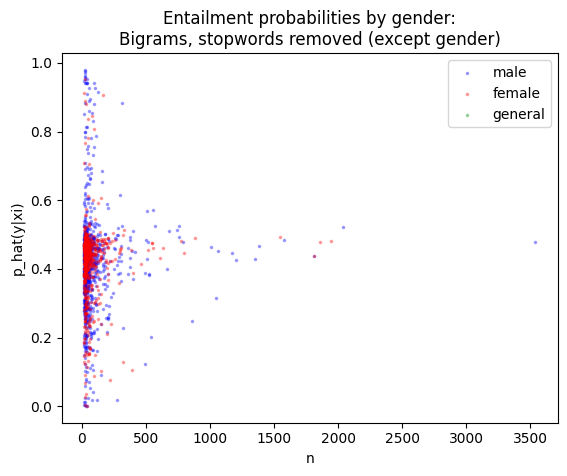

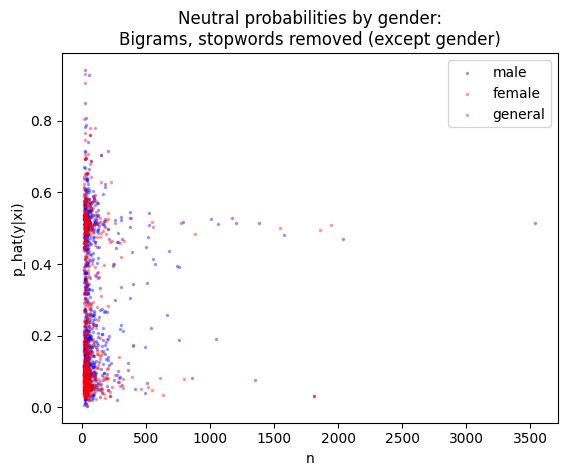

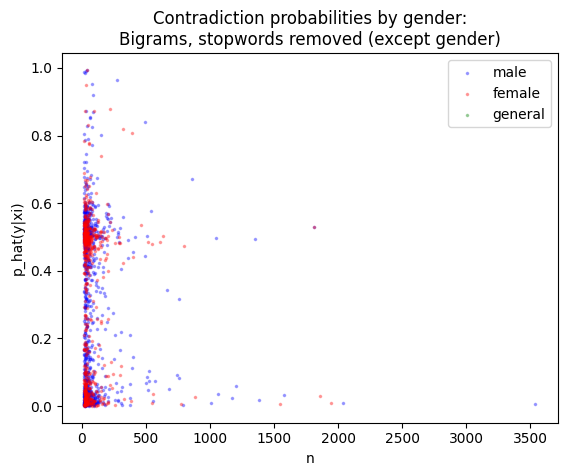

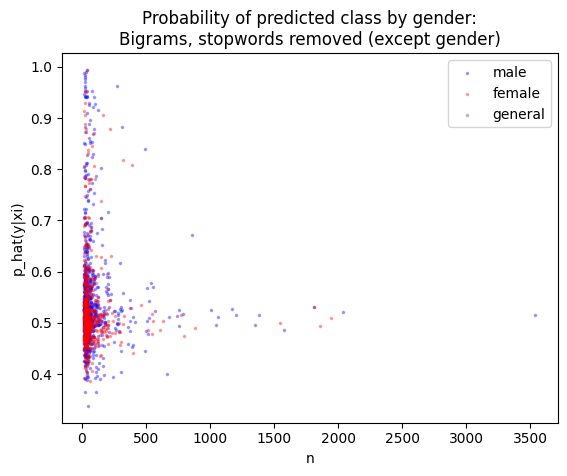

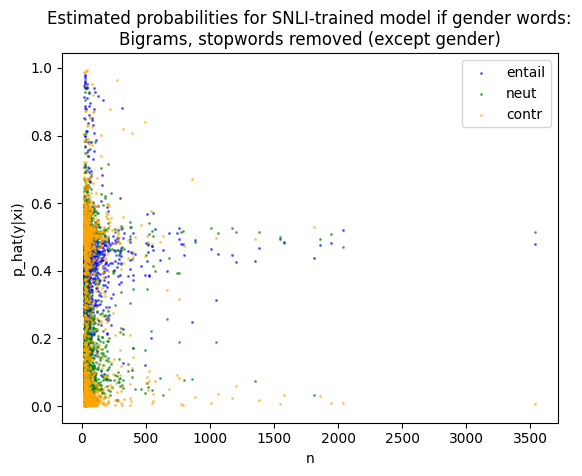

In [ ]:
make_graphs(b_p_hats[0])

# These mainly just show that there are an imbalance of labels overall in different label categories, not too interesting

#### USEFUL! Artifact words categorization

In [ ]:
# ORIGINAL BEFORE RETRAINING
from nltk import pos_tag
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def is_adjective(word):
    tagged_word = pos_tag(word_tokenize(word))
    tags = ['JJ', 'PRP$']
    found = [tagged_word[0][1], tagged_word[1][1]]
    return any(t in found for t in tags)

# top bigram ns_gen artifacts:
zs_bg = load_unprocessed('/content/snli_train_bigram_nstop_gen/z_scores.json')[0] # 5.526384225449986
sig_entail_bgd = {key: value for key, value in zs_bg['0'].items() if value >= 5.526384225449986}
sig_entail_bgd = dict(sorted(sig_entail_bgd.items(), key=lambda item: item[1], reverse=True))
print(sig_entail_bgd, '\n')
# mostly generic people doing things outdoors

sig_cont_bgd = {key: value for key, value in zs_bg['2'].items() if value >= 5.526384225449986}
sig_cont_bgd = dict(sorted(sig_cont_bgd.items(), key=lambda item: item[1], reverse=True))
print(sig_cont_bgd, '\n')
# lots of 'ing' words and verbs

sig_neu_bgd = {key: value for key, value in zs_bg['1'].items() if value >= 5.526384225449986}
sig_neu_bgd = dict(sorted(sig_neu_bgd.items(), key=lambda item: item[1], reverse=True))
print(sig_neu_bgd)
# lots of adjectives

adjs = {key: value for key,value in sig_neu_bgd.items() if is_adjective(key)}
print(f'\n{100 * round(len(adjs)/len(sig_cont_bgd), 4)} % of artifact words for neutral class containing adjectives or possessive pronouns : ')
print(f'{100 * len(adjs)/(len(sig_entail_bgd) + len(sig_cont_bgd) + len(sig_neu_bgd))} % of all artifact words w/ adjectives or possessive pronouns\n')

# CONTR COMMON WORDS
ings = {key: value for key,value in sig_cont_bgd.items() if any(sub in key for sub in ['ing']) }
print(f'{100 * round(len(ings)/len(sig_cont_bgd), 4)} % of artifact words for contradiction class containing "ing" : ')
print(f'{100 * len(ings)/(len(sig_entail_bgd) + len(sig_cont_bgd) + len(sig_neu_bgd))} % of all artifact words w/ "ing\n')

# ENTAIL COMMON WORDS
outs = {key: value for key,value in sig_entail_bgd.items() if any(sub in key for sub in ['out']) }
print(f'{100 * round(len(outs)/len(sig_entail_bgd), 4)} % of artifact words for entail class containing "out" : ')
print(f'{100 * len(outs)/(len(sig_entail_bgd) + len(sig_cont_bgd) + len(sig_neu_bgd))} % of all artifact words w/ "out\n')

peops = {key: value for key,value in sig_entail_bgd.items() if any(sub in key for sub in ['peop']) }
print(f'{100 * round(len(peops)/len(sig_entail_bgd), 4)} % of artifact words for entail class containing "peop" : ')
print(f'{100 * len(peops)/(len(sig_entail_bgd) + len(sig_cont_bgd) + len(sig_neu_bgd))} % of all artifact words w/ "peop\n')

# GENDER WORDS
gens = {key: value for key,value in sig_entail_bgd.items() if any(sub in key.split() for sub in genders) }
print(f'{100 * round(len(gens)/len(sig_entail_bgd), 4)} % of artifact words for entail class containing gender words : ')
print(f'{100 * len(gens)/(len(sig_entail_bgd) + len(sig_cont_bgd) + len(sig_neu_bgd))} % of all artifact words w/ gender words\n')
gens_e = gens

gens = {key: value for key,value in sig_cont_bgd.items() if any(sub in key.split() for sub in genders) }
print(f'{100 * round(len(gens)/len(sig_cont_bgd), 4)} % of artifact words for contradiction class containing gender words : ')
print(f'{100 * len(gens)/(len(sig_entail_bgd) + len(sig_cont_bgd) + len(sig_neu_bgd))} % of all artifact words w/ gender words\n')
gens_n = gens

gens = {key: value for key,value in sig_neu_bgd.items() if any(sub in key.split() for sub in genders) }
print(f'{100 * round(len(gens)/len(sig_neu_bgd), 4)} % of artifact words for neutral class containing gender words : ')
print(f'{100 * len(gens)/(len(sig_entail_bgd) + len(sig_cont_bgd) + len(sig_neu_bgd))} % of all artifact words w/ gender words\n')
gens_c = gens

all_gens = len(gens_e) + len(gens_n) + len(gens_c)
all_artifacts = len(sig_entail_bgd) + len(sig_cont_bgd) + len(sig_neu_bgd)
print(f'Overall, artifacts in all classes containing gender words make up {round(100*all_gens/all_artifacts,4)} % of artifacts')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


{'people outside': 17.588667757399254, 'man outside': 12.44601244601867, 'people outdoors': 11.699403106904693, 'man outdoors': 10.937374832394612, 'dog outside': 10.565509926170153, 'woman outside': 10.55220888847617, 'two people': 10.34603984819992, 'men outside': 9.92955185292871, 'walking outside': 9.255869650910846, 'woman outdoors': 9.1, 'wearing clothes': 9.075625183813191, 'person outside': 9.025217197084261, 'man near': 9.018797573813227, 'people near': 8.925731045622829, 'boy outside': 8.53991993862586, 'girl outside': 8.332380897952962, 'wearing clothing': 7.905694150420948, 'playing instrument': 7.848183545407563, 'dogs outside': 7.636550360499871, 'dog outdoors': 7.528517213141738, 'person outdoors': 7.2908945169398, 'animal outside': 7.112007112010667, 'playing music': 7.0613481264300635, 'children outside': 6.740358479519649, 'people walking': 6.724197702514836, 'multiple people': 6.6996452071463715, 'near water': 6.499365987675894, 'people present': 6.453979094624195, '

In [ ]:
#AFTER RETRAINING
from nltk import pos_tag
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def is_adjective(word):
    tagged_word = pos_tag(word_tokenize(word))
    tags = ['JJ', 'PRP$']
    found = [tagged_word[0][1], tagged_word[1][1]]
    return any(t in found for t in tags)

# top bigram ns_gen artifacts:
zs_bg = load_unprocessed('/content/re_snli_train_bigram_nstop_gen/z_scores.json')[0] # 5.526384225449986
sig_entail_bgd = {key: value for key, value in zs_bg['0'].items() if value >= 5.526384225449986}
sig_entail_bgd = dict(sorted(sig_entail_bgd.items(), key=lambda item: item[1], reverse=True))
print(sig_entail_bgd, '\n')
# mostly generic people doing things outdoors

sig_cont_bgd = {key: value for key, value in zs_bg['2'].items() if value >= 5.526384225449986}
sig_cont_bgd = dict(sorted(sig_cont_bgd.items(), key=lambda item: item[1], reverse=True))
print(sig_cont_bgd, '\n')
# lots of 'ing' words and verbs

sig_neu_bgd = {key: value for key, value in zs_bg['1'].items() if value >= 5.526384225449986}
sig_neu_bgd = dict(sorted(sig_neu_bgd.items(), key=lambda item: item[1], reverse=True))
print(sig_neu_bgd)
# lots of adjectives

adjs = {key: value for key,value in sig_neu_bgd.items() if is_adjective(key)}
print(f'\n{100 * round(len(adjs)/len(sig_cont_bgd), 4)} % of artifact words for neutral class containing adjectives or possessive pronouns : ')
print(f'{100 * len(adjs)/(len(sig_entail_bgd) + len(sig_cont_bgd) + len(sig_neu_bgd))} % of all artifact words w/ adjectives or possessive pronouns\n')


# CONTR COMMON WORDS
ings = {key: value for key,value in sig_cont_bgd.items() if any(sub in key for sub in ['ing']) }
print(f'{100 * round(len(ings)/len(sig_cont_bgd), 4)} % of artifact words for contradiction class containing "ing" : ')
print(f'{100 * len(ings)/(len(sig_entail_bgd) + len(sig_cont_bgd) + len(sig_neu_bgd))} % of all artifact words w/ "ing\n')

# ENTAIL COMMON WORDS
outs = {key: value for key,value in sig_entail_bgd.items() if any(sub in key for sub in ['out']) }
print(f'{100 * round(len(outs)/len(sig_entail_bgd), 4)} % of artifact words for entail class containing "out" : ')
print(f'{100 * len(outs)/(len(sig_entail_bgd) + len(sig_cont_bgd) + len(sig_neu_bgd))} % of all artifact words w/ "out\n')

peops = {key: value for key,value in sig_entail_bgd.items() if any(sub in key for sub in ['peop']) }
print(f'{100 * round(len(peops)/len(sig_entail_bgd), 4)} % of artifact words for entail class containing "peop" : ')
print(f'{100 * len(peops)/(len(sig_entail_bgd) + len(sig_cont_bgd) + len(sig_neu_bgd))} % of all artifact words w/ "peop\n')

# GENDER WORDS
gens = {key: value for key,value in sig_entail_bgd.items() if any(sub in key.split() for sub in genders) }
print(f'{100 * round(len(gens)/len(sig_entail_bgd), 4)} % of artifact words for entail class containing gender words : ')
print(f'{100 * len(gens)/(len(sig_entail_bgd) + len(sig_cont_bgd) + len(sig_neu_bgd))} % of all artifact words w/ gender words\n')
gens_e = gens

gens = {key: value for key,value in sig_cont_bgd.items() if any(sub in key.split() for sub in genders) }
print(f'{100 * round(len(gens)/len(sig_cont_bgd), 4)} % of artifact words for contradiction class containing gender words : ')
print(f'{100 * len(gens)/(len(sig_entail_bgd) + len(sig_cont_bgd) + len(sig_neu_bgd))} % of all artifact words w/ gender words\n')
gens_n = gens

gens = {key: value for key,value in sig_neu_bgd.items() if any(sub in key.split() for sub in genders) }
print(f'{100 * round(len(gens)/len(sig_neu_bgd), 4)} % of artifact words for neutral class containing gender words : ')
print(f'{100 * len(gens)/(len(sig_entail_bgd) + len(sig_cont_bgd) + len(sig_neu_bgd))} % of all artifact words w/ gender words\n')
gens_c = gens

all_gens = len(gens_e) + len(gens_n) + len(gens_c)
all_artifacts = len(sig_entail_bgd) + len(sig_cont_bgd) + len(sig_neu_bgd)
print(f'Overall, artifacts in all classes containing gender words make up {round(100*all_gens/all_artifacts,4)} % of artifacts')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


{'people outside': 18.100793067637102, 'man outside': 14.692196131882406, 'people outdoors': 12.82360773161115, 'two people': 12.67586490226242, 'walking outside': 11.709559020522072, 'woman outside': 11.086437250491743, 'man near': 11.008381625807557, 'dog outside': 10.927278041919013, 'man outdoors': 10.084119876529163, 'men outside': 9.519716382329886, 'person outside': 9.448947491422109, 'surf board': 8.538149682454625, 'dogs outside': 8.013876853447538, 'woman outdoors': 7.9796252170544415, 'riding wave': 7.931367688273783, 'holding tennis': 7.775419143502353, 'people near': 7.66921323756018, 'wearing clothes': 7.652514332541697, 'playing instrument': 7.649609723745377, 'wet suit': 7.49300749301124, 'skate board': 7.25, 'people picture': 7.242859683401481, 'tennis racquet': 7.207353602116796, 'dog outdoors': 7.201190377787747, 'men outdoors': 7.133345315110954, 'boy outside': 7.117410641980364, 'board riding': 7.082422910679245, 'least two': 6.9713700231733515, 'children outside':

# Compare model evaluations before and after Retraining

In [14]:
##### Make some datasets for future use

# SNLI training with neutral dataset added to SNLI train
!cp -r '/content/drive/MyDrive/NLP/Final/electra_sm_nli_snli' '/content'
!cp -r '/content/drive/MyDrive/NLP/Final/eval_predictions_after.zip' '/content'
!unzip -q '/content/eval_predictions_after.zip' -d '/content'
# extract neutral dataset
neutral_data_snli_pred = load_unprocessed('/content/eval_predictions_after.jsonl')
neutral_for_train = [{'premise': x['premise'], 'hypothesis': x['hypothesis'], 'label': x['label']} for x in neutral_data_snli_pred if x['label'] != -1]
write_file_json('/content/neutral_data_snli.jsonl', neutral_for_train) # premise, hypoth, label
# extract snli train dataset and concat w/ neutral
from datasets import load_dataset
big_snli_set = load_dataset('snli', split='train') # huggingface dataset
big_snli_train = [x for x in big_snli_set if x['label'] != -1]
snli_with_neutral_train = big_snli_train + neutral_for_train # concat snli train with neutral dataset
write_file_json('/content/snli_train_with_neutral.jsonl', snli_with_neutral_train) # premise, hypoth, label
# extract snli valid dataset and concat w/ valid
snli_valid = load_unprocessed('/content/eval_output_snli/eval_predictions.jsonl')
snli_valid_less = [{'premise': x['premise'], 'hypothesis': x['hypothesis'], 'label': x['label']} for x in snli_valid if x['label'] != -1]
write_file_json('/content/snli_valid.jsonl', snli_valid_less)
snli_with_neutral_valid = snli_valid_less + neutral_for_train
write_file_json('/content/snli_valid_with_neutral.jsonl', snli_with_neutral_valid)
# add processed data to drive
!cp -r '/content/neutral_data_snli.jsonl' '/content/drive/MyDrive/NLP/Final'
!cp -r '/content/snli_train_with_neutral.jsonl' '/content/drive/MyDrive/NLP/Final'
!cp -r '/content/snli_valid_with_neutral.jsonl' '/content/drive/MyDrive/NLP/Final'
# big snli model retrained w/ concat of snli train & neutral
!cp -r '/content/drive/MyDrive/NLP/Final/retrained_model.zip' '/content'
!unzip -q '/content/retrained_model.zip' -d '/content'

Downloading:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

#### Compare New vs Original on neutral set only (48.9% vs 42.5%)

In [ ]:
# Eval new model on neutral data only
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/neutral_data_snli.jsonl --model ./retrained_model --output_dir ./neutral_model_eval_neu
!cp -r '/content/neutral_model_eval_neu/' '/content/drive/MyDrive/NLP/Final'

2023-12-04 19:51:46.171449: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 19:51:46.171516: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 19:51:46.171554: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 19:51:47.332683: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Extracting data files: 100% 1/1 [00:00<00:00, 1685.81it/s]
Generating train split: 5420 examples [00:00, 248588.04 examples/s]
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 542

In [ ]:
# Evaluate original model on neutral only
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/neutral_data_snli.jsonl --model ./electra_sm_nli_snli --output_dir ./electra_sm_nli_snli_neu
!cp -r '/content/electra_sm_nli_snli_neu/' '/content/drive/MyDrive/NLP/Final'

2023-12-04 04:37:02.229418: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 04:37:02.229464: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 04:37:02.229490: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 04:37:03.409330: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 5420/5420 [00:00<00:00, 9318.99 examples/s] 
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer

#### Compare New vs Original on validation concat neutral set (75.3% vs 72.8%)

In [ ]:
# Eval new model on valid + neutral
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/snli_valid_with_neutral.jsonl --model ./retrained_model --output_dir ./neutral_model_eval_neu_valid
!cp -r '/content/neutral_model_eval_neu_valid' '/content/drive/MyDrive/NLP/Final'

2023-12-04 19:50:45.048064: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 19:50:45.048122: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 19:50:45.048149: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 19:50:46.199286: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Extracting data files: 100% 1/1 [00:00<00:00, 1808.67it/s]
Generating train split: 15262 examples [00:00, 290898.91 examples/s]
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 15

In [ ]:
#Evaluate original model on valid + neutral
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/snli_valid_with_neutral.jsonl --model ./electra_sm_nli_snli --output_dir ./electra_sm_nli_snli_neu_valid
!cp -r '/content/electra_sm_nli_snli_neu_valid' '/content/drive/MyDrive/NLP/Final'

2023-12-03 17:06:29.614817: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 17:06:29.614874: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 17:06:29.614900: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 17:06:30.890649: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 15262/15262 [00:01<00:00, 8637.77 examples/s]
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenize

#### Compare New vs Original on valid only (89% vs (Orig had 89%))

In [ ]:
# Evaluate new model on valid only
!python3 /content/fp-dataset-artifacts/run.py --do_eval --task nli --dataset /content/snli_valid.jsonl --model ./retrained_model --output_dir ./neutral_model_eval_valid
!cp -r '/content/neutral_model_eval_valid/' '/content/drive/MyDrive/NLP/Final'

2023-12-04 02:04:57.832960: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 02:04:57.833090: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 02:04:57.833230: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 02:05:00.118186: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Extracting data files: 100% 1/1 [00:00<00:00, 859.84it/s]
Generating train split: 9842 examples [00:00, 105333.05 examples/s]
Preprocessing data... (this takes a little bit, should only happen once per dataset)
Map (num_proc=2): 100% 9842

# Check Artifact Values Before and After for Gender Words and Flag Occs

GOOD PLOT for paper

In [ ]:
!cp -r '/content/drive/MyDrive/NLP/Final/re_snli_train_unigram.zip' '/content'
!cp -r '/content/drive/MyDrive/NLP/Final/re_snli_train_bigram_nstop_gen.zip' '/content'
!unzip -q '/content/re_snli_train_unigram.zip' -d '/content/re_snli_train_unigram/'
!unzip -q '/content/re_snli_train_bigram_nstop_gen.zip' -d '/content/re_snli_train_bigram_nstop_gen/'

# load stuff from retrained model's new train dataset
re_bnsg_ctr = load_unprocessed('/content/re_snli_train_bigram_nstop_gen/big_ctr.json')[0]
re_unigram_ctr = load_unprocessed('/content/re_snli_train_unigram/big_ctr.json')[0]
re_bnsg_zs = load_unprocessed('/content/re_snli_train_bigram_nstop_gen/z_scores.json')[0]
re_unigram_zs = load_unprocessed('/content/re_snli_train_unigram/z_scores.json')[0]
re_bnsg_phats = load_unprocessed('/content/re_snli_train_bigram_nstop_gen/p_hats.json')[0]
re_unigram_phats = load_unprocessed('/content/re_snli_train_unigram/p_hats.json')[0]

# load stuff from original model's standard snli train dataset
bnsg_ctr = load_unprocessed('/content/snli_train_bigram_nstop_gen/big_ctr.json')[0]
unigram_ctr = load_unprocessed('/content/snli_train_unigram/big_ctr.json')[0]
bnsg_zs = load_unprocessed('/content/snli_train_bigram_nstop_gen/z_scores.json')[0]
unigram_zs = load_unprocessed('/content/snli_train_unigram/z_scores.json')[0]
bnsg_phats = load_unprocessed('/content/snli_train_bigram_nstop_gen/p_hats.json')[0]
unigram_phats = load_unprocessed('/content/snli_train_unigram/p_hats.json')[0]

flag_occs = ['teacher', 'athlete', 'boss', 'farmer', 'magistrate', 'preacher', 'adventurer', 'cameraman', 'photojournalist', 'swimmer', 'violinist']
print(others)
print(genders)
print(m_words)
print(f_words)
print(flag_occs)
check_words = genders + flag_occs
print(f'there are {len(check_words)} words to check')

replace /content/re_snli_train_unigram/big_ctr.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace /content/re_snli_train_bigram_nstop_gen/big_ctr.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
['we', 'them', 'herself', 'himself', 'i', 'me', 'myself', 'ourselves', 'our', "she's", 'themselves', "he's", 'your', 'yours', 'yourself', 'yourselves']
['he', 'him', 'his', 'man', 'boy', 'guy', 'lad', 'mr', 'dad', 'father', 'son', 'grandson', 'grandfather', 'grandpa', 'uncle', 'brother', 'husband', 'boyfriend', 'she', 'her', 'hers', 'woman', 'girl', 'lady', 'mrs', 'mom', 'mother', 'daughter', 'granddaughter', 'grandmother', 'grandma', 'aunt', 'sister', 'wife', 'girlfriend']
['he', 'him', 'his', 'man', 'boy', 'guy', 'lad', 'mr', 'dad', 'father', 'son', 'grandson', 'grandfather', 'grandpa', 'uncle', 'brother', 'husband', 'boyfriend']
['she', 'her', 'hers', 'woman', 'girl', 'lady', 'mrs', 'mom', 'mother', 'daughter', 'granddaughter', 'grandmother', 'grandma', 'aunt', 'sister', 'wife', 'girlfriend'

In [ ]:
# get counters for words in check
unigram_check_ctr = {x: value for x, value in unigram_ctr.items() if x in check_words}
bnsg_check_ctr = {key: value for key, value in bnsg_ctr.items() if any(word in check_words for word in key.split())}
re_unigram_check_ctr = {x: value for x, value in re_unigram_ctr.items() if x in check_words}
re_bnsg_check_ctr = {key: value for key, value in re_bnsg_ctr.items() if any(word in check_words for word in key.split())}

# get z-scores to check
unigram_check_zs = {key1: {key2: value for key2, value in inner.items() if key2 in check_words} for key1, inner in unigram_zs.items()}
bnsg_check_zs = {key1: {key2: value for key2, value in inner.items() if any(word in check_words for word in key2.split())} for key1, inner in bnsg_zs.items()}
re_unigram_check_zs = {key1: {key2: value for key2, value in inner.items() if key2 in check_words} for key1, inner in re_unigram_zs.items()}
re_bnsg_check_zs = {key1: {key2: value for key2, value in inner.items() if any(word in check_words for word in key2.split())} for key1, inner in re_bnsg_zs.items()}
# get p_hats to check
unigram_check_phats = {key1: {key2: value for key2, value in inner.items() if key2 in check_words} for key1, inner in unigram_phats.items()}
bnsg_check_phats = {key1: {key2: value for key2, value in inner.items() if any(word in check_words for word in key2.split())} for key1, inner in bnsg_phats.items()}
re_unigram_check_phats = {key1: {key2: value for key2, value in inner.items() if any(word in check_words for word in key2.split())} for key1, inner in re_unigram_phats.items()}
re_bnsg_check_phats = {key1: {key2: value for key2, value in inner.items() if any(word in check_words for word in key2.split())} for key1, inner in re_bnsg_phats.items()}

SIG_UNI = 5.079298579
SIG_BNSG = 5.526384225
RE_SIG_UNI = 5.0795
RE_SIG_BNSG = 5.5259027

# keys in z-scores above thresh
unigram_artifacts = {key1: {key2: value for key2, value in inner.items() if value >= SIG_UNI} for key1, inner in unigram_check_zs.items()}
bnsg_artifacts = {key1: {key2: value for key2, value in inner.items() if value >= SIG_BNSG} for key1, inner in bnsg_check_zs.items()}
re_unigram_artifacts = {key1: {key2: value for key2, value in inner.items() if value >= RE_SIG_UNI} for key1, inner in re_unigram_check_zs.items()}
re_bnsg_artifacts = {key1: {key2: value for key2, value in inner.items() if value >= RE_SIG_BNSG} for key1, inner in re_bnsg_check_zs.items()}

In [ ]:
def extract_values(data, target_key):
    values = []
    for key, value in data.items():
        if key == target_key:
            values.append(value)
        elif isinstance(value, dict):
            values.extend(extract_values(value, target_key))
    return values

def make_dict_scores(dct, check_words, ctr):
    # get levels for matching inner keys in multilevel dict
    items = {}
    for word in check_words:
        tmp_ctr = ctr[word]
        res = extract_values(dct, word)
        if len(res) > 0:
            res.append(tmp_ctr)
        else:
            res = [0, 0, 0]
            res.append(0)
        items[word] = res
    return items

def get_target_values(target_dct, idx):
    # idx is [e_score, n_score, c_score, count]
    target = [value[idx] for key, value in target_dct.items()]
    return target
    # ex: get_target_values(unigram_target_zs, 0) gives you the entailment scores in the unigram check dictionary

In [ ]:
common_bnsg_keys = list(set(list(bnsg_check_ctr.keys())).intersection(set(list(re_bnsg_check_ctr.keys()))))

unigram_target_zs = make_dict_scores(unigram_check_zs, check_words, unigram_check_ctr)
bnsg_target_zs = make_dict_scores(bnsg_check_zs, common_bnsg_keys, bnsg_check_ctr)
re_unigram_target_zs = make_dict_scores(re_unigram_check_zs, check_words, re_unigram_check_ctr)
re_bnsg_target_zs = make_dict_scores(re_bnsg_check_zs, common_bnsg_keys, re_bnsg_check_ctr)

unigram_target_phats = make_dict_scores(unigram_check_phats, check_words, unigram_check_ctr)
bnsg_target_phats = make_dict_scores(bnsg_check_phats, common_bnsg_keys, bnsg_check_ctr)
re_unigram_target_phats = make_dict_scores(re_unigram_check_phats, check_words, re_unigram_check_ctr)
re_bnsg_target_phats = make_dict_scores(re_bnsg_check_phats, common_bnsg_keys, re_bnsg_check_ctr)

In [ ]:
write_file_json('/content/unigram_target_zs.jsonl', unigram_target_zs)
write_file_json('/content/bnsg_target_zs.jsonl', bnsg_target_zs)
write_file_json('/content/re_unigram_target_zs.jsonl', re_unigram_target_zs)
write_file_json('/content/re_bnsg_target_zs.jsonl', re_bnsg_target_zs)

write_file_json('/content/unigram_target_phats.jsonl', unigram_target_phats)
write_file_json('/content/bnsg_target_phats.jsonl', bnsg_target_phats)
write_file_json('/content/re_unigram_target_phats.jsonl', re_unigram_target_phats)
write_file_json('/content/re_bnsg_target_phats.jsonl', re_bnsg_target_phats)

!cp -r '/content/unigram_target_zs.jsonl' '/content/drive/MyDrive/NLP/Final'
!cp -r '/content/bnsg_target_zs.jsonl' '/content/drive/MyDrive/NLP/Final'
!cp -r '/content/re_unigram_target_zs.jsonl' '/content/drive/MyDrive/NLP/Final'
!cp -r '/content/re_bnsg_target_zs.jsonl' '/content/drive/MyDrive/NLP/Final'

!cp -r '/content/unigram_target_phats.jsonl' '/content/drive/MyDrive/NLP/Final'
!cp -r '/content/bnsg_target_phats.jsonl' '/content/drive/MyDrive/NLP/Final'
!cp -r '/content/re_unigram_target_phats.jsonl' '/content/drive/MyDrive/NLP/Final'
!cp -r '/content/re_bnsg_target_phats.jsonl' '/content/drive/MyDrive/NLP/Final'

In [ ]:
import matplotlib.pyplot as plt

# get artifacts only for bnsg so it reduces # of things to plot
cls = ['0', '1', '2']
all_bnsg_artifacts = []
for c in cls:
    b = [key for key, value in bnsg_artifacts[c].items()]
    all_bnsg_artifacts.extend(b)
all_bnsg_artifacts = list(set(all_bnsg_artifacts))
art_bnsg_target_zs = make_dict_scores(bnsg_check_zs, all_bnsg_artifacts, bnsg_check_ctr)
art_re_bnsg_target_zs = make_dict_scores(re_bnsg_check_zs, all_bnsg_artifacts, re_bnsg_check_ctr)

cls = 2
y_type = 'BigramNSG' # Unigram or BigramNSG

if y_type == 'Unigram':
    delta_z = np.array(get_target_values(unigram_target_zs, cls)) - np.array(get_target_values(re_unigram_target_zs, cls))
    xs = get_target_values(re_unigram_target_zs, 3)
    orig_artifacts = [key for key, value in unigram_artifacts[str(cls)].items()]
    kys = re_unigram_target_zs.keys()

elif y_type == 'BigramNSG':
    orig_artifacts = [key for key, value in bnsg_artifacts[str(cls)].items()]
    delta_z = np.array(get_target_values(art_bnsg_target_zs, cls)) - np.array(get_target_values(art_re_bnsg_target_zs, cls))
    xs = get_target_values(art_re_bnsg_target_zs, 3)
    kys = art_re_bnsg_target_zs.keys()
else:
    print('check y_type')

plt.axhline(y=0, color='black', linestyle='dotted', label='change point')
plt.scatter(xs, delta_z, s=5, color='black')

for i, (k, x, y) in enumerate(zip(kys, xs, delta_z)):
    if y <= 0:
        plt.annotate(k, (x, y), textcoords="offset points", xytext=(0,-10), ha='center', color='green',size =8)
    else:
        plt.annotate(k, (x, y), textcoords="offset points", xytext=(0,10), ha='center', color='darkred',size =8)
    if k in orig_artifacts:
        plt.scatter(x, y, s=15, color='red', marker='*')

plt.title(f'{y_type}: class {cls} delta z-scores against count')
plt.legend()
plt.xlabel('count')
plt.ylabel(f'Change in class {cls} z-score')
plt.xscale('log')

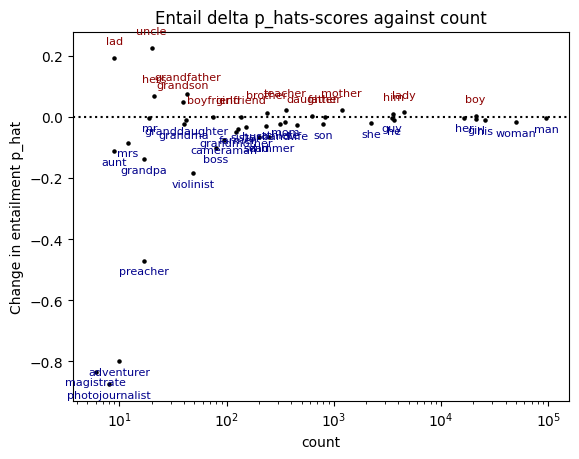

In [ ]:
import matplotlib.pyplot as plt

cls=0
orig_artifacts = [key for key, value in unigram_artifacts[str(cls)].items()]

delta_p = np.array(get_target_values(unigram_target_phats, cls)) - np.array(get_target_values(re_unigram_target_phats, cls))
xs = get_target_values(re_unigram_target_phats, 3)
plt.scatter(xs, delta_p,  label='delta', s=5, color='black')
plt.axhline(y=0, color='black', linestyle='dotted', label='change point')

kys = re_unigram_target_phats.keys()
for i, (k, x, y) in enumerate(zip(kys, xs, delta_p)):
    if y <= 0:
        plt.annotate(k, (x, y), textcoords="offset points", xytext=(0,-10), ha='center', color='darkblue',size =8)
    else:
        plt.annotate(k, (x, y), textcoords="offset points", xytext=(0,10), ha='center', color='darkred',size =8)
    if k in orig_artifacts:
        plt.scatter(x, y,  label='delta', s=5, color='green')

plt.title('Entail delta p_hats-scores against count')
plt.xlabel('count')
plt.ylabel('Change in entailment p_hat')
plt.xscale('log')

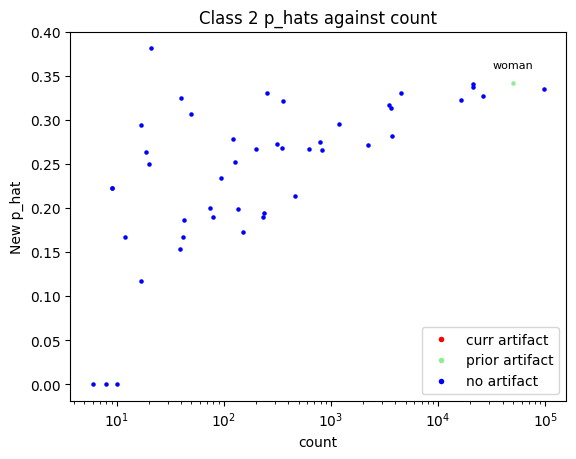

In [ ]:
# plot p-hats for initial artifacts of concern.
# the value we plot though will be the new p_hat
# color it by whether it is an artifact after retraining

import matplotlib.pyplot as plt
unigram_artifacts = {key1: {key2: value for key2, value in inner.items() if value >= SIG_UNI} for key1, inner in unigram_check_zs.items()}

cls = 2
orig_artifacts = [key for key, value in unigram_artifacts[str(cls)].items()]
curr_artifacts = [key for key, value in re_unigram_artifacts[str(cls)].items()]
any_artifacts = set(orig_artifacts).union(set(curr_artifacts))

new_p = get_target_values(re_unigram_target_phats, cls) # entailment p after retraining
xs = get_target_values(re_unigram_target_phats, 3) # count by label after retraining
kys = re_unigram_target_phats.keys()

for i, (k, x, y) in enumerate(zip(kys, xs, new_p)):
    if k in orig_artifacts:
        plt.annotate(k, (x, y), textcoords="offset points", xytext=(0,10), ha='center', color='black',size =8)
        if k in curr_artifacts:
            plt.scatter(x, y, s=5, color='red')
        else:
            plt.scatter(x, y, s=5, color='lightgreen')
    else:
        plt.scatter(x, y, s=5, color='blue')

# Create a legend outside the loop
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=5),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5)]

labels = ['curr artifact', 'prior artifact', 'no artifact']
plt.legend(handles, labels)

plt.title(f'Class {cls} p_hats against count')
plt.xlabel('count')
#plt.legend(['curr_artifact', 'prior artifact', 'no_artifact'])
plt.ylabel('New p_hat')
plt.xscale('log')

In [ ]:
# plot p-hats for initial artifacts of concern.
# the value we plot though will be the new p_hat
# color it by whether it is an artifact after retraining

import matplotlib.pyplot as plt
unigram_artifacts = {key1: {key2: value for key2, value in inner.items() if value >= SIG_UNI} for key1, inner in unigram_check_zs.items()}

cls = 2
orig_artifacts = [key for key, value in unigram_artifacts[str(cls)].items()]
curr_artifacts = [key for key, value in re_unigram_artifacts[str(cls)].items()]

new_p = get_target_values(re_unigram_target_phats, cls) # entailment p after retraining
xs = get_target_values(re_unigram_target_phats, 3) # count by label after retraining
kys = re_unigram_target_phats.keys()

for i, (k, x, y) in enumerate(zip(kys, xs, new_p)):
    if k in orig_artifacts:
        plt.annotate(k, (x, y), textcoords="offset points", xytext=(0,10), ha='center', color='black',size =8)
        if k in curr_artifacts:
            plt.scatter(x, y, s=5, color='red')
        else:
            plt.scatter(x, y, s=5, color='lightgreen')
    else:
        plt.scatter(x, y, s=5, color='blue')

# Create a legend outside the loop
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=5),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5)]

labels = ['curr artifact', 'prior artifact', 'no artifact']
plt.legend(handles, labels)

plt.title(f'Class {cls} p_hats against count')
plt.xlabel('count')
#plt.legend(['curr_artifact', 'prior artifact', 'no_artifact'])
plt.ylabel('New p_hat')
plt.xscale('log')